The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Linear Regression
:label:`sec_linear_regression`

*Regression* problems pop up whenever we want to predict a numerical value.
Common examples include predicting prices (of homes, stocks, etc.),
predicting the length of stay (for patients in the hospital),
forecasting demand (for retail sales), among numerous others.
Not every prediction problem is one of classical regression.
Later on, we will introduce classification problems,
where the goal is to predict membership among a set of categories.

As a running example, suppose that we wish
to estimate the prices of houses (in dollars)
based on their area (in square feet) and age (in years).
To develop a model for predicting house prices,
we need to get our hands on data,
including the sales price, area, and age for each home.
In the terminology of machine learning,
the dataset is called a *training dataset* or *training set*,
and each row (containing the data corresponding to one sale)
is called an *example* (or *data point*, *instance*, *sample*).
The thing we are trying to predict (price)
is called a *label* (or *target*).
The variables (age and area)
upon which the predictions are based
are called *features* (or *covariates*).


In [ ]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

## Basics

*Linear regression* is both the simplest
and most popular among the standard tools
for tackling regression problems.
Dating back to the dawn of the 19th century :cite:`Legendre.1805,Gauss.1809`,
linear regression flows from a few simple assumptions.
First, we assume that the relationship
between features $\mathbf{x}$ and target $y$
is approximately linear,
i.e., that the conditional mean $E[Y \mid X=\mathbf{x}]$
can be expressed as a weighted sum
of the features $\mathbf{x}$.
This setup allows that the target value
may still deviate from its expected value
on account of observation noise.
Next, we can impose the assumption that any such noise
is well behaved, following a Gaussian distribution.
Typically, we will use $n$ to denote
the number of examples in our dataset.
We use superscripts to enumerate samples and targets,
and subscripts to index coordinates.
More concretely,
$\mathbf{x}^{(i)}$ denotes the $i^{\textrm{th}}$ sample
and $x_j^{(i)}$ denotes its $j^{\textrm{th}}$ coordinate.

### Model
:label:`subsec_linear_model`

At the heart of every solution is a model
that describes how features can be transformed
into an estimate of the target.
The assumption of linearity means that
the expected value of the target (price) can be expressed
as a weighted sum of the features (area and age):

$$\textrm{price} = w_{\textrm{area}} \cdot \textrm{area} + w_{\textrm{age}} \cdot \textrm{age} + b.$$
:eqlabel:`eq_price-area`

Here $w_{\textrm{area}}$ and $w_{\textrm{age}}$
are called *weights*, and $b$ is called a *bias*
(or *offset* or *intercept*).
The weights determine the influence of each feature on our prediction.
The bias determines the value of the estimate when all features are zero.
Even though we will never see any newly-built homes with precisely zero area,
we still need the bias because it allows us
to express all linear functions of our features
(rather than restricting us to lines that pass through the origin).
Strictly speaking, :eqref:`eq_price-area` is an *affine transformation* of input features, which is characterized by a *linear transformation* of features via a weighted sum, combined with a *translation* via the added bias.
Given a dataset, our goal is to choose
the weights $\mathbf{w}$ and the bias $b$
that, on average, make our model's predictions
fit the true prices observed in the data as closely as possible.


In disciplines where it is common to focus
on datasets with just a few features,
explicitly expressing models long-form,
as in :eqref:`eq_price-area`, is common.
In machine learning, we usually work
with high-dimensional datasets,
where it is more convenient to employ
compact linear algebra notation.
When our inputs consist of $d$ features,
we can assign each an index (between $1$ and $d$)
and express our prediction $\hat{y}$
(in general the "hat" symbol denotes an estimate) as

$$\hat{y} = w_1  x_1 + \cdots + w_d  x_d + b.$$

Collecting all features into a vector $\mathbf{x} \in \mathbb{R}^d$
and all weights into a vector $\mathbf{w} \in \mathbb{R}^d$,
we can express our model compactly via the dot product
between $\mathbf{w}$ and $\mathbf{x}$:

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$
:eqlabel:`eq_linreg-y`

In :eqref:`eq_linreg-y`, the vector $\mathbf{x}$
corresponds to the features of a single example.
We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.
For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix--vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$
:eqlabel:`eq_linreg-y-vec`

where broadcasting (:numref:`subsec_broadcasting`) is applied during the summation.
Given features of a training dataset $\mathbf{X}$
and corresponding (known) labels $\mathbf{y}$,
the goal of linear regression is to find
the weight vector $\mathbf{w}$ and the bias term $b$
such that, given features of a new data example
sampled from the same distribution as $\mathbf{X}$,
the new example's label will (in expectation)
be predicted with the smallest error.

Even if we believe that the best model for
predicting $y$ given $\mathbf{x}$ is linear,
we would not expect to find a real-world dataset of $n$ examples where
$y^{(i)}$ exactly equals $\mathbf{w}^\top \mathbf{x}^{(i)}+b$
for all $1 \leq i \leq n$.
For example, whatever instruments we use to observe
the features $\mathbf{X}$ and labels $\mathbf{y}$, there might be a small amount of measurement error.
Thus, even when we are confident
that the underlying relationship is linear,
we will incorporate a noise term to account for such errors.

Before we can go about searching for the best *parameters*
(or *model parameters*) $\mathbf{w}$ and $b$,
we will need two more things:
(i) a measure of the quality of some given model;
and (ii) a procedure for updating the model to improve its quality.

### Loss Function
:label:`subsec_linear-regression-loss-function`

Naturally, fitting our model to the data requires
that we agree on some measure of *fitness*
(or, equivalently, of *unfitness*).
*Loss functions* quantify the distance
between the *real* and *predicted* values of the target.
The loss will usually be a nonnegative number
where smaller values are better
and perfect predictions incur a loss of 0.
For regression problems, the most common loss function is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the *squared error* is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$
:eqlabel:`eq_mse`

The constant $\frac{1}{2}$ makes no real difference
but proves to be notationally convenient,
since it cancels out when we take the derivative of the loss.
Because the training dataset is given to us,
and thus is out of our control,
the empirical error is only a function of the model parameters.
In :numref:`fig_fit_linreg`, we visualize the fit of a linear regression model
in a problem with one-dimensional inputs.

![Fitting a linear regression model to one-dimensional data.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/fit-linreg.svg?raw=1)
:label:`fig_fit_linreg`

Note that large differences between
estimates $\hat{y}^{(i)}$ and targets $y^{(i)}$
lead to even larger contributions to the loss,
due to its quadratic form
(this quadraticity can be a double-edge sword; while it encourages the model to avoid large errors
it can also lead to excessive sensitivity to anomalous data).
To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set:

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we seek parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$

### Analytic Solution

Unlike most of the models that we will cover,
linear regression presents us with
a surprisingly easy optimization problem.
In particular, we can find the optimal parameters
(as assessed on the training data)
analytically by applying a simple formula as follows.
First, we can subsume the bias $b$ into the parameter $\mathbf{w}$
by appending a column to the design matrix consisting of all 1s.
Then our prediction problem is to minimize $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$.
As long as the design matrix $\mathbf{X}$ has full rank
(no feature is linearly dependent on the others),
then there will be just one critical point on the loss surface
and it corresponds to the minimum of the loss over the entire domain.
Taking the derivative of the loss with respect to $\mathbf{w}$
and setting it equal to zero yields:

$$\begin{aligned}
    \partial_{\mathbf{w}} \|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2 =
    2 \mathbf{X}^\top (\mathbf{X} \mathbf{w} - \mathbf{y}) = 0
    \textrm{ and hence }
    \mathbf{X}^\top \mathbf{y} = \mathbf{X}^\top \mathbf{X} \mathbf{w}.
\end{aligned}$$

Solving for $\mathbf{w}$ provides us with the optimal solution
for the optimization problem.
Note that this solution

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}$$

will only be unique
when the matrix $\mathbf X^\top \mathbf X$ is invertible,
i.e., when the columns of the design matrix
are linearly independent :cite:`Golub.Van-Loan.1996`.



While simple problems like linear regression
may admit analytic solutions,
you should not get used to such good fortune.
Although analytic solutions allow for nice mathematical analysis,
the requirement of an analytic solution is so restrictive
that it would exclude almost all exciting aspects of deep learning.

### Minibatch Stochastic Gradient Descent

Fortunately, even in cases where we cannot solve the models analytically,
we can still often train models effectively in practice.
Moreover, for many tasks, those hard-to-optimize models
turn out to be so much better that figuring out how to train them
ends up being well worth the trouble.

The key technique for optimizing nearly every deep learning model,
and which we will call upon throughout this book,
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function.
This algorithm is called *gradient descent*.

The most naive application of gradient descent
consists of taking the derivative of the loss function,
which is an average of the losses computed
on every single example in the dataset.
In practice, this can be extremely slow:
we must pass over the entire dataset before making a single update,
even if the update steps might be very powerful :cite:`Liu.Nocedal.1989`.
Even worse, if there is a lot of redundancy in the training data,
the benefit of a full update is limited.

The other extreme is to consider only a single example at a time and to take
update steps based on one observation at a time.
The resulting algorithm, *stochastic gradient descent* (SGD)
can be an effective strategy :cite:`Bottou.2010`, even for large datasets.
Unfortunately, SGD has drawbacks, both computational and statistical.
One problem arises from the fact that processors are a lot faster
multiplying and adding numbers than they are
at moving data from main memory to processor cache.
It is up to an order of magnitude more efficient to
perform a matrix--vector multiplication
than a corresponding number of vector--vector operations.
This means that it can take a lot longer to process
one sample at a time compared to a full batch.
A second problem is that some of the layers,
such as batch normalization (to be described in :numref:`sec_batch_norm`),
only work well when we have access
to more than one observation at a time.

The solution to both problems is to pick an intermediate strategy:
rather than taking a full batch or only a single sample at a time,
we take a *minibatch* of observations :cite:`Li.Zhang.Chen.ea.2014`.
The specific choice of the size of the said minibatch depends on many factors,
such as the amount of memory, the number of accelerators,
the choice of layers, and the total dataset size.
Despite all that, a number between 32 and 256,
preferably a multiple of a large power of $2$, is a good start.
This leads us to *minibatch stochastic gradient descent*.

In its most basic form, in each iteration $t$,
we first randomly sample a minibatch $\mathcal{B}_t$
consisting of a fixed number $|\mathcal{B}|$ of training examples.
We then compute the derivative (gradient) of the average loss
on the minibatch with respect to the model parameters.
Finally, we multiply the gradient
by a predetermined small positive value $\eta$,
called the *learning rate*,
and subtract the resulting term from the current parameter values.
We can express the update as follows:

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

In summary, minibatch SGD proceeds as follows:
(i) initialize the values of the model parameters, typically at random;
(ii) iteratively sample random minibatches from the data,
updating the parameters in the direction of the negative gradient.
For quadratic losses and affine transformations,
this has a closed-form expansion:

$$\begin{aligned} \mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_b l^{(i)}(\mathbf{w}, b) &&  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$
:eqlabel:`eq_linreg_batch_update`

Since we pick a minibatch $\mathcal{B}$
we need to normalize by its size $|\mathcal{B}|$.
Frequently minibatch size and learning rate are user-defined.
Such tunable parameters that are not updated
in the training loop are called *hyperparameters*.
They can be tuned automatically by a number of techniques, such as Bayesian optimization
:cite:`Frazier.2018`. In the end, the quality of the solution is
typically assessed on a separate *validation dataset* (or *validation set*).

After training for some predetermined number of iterations
(or until some other stopping criterion is met),
we record the estimated model parameters,
denoted $\hat{\mathbf{w}}, \hat{b}$.
Note that even if our function is truly linear and noiseless,
these parameters will not be the exact minimizers of the loss, nor even deterministic.
Although the algorithm converges slowly towards the minimizers
it typically will not find them exactly in a finite number of steps.
Moreover, the minibatches $\mathcal{B}$
used for updating the parameters are chosen at random.
This breaks determinism.

Linear regression happens to be a learning problem
with a global minimum
(whenever $\mathbf{X}$ is full rank, or equivalently,
whenever $\mathbf{X}^\top \mathbf{X}$ is invertible).
However, the loss surfaces for deep networks contain many saddle points and minima.
Fortunately, we typically do not care about finding
an exact set of parameters but merely any set of parameters
that leads to accurate predictions (and thus low loss).
In practice, deep learning practitioners
seldom struggle to find parameters
that minimize the loss *on training sets*
:cite:`Izmailov.Podoprikhin.Garipov.ea.2018,Frankle.Carbin.2018`.
The more formidable task is to find parameters
that lead to accurate predictions on previously unseen data,
a challenge called *generalization*.
We return to these topics throughout the book.

### Predictions

Given the model $\hat{\mathbf{w}}^\top \mathbf{x} + \hat{b}$,
we can now make *predictions* for a new example,
e.g., predicting the sales price of a previously unseen house
given its area $x_1$ and age $x_2$.
Deep learning practitioners have taken to calling the prediction phase *inference*
but this is a bit of a misnomer---*inference* refers broadly
to any conclusion reached on the basis of evidence,
including both the values of the parameters
and the likely label for an unseen instance.
If anything, in the statistics literature
*inference* more often denotes parameter inference
and this overloading of terminology creates unnecessary confusion
when deep learning practitioners talk to statisticians.
In the following we will stick to *prediction* whenever possible.



## Vectorization for Speed

When training our models, we typically want to process
whole minibatches of examples simultaneously.
Doing this efficiently requires that (**we**) (~~should~~)
(**vectorize the calculations and leverage
fast linear algebra libraries
rather than writing costly for-loops in Python.**)

To see why this matters so much,
let's (**consider two methods for adding vectors.**)
To start, we instantiate two 10,000-dimensional vectors
containing all 1s.
In the first method, we loop over the vectors with a Python for-loop.
In the second, we rely on a single call to `+`.


In [ ]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

Now we can benchmark the workloads.
First, [**we add them, one coordinate at a time,
using a for-loop.**]


In [ ]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.17802 sec'

(**Alternatively, we rely on the reloaded `+` operator to compute the elementwise sum.**)


In [ ]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00036 sec'

The second method is dramatically faster than the first.
Vectorizing code often yields order-of-magnitude speedups.
Moreover, we push more of the mathematics to the library
so we do not have to write as many calculations ourselves,
reducing the potential for errors and increasing portability of the code.


## The Normal Distribution and Squared Loss
:label:`subsec_normal_distribution_and_squared_loss`

So far we have given a fairly functional motivation
of the squared loss objective:
the optimal parameters return the conditional expectation $E[Y\mid X]$
whenever the underlying pattern is truly linear,
and the loss assigns large penalties for outliers.
We can also provide a more formal motivation
for the squared loss objective
by making probabilistic assumptions
about the distribution of noise.

Linear regression was invented at the turn of the 19th century.
While it has long been debated whether Gauss or Legendre
first thought up the idea,
it was Gauss who also discovered the normal distribution
(also called the *Gaussian*).
It turns out that the normal distribution
and linear regression with squared loss
share a deeper connection than common parentage.

To begin, recall that a normal distribution
with mean $\mu$ and variance $\sigma^2$ (standard deviation $\sigma$)
is given as

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

Below [**we define a function to compute the normal distribution**].


In [ ]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

We can now (**visualize the normal distributions**).


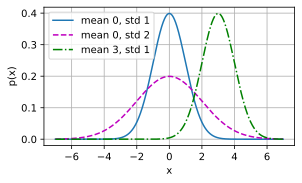

In [ ]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

Note that changing the mean corresponds
to a shift along the $x$-axis,
and increasing the variance
spreads the distribution out,
lowering its peak.

One way to motivate linear regression with squared loss
is to assume that observations arise from noisy measurements,
where the noise $\epsilon$ follows the normal distribution
$\mathcal{N}(0, \sigma^2)$:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \textrm{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

Thus, we can now write out the *likelihood*
of seeing a particular $y$ for a given $\mathbf{x}$ via

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

As such, the likelihood factorizes.
According to *the principle of maximum likelihood*,
the best values of parameters $\mathbf{w}$ and $b$ are those
that maximize the *likelihood* of the entire dataset:

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)}).$$

The equality follows since all pairs $(\mathbf{x}^{(i)}, y^{(i)})$
were drawn independently of each other.
Estimators chosen according to the principle of maximum likelihood
are called *maximum likelihood estimators*.
While, maximizing the product of many exponential functions,
might look difficult,
we can simplify things significantly, without changing the objective,
by maximizing the logarithm of the likelihood instead.
For historical reasons, optimizations are more often expressed
as minimization rather than maximization.
So, without changing anything,
we can *minimize* the *negative log-likelihood*,
which we can express as follows:

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

If we assume that $\sigma$ is fixed,
we can ignore the first term,
because it does not depend on $\mathbf{w}$ or $b$.
The second term is identical
to the squared error loss introduced earlier,
except for the multiplicative constant $\frac{1}{\sigma^2}$.
Fortunately, the solution does not depend on $\sigma$ either.
It follows that minimizing the mean squared error
is equivalent to the maximum likelihood estimation
of a linear model under the assumption of additive Gaussian noise.


## Linear Regression as a Neural Network

While linear models are not sufficiently rich
to express the many complicated networks
that we will introduce in this book,
(artificial) neural networks are rich enough
to subsume linear models as networks
in which every feature is represented by an input neuron,
all of which are connected directly to the output.

:numref:`fig_single_neuron` depicts
linear regression as a neural network.
The diagram highlights the connectivity pattern,
such as how each input is connected to the output,
but not the specific values taken by the weights or biases.

![Linear regression is a single-layer neural network.](http://d2l.ai/_images/singleneuron.svg)
:label:`fig_single_neuron`

The inputs are $x_1, \ldots, x_d$.
We refer to $d$ as the *number of inputs*
or the *feature dimensionality* in the input layer.
The output of the network is $o_1$.
Because we are just trying to predict
a single numerical value,
we have only one output neuron.
Note that the input values are all *given*.
There is just a single *computed* neuron.
In summary, we can think of linear regression
as a single-layer fully connected neural network.
We will encounter networks
with far more layers
in later chapters.

### Biology

Because linear regression predates computational neuroscience,
it might seem anachronistic to describe
linear regression in terms of neural networks.
Nonetheless, they were a natural place to start
when the cyberneticists and neurophysiologists
Warren McCulloch and Walter Pitts began to develop
models of artificial neurons.
Consider the cartoonish picture
of a biological neuron in :numref:`fig_Neuron`,
consisting of *dendrites* (input terminals),
the *nucleus* (CPU), the *axon* (output wire),
and the *axon terminals* (output terminals),
enabling connections to other neurons via *synapses*.

![The real neuron (source: "Anatomy and Physiology" by the US National Cancer Institute's Surveillance, Epidemiology and End Results (SEER) Program).](http://d2l.ai/_images/neuron.svg)
:label:`fig_Neuron`

Information $x_i$ arriving from other neurons
(or environmental sensors) is received in the dendrites.
In particular, that information is weighted
by *synaptic weights* $w_i$,
determining the effect of the inputs,
e.g., activation or inhibition via the product $x_i w_i$.
The weighted inputs arriving from multiple sources
are aggregated in the nucleus
as a weighted sum $y = \sum_i x_i w_i + b$,
possibly subject to some nonlinear postprocessing via a function $\sigma(y)$.
This information is then sent via the axon to the axon terminals,
where it reaches its destination
(e.g., an actuator such as a muscle)
or it is fed into another neuron via its dendrites.

Certainly, the high-level idea that many such units
could be combined, provided they have the correct connectivity and learning algorithm,
to produce far more interesting and complex behavior
than any one neuron alone could express
arises from our study of real biological neural systems.
At the same time, most research in deep learning today
draws inspiration from a much wider source.
We invoke :citet:`Russell.Norvig.2016`
who pointed out that although airplanes might have been *inspired* by birds,
ornithology has not been the primary driver
of aeronautics innovation for some centuries.
Likewise, inspiration in deep learning these days
comes in equal or greater measure
from mathematics, linguistics, psychology,
statistics, computer science, and many other fields.

## Summary

In this section, we introduced
traditional linear regression,
where the parameters of a linear function
are chosen to minimize squared loss on the training set.
We also motivated this choice of objective
both via some practical considerations
and through an interpretation
of linear regression as maximimum likelihood estimation
under an assumption of linearity and Gaussian noise.
After discussing both computational considerations
and connections to statistics,
we showed how such linear models could be expressed
as simple neural networks where the inputs
are directly wired to the output(s).
While we will soon move past linear models altogether,
they are sufficient to introduce most of the components
that all of our models require:
parametric forms, differentiable objectives,
optimization via minibatch stochastic gradient descent,
and ultimately, evaluation on previously unseen data.



## Exercises

1. Assume that we have some data $x_1, \ldots, x_n \in \mathbb{R}$. Our goal is to find a constant $b$ such that $\sum_i (x_i - b)^2$ is minimized.
    1. Find an analytic solution for the optimal value of $b$.
    1. How does this problem and its solution relate to the normal distribution?
    1. What if we change the loss from $\sum_i (x_i - b)^2$ to $\sum_i |x_i-b|$? Can you find the optimal solution for $b$?
1. Prove that the affine functions that can be expressed by $\mathbf{x}^\top \mathbf{w} + b$ are equivalent to linear functions on $(\mathbf{x}, 1)$.
1. Assume that you want to find quadratic functions of $\mathbf{x}$, i.e., $f(\mathbf{x}) = b + \sum_i w_i x_i + \sum_{j \leq i} w_{ij} x_{i} x_{j}$. How would you formulate this in a deep network?
1. Recall that one of the conditions for the linear regression problem to be solvable was that the design matrix $\mathbf{X}^\top \mathbf{X}$ has full rank.
    1. What happens if this is not the case?
    1. How could you fix it? What happens if you add a small amount of coordinate-wise independent Gaussian noise to all entries of $\mathbf{X}$?
    1. What is the expected value of the design matrix $\mathbf{X}^\top \mathbf{X}$ in this case?
    1. What happens with stochastic gradient descent when $\mathbf{X}^\top \mathbf{X}$ does not have full rank?
1. Assume that the noise model governing the additive noise $\epsilon$ is the exponential distribution. That is, $p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$.
    1. Write out the negative log-likelihood of the data under the model $-\log P(\mathbf y \mid \mathbf X)$.
    1. Can you find a closed form solution?
    1. Suggest a minibatch stochastic gradient descent algorithm to solve this problem. What could possibly go wrong (hint: what happens near the stationary point as we keep on updating the parameters)? Can you fix this?
1. Assume that we want to design a neural network with two layers by composing two linear layers. That is, the output of the first layer becomes the input of the second layer. Why would such a naive composition not work?
1. What happens if you want to use regression for realistic price estimation of houses or stock prices?
    1. Show that the additive Gaussian noise assumption is not appropriate. Hint: can we have negative prices? What about fluctuations?
    1. Why would regression to the logarithm of the price be much better, i.e., $y = \log \textrm{price}$?
    1. What do you need to worry about when dealing with pennystock, i.e., stock with very low prices? Hint: can you trade at all possible prices? Why is this a bigger problem for cheap stock? For more information review the celebrated Black--Scholes model for option pricing :cite:`Black.Scholes.1973`.
1. Suppose we want to use regression to estimate the *number* of apples sold in a grocery store.
    1. What are the problems with a Gaussian additive noise model? Hint: you are selling apples, not oil.
    1. The [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) captures distributions over counts. It is given by $p(k \mid \lambda) = \lambda^k e^{-\lambda}/k!$. Here $\lambda$ is the rate function and $k$ is the number of events you see. Prove that $\lambda$ is the expected value of counts $k$.
    1. Design a loss function associated with the Poisson distribution.
    1. Design a loss function for estimating $\log \lambda$ instead.


[Discussions](https://discuss.d2l.ai/t/258)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Object-Oriented Design for Implementation
:label:`sec_oo-design`

In our introduction to linear regression,
we walked through various components
including
the data, the model, the loss function,
and the optimization algorithm.
Indeed,
linear regression is
one of the simplest machine learning models.
Training it,
however, uses many of the same components that other models in this book require.
Therefore,
before diving into the implementation details
it is worth
designing some of the APIs
that we use throughout.
Treating components in deep learning
as objects,
we can start by
defining classes for these objects
and their interactions.
This object-oriented design
for implementation
will greatly
streamline the presentation and you might even want to use it in your projects.


Inspired by open-source libraries such as [PyTorch Lightning](https://www.pytorchlightning.ai/),
at a high level
we wish to have three classes:
(i) `Module` contains models, losses, and optimization methods;
(ii) `DataModule` provides data loaders for training and validation;
(iii) both classes are combined using the `Trainer` class, which allows us to
train models on a variety of hardware platforms.
Most code in this book adapts `Module` and `DataModule`. We will touch upon the `Trainer` class only when we discuss GPUs, CPUs, parallel training, and optimization algorithms.


In [ ]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## Utilities
:label:`oo-design-utilities`

We need a few utilities to simplify object-oriented programming in Jupyter notebooks. One of the challenges is that class definitions tend to be fairly long blocks of code. Notebook readability demands short code fragments, interspersed with explanations, a requirement incompatible with the style of programming common for Python libraries. The first
utility function allows us to register functions as methods in a class *after* the class has been created. In fact, we can do so *even after* we have created instances of the class! It allows us to split the implementation of a class into multiple code blocks.


In [ ]:
def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

Let's have a quick look at how to use it. We plan to implement a class `A` with a method `do`. Instead of having code for both `A` and `do` in the same code block, we can first declare the class `A` and create an instance `a`.


In [ ]:
class A:
    def __init__(self):
        self.b = 1

a = A()

Next we define the method `do` as we normally would, but not in class `A`'s scope. Instead, we decorate this method by `add_to_class` with class `A` as its argument. In doing so, the method is able to access the member variables of `A` just as we would expect had it been included as part of `A`'s definition. Let's see what happens when we invoke it for the instance `a`.


In [ ]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


The second one is a utility class that saves all arguments in a class's `__init__` method as class attributes. This allows us to extend constructor call signatures implicitly without additional code.


In [ ]:
class HyperParameters:  #@save
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

We defer its implementation into :numref:`sec_utils`. To use it, we define our class that inherits from `HyperParameters` and calls `save_hyperparameters` in the `__init__` method.


In [ ]:
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


The final utility allows us to plot experiment progress interactively while it is going on. In deference to the much more powerful (and complex) [TensorBoard](https://www.tensorflow.org/tensorboard) we name it `ProgressBoard`. The  implementation is deferred to :numref:`sec_utils`. For now, let's simply see it in action.

The `draw` method plots a point `(x, y)` in the figure, with `label` specified in the legend. The optional `every_n` smooths the line by only showing $1/n$ points in the figure. Their values are averaged from the $n$ neighbor points in the original figure.


In [ ]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

In the following example, we draw `sin` and `cos` with a different smoothness. If you run this code block, you will see the lines grow in animation.


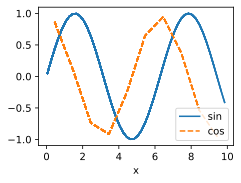

In [ ]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

## Models
:label:`subsec_oo-design-models`

The `Module` class is the base class of all models we will implement. At the very least we need three methods. The first, `__init__`, stores the learnable parameters, the `training_step` method accepts a data batch to return the loss value, and finally, `configure_optimizers` returns the optimization method, or a list of them, that is used to update the learnable parameters. Optionally we can define `validation_step` to report the evaluation measures.
Sometimes we put the code for computing the output into a separate `forward` method to make it more reusable.


In [ ]:
class Module(nn.Module, d2l.HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

You may notice that `Module` is a subclass of `nn.Module`, the base class of neural networks in PyTorch.
It provides convenient features for handling neural networks. For example, if we define a `forward` method, such as `forward(self, X)`, then for an instance `a` we can invoke this method by `a(X)`. This works since it calls the `forward` method in the built-in `__call__` method. You can find more details and examples about `nn.Module` in :numref:`sec_model_construction`.


##  Data
:label:`oo-design-data`

The `DataModule` class is the base class for data. Quite frequently the `__init__` method is used to prepare the data. This includes downloading and preprocessing if needed. The `train_dataloader` returns the data loader for the training dataset. A data loader is a (Python) generator that yields a data batch each time it is used. This batch is then fed into the `training_step` method of `Module` to compute the loss. There is an optional `val_dataloader` to return the validation dataset loader. It behaves in the same manner, except that it yields data batches for the `validation_step` method in `Module`.


In [ ]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

## Training
:label:`oo-design-training`


The `Trainer` class trains the learnable parameters in the `Module` class with data specified in `DataModule`. The key method is `fit`, which accepts two arguments: `model`, an instance of `Module`, and `data`, an instance of `DataModule`. It then iterates over the entire dataset `max_epochs` times to train the model. As before, we will defer the implementation of this method to later chapters.


In [ ]:
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

## Summary

To highlight the object-oriented design
for our future deep learning implementation,
the above classes simply show how their objects
store data and interact with each other.
We will keep enriching implementations of these classes,
such as via `@add_to_class`,
in the rest of the book.
Moreover,
these fully implemented classes
are saved in the [D2L library](https://github.com/d2l-ai/d2l-en/tree/master/d2l),
a *lightweight toolkit* that makes structured modeling for deep learning easy.
In particular, it facilitates reusing many components between projects without changing much at all. For instance, we can replace just the optimizer, just the model, just the dataset, etc.;
this degree of modularity pays dividends throughout the book in terms of conciseness and simplicity (this is why we added it) and it can do the same for your own projects.


## Exercises

1. Locate full implementations of the above classes that are saved in the [D2L library](https://github.com/d2l-ai/d2l-en/tree/master/d2l). We strongly recommend that you look at the implementation in detail once you have gained some more familiarity with deep learning modeling.
1. Remove the `save_hyperparameters` statement in the `B` class. Can you still print `self.a` and `self.b`? Optional: if you have dived into the full implementation of the `HyperParameters` class, can you explain why?


[Discussions](https://discuss.d2l.ai/t/6646)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Synthetic Regression Data
:label:`sec_synthetic-regression-data`


Machine learning is all about extracting information from data.
So you might wonder, what could we possibly learn from synthetic data?
While we might not care intrinsically about the patterns
that we ourselves baked into an artificial data generating model,
such datasets are nevertheless useful for didactic purposes,
helping us to evaluate the properties of our learning
algorithms and to confirm that our implementations work as expected.
For example, if we create data for which the correct parameters are known *a priori*,
then we can check that our model can in fact recover them.


In [ ]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## Generating the Dataset

For this example, we will work in low dimension
for succinctness.
The following code snippet generates 1000 examples
with 2-dimensional features drawn
from a standard normal distribution.
The resulting design matrix $\mathbf{X}$
belongs to $\mathbb{R}^{1000 \times 2}$.
We generate each label by applying
a *ground truth* linear function,
corrupting them via additive noise $\boldsymbol{\epsilon}$,
drawn independently and identically for each example:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \boldsymbol{\epsilon}.$$**)

For convenience we assume that $\boldsymbol{\epsilon}$ is drawn
from a normal distribution with mean $\mu= 0$
and standard deviation $\sigma = 0.01$.
Note that for object-oriented design
we add the code to the `__init__` method of a subclass of `d2l.DataModule` (introduced in :numref:`oo-design-data`).
It is good practice to allow the setting of any additional hyperparameters.
We accomplish this with `save_hyperparameters()`.
The `batch_size` will be determined later.


In [ ]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

Below, we set the true parameters to $\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$.
Later, we can check our estimated parameters against these *ground truth* values.


In [ ]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

[**Each row in `features` consists of a vector in $\mathbb{R}^2$ and each row in `labels` is a scalar.**] Let's have a look at the first entry.


In [ ]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([0.9026, 1.0264]) 
label: tensor([2.5148])


## Reading the Dataset

Training machine learning models often requires multiple passes over a dataset,
grabbing one minibatch of examples at a time.
This data is then used to update the model.
To illustrate how this works, we
[**implement the `get_dataloader` method,**]
registering it in the `SyntheticRegressionData` class via `add_to_class` (introduced in :numref:`oo-design-utilities`).
It (**takes a batch size, a matrix of features,
and a vector of labels, and generates minibatches of size `batch_size`.**)
As such, each minibatch consists of a tuple of features and labels.
Note that we need to be mindful of whether we're in training or validation mode:
in the former, we will want to read the data in random order,
whereas for the latter, being able to read data in a pre-defined order
may be important for debugging purposes.


In [ ]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

To build some intuition, let's inspect the first minibatch of
data. Each minibatch of features provides us with both its size and the dimensionality of input features.
Likewise, our minibatch of labels will have a matching shape given by `batch_size`.


In [ ]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


While seemingly innocuous, the invocation
of `iter(data.train_dataloader())`
illustrates the power of Python's object-oriented design.
Note that we added a method to the `SyntheticRegressionData` class
*after* creating the `data` object.
Nonetheless, the object benefits from
the *ex post facto* addition of functionality to the class.

Throughout the iteration we obtain distinct minibatches
until the entire dataset has been exhausted (try this).
While the iteration implemented above is good for didactic purposes,
it is inefficient in ways that might get us into trouble with real problems.
For example, it requires that we load all the data in memory
and that we perform lots of random memory access.
The built-in iterators implemented in a deep learning framework
are considerably more efficient and they can deal
with sources such as data stored in files,
data received via a stream,
and data generated or processed on the fly.
Next let's try to implement the same method using built-in iterators.

## Concise Implementation of the Data Loader

Rather than writing our own iterator,
we can [**call the existing API in a framework to load data.**]
As before, we need a dataset with features `X` and labels `y`.
Beyond that, we set `batch_size` in the built-in data loader
and let it take care of shuffling examples  efficiently.


In [ ]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

In [ ]:
@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

The new data loader behaves just like the previous one, except that it is more efficient and has some added functionality.


In [ ]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


For instance, the data loader provided by the framework API
supports the built-in `__len__` method,
so we can query its length,
i.e., the number of batches.


In [ ]:
len(data.train_dataloader())

32

## Summary

Data loaders are a convenient way of abstracting out
the process of loading and manipulating data.
This way the same machine learning *algorithm*
is capable of processing many different types and sources of data
without the need for modification.
One of the nice things about data loaders
is that they can be composed.
For instance, we might be loading images
and then have a postprocessing filter
that crops them or modifies them in other ways.
As such, data loaders can be used
to describe an entire data processing pipeline.

As for the model itself, the two-dimensional linear model
is about the simplest we might encounter.
It lets us test out the accuracy of regression models
without worrying about having insufficient amounts of data
or an underdetermined system of equations.
We will put this to good use in the next section.  


## Exercises

1. What will happen if the number of examples cannot be divided by the batch size. How would you change this behavior by specifying a different argument by using the framework's API?
1. Suppose that we want to generate a huge dataset, where both the size of the parameter vector `w` and the number of examples `num_examples` are large.
    1. What happens if we cannot hold all data in memory?
    1. How would you shuffle the data if it is held on disk? Your task is to design an *efficient* algorithm that does not require too many random reads or writes. Hint: [pseudorandom permutation generators](https://en.wikipedia.org/wiki/Pseudorandom_permutation) allow you to design a reshuffle without the need to store the permutation table explicitly :cite:`Naor.Reingold.1999`.
1. Implement a data generator that produces new data on the fly, every time the iterator is called.
1. How would you design a random data generator that generates *the same* data each time it is called?


[Discussions](https://discuss.d2l.ai/t/6663)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Linear Regression Implementation from Scratch
:label:`sec_linear_scratch`

We are now ready to work through
a fully functioning implementation
of linear regression.
In this section,
(**we will implement the entire method from scratch,
including (i) the model; (ii) the loss function;
(iii) a minibatch stochastic gradient descent optimizer;
and (iv) the training function
that stitches all of these pieces together.**)
Finally, we will run our synthetic data generator
from :numref:`sec_synthetic-regression-data`
and apply our model
on the resulting dataset.
While modern deep learning frameworks
can automate nearly all of this work,
implementing things from scratch is the only way
to make sure that you really know what you are doing.
Moreover, when it is time to customize models,
defining our own layers or loss functions,
understanding how things work under the hood will prove handy.
In this section, we will rely only
on tensors and automatic differentiation.
Later, we will introduce a more concise implementation,
taking advantage of the bells and whistles of deep learning frameworks
while retaining the structure of what follows below.


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Defining the Model

[**Before we can begin optimizing our model's parameters**] by minibatch SGD,
(**we need to have some parameters in the first place.**)
In the following we initialize weights by drawing
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01.
The magic number 0.01 often works well in practice,
but you can specify a different value
through the argument `sigma`.
Moreover we set the bias to 0.
Note that for object-oriented design
we add the code to the `__init__` method of a subclass of `d2l.Module` (introduced in :numref:`subsec_oo-design-models`).


In [ ]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

Next we must [**define our model,
relating its input and parameters to its output.**]
Using the same notation as :eqref:`eq_linreg-y-vec`
for our linear model we simply take the matrix--vector product
of the input features $\mathbf{X}$
and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
The product $\mathbf{Xw}$ is a vector and $b$ is a scalar.
Because of the broadcasting mechanism
(see :numref:`subsec_broadcasting`),
when we add a vector and a scalar,
the scalar is added to each component of the vector.
The resulting `forward` method
is registered in the `LinearRegressionScratch` class
via `add_to_class` (introduced in :numref:`oo-design-utilities`).


In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

## Defining the Loss Function

Since [**updating our model requires taking
the gradient of our loss function,**]
we ought to (**define the loss function first.**)
Here we use the squared loss function
in :eqref:`eq_mse`.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following method
will also have the same shape as `y_hat`.
We also return the averaged loss value
among all examples in the minibatch.


In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

## Defining the Optimization Algorithm

As discussed in :numref:`sec_linear_regression`,
linear regression has a closed-form solution.
However, our goal here is to illustrate
how to train more general neural networks,
and that requires that we teach you
how to use minibatch SGD.
Hence we will take this opportunity
to introduce your first working example of SGD.
At each step, using a minibatch
randomly drawn from our dataset,
we estimate the gradient of the loss
with respect to the parameters.
Next, we update the parameters
in the direction that may reduce the loss.

The following code applies the update,
given a set of parameters, a learning rate `lr`.
Since our loss is computed as an average over the minibatch,
we do not need to adjust the learning rate against the batch size.
In later chapters we will investigate
how learning rates should be adjusted
for very large minibatches as they arise
in distributed large-scale learning.
For now, we can ignore this dependency.


We define our `SGD` class,
a subclass of `d2l.HyperParameters` (introduced in :numref:`oo-design-utilities`),
to have a similar API
as the built-in SGD optimizer.
We update the parameters in the `step` method.
The `zero_grad` method sets all gradients to 0,
which must be run before a backpropagation step.


In [ ]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

We next define the `configure_optimizers` method, which returns an instance of the `SGD` class.


In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

## Training

Now that we have all of the parts in place
(parameters, loss function, model, and optimizer),
we are ready to [**implement the main training loop.**]
It is crucial that you understand this code fully
since you will employ similar training loops
for every other deep learning model
covered in this book.
In each *epoch*, we iterate through
the entire training dataset,
passing once through every example
(assuming that the number of examples
is divisible by the batch size).
In each *iteration*, we grab a minibatch of training examples,
and compute its loss through the model's `training_step` method.
Then we compute the gradients with respect to each parameter.
Finally, we will call the optimization algorithm
to update the model parameters.
In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

Recall that the synthetic regression dataset
that we generated in :numref:``sec_synthetic-regression-data``
does not provide a validation dataset.
In most cases, however,
we will want a validation dataset
to measure our model quality.
Here we pass the validation dataloader
once in each epoch to measure the model performance.
Following our object-oriented design,
the `prepare_batch` and `fit_epoch` methods
are registered in the `d2l.Trainer` class
(introduced in :numref:`oo-design-training`).


In [ ]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

In [ ]:
@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

We are almost ready to train the model,
but first we need some training data.
Here we use the `SyntheticRegressionData` class
and pass in some ground truth parameters.
Then we train our model with
the learning rate `lr=0.03`
and set `max_epochs=3`.
Note that in general, both the number of epochs
and the learning rate are hyperparameters.
In general, setting hyperparameters is tricky
and we will usually want to use a three-way split,
one set for training,
a second for hyperparameter selection,
and the third reserved for the final evaluation.
We elide these details for now but will revise them
later.


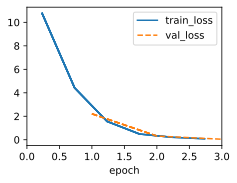

In [ ]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.


In [ ]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1408, -0.1493])
error in estimating b: tensor([0.2130])


We should not take the ability to exactly recover
the ground truth parameters for granted.
In general, for deep models unique solutions
for the parameters do not exist,
and even for linear models,
exactly recovering the parameters
is only possible when no feature
is linearly dependent on the others.
However, in machine learning,
we are often less concerned
with recovering true underlying parameters,
but rather with parameters
that lead to highly accurate prediction :cite:`Vapnik.1992`.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.


## Summary

In this section, we took a significant step
towards designing deep learning systems
by implementing a fully functional
neural network model and training loop.
In this process, we built a data loader,
a model, a loss function, an optimization procedure,
and a visualization and monitoring tool.
We did this by composing a Python object
that contains all relevant components for training a model.
While this is not yet a professional-grade implementation
it is perfectly functional and code like this
could already help you to solve small problems quickly.
In the coming sections, we will see how to do this
both *more concisely* (avoiding boilerplate code)
and *more efficiently* (using our GPUs to their full potential).



## Exercises

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we
   initialized the parameters with variance $1000$ rather than $0.01$?
1. Assume that you are [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up
   with a model for resistance that relates voltage and current. Can you use automatic
   differentiation to learn the parameters of your model?
1. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object
   using spectral energy density? For reference, the spectral density $B$ of radiation emanating from a black body is
   $B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$. Here
   $\lambda$ is the wavelength, $T$ is the temperature, $c$ is the speed of light, $h$ is Planck's constant, and $k$ is the
   Boltzmann constant. You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral
   density curve to Planck's law.
1. What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would
   you fix them?
1. Why is the `reshape` method needed in the `loss` function?
1. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the
   error by increasing the number of epochs of training?
1. If the number of examples cannot be divided by the batch size, what happens to `data_iter` at the end of an epoch?
1. Try implementing a different loss function, such as the absolute value loss `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`.
    1. Check what happens for regular data.
    1. Check whether there is a difference in behavior if you actively perturb some entries, such as $y_5 = 10000$, of $\mathbf{y}$.
    1. Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss?
       Hint: how can you avoid really large gradient values?
1. Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?


[Discussions](https://discuss.d2l.ai/t/43)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Concise Implementation of Linear Regression
:label:`sec_linear_concise`

Deep learning has witnessed a sort of Cambrian explosion
over the past decade.
The sheer number of techniques, applications and algorithms by far surpasses the
progress of previous decades.
This is due to a fortuitous combination of multiple factors,
one of which is the powerful free tools
offered by a number of open-source deep learning frameworks.
Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010`,
DistBelief :cite:`Dean.Corrado.Monga.ea.2012`,
and Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014`
arguably represent the
first generation of such models
that found widespread adoption.
In contrast to earlier (seminal) works like
SN2 (Simulateur Neuristique) :cite:`Bottou.Le-Cun.1988`,
which provided a Lisp-like programming experience,
modern frameworks offer automatic differentiation
and the convenience of Python.
These frameworks allow us to automate and modularize
the repetitive work of implementing gradient-based learning algorithms.

In :numref:`sec_linear_scratch`, we relied only on
(i) tensors for data storage and linear algebra;
and (ii) automatic differentiation for calculating gradients.
In practice, because data iterators, loss functions, optimizers,
and neural network layers
are so common, modern libraries implement these components for us as well.
In this section, (**we will show you how to implement
the linear regression model**) from :numref:`sec_linear_scratch`
(**concisely by using high-level APIs**) of deep learning frameworks.


In [ ]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## Defining the Model

When we implemented linear regression from scratch
in :numref:`sec_linear_scratch`,
we defined our model parameters explicitly
and coded up the calculations to produce output
using basic linear algebra operations.
You *should* know how to do this.
But once your models get more complex,
and once you have to do this nearly every day,
you will be glad of the assistance.
The situation is similar to coding up your own blog from scratch.
Doing it once or twice is rewarding and instructive,
but you would be a lousy web developer
if you spent a month reinventing the wheel.

For standard operations,
we can [**use a framework's predefined layers,**]
which allow us to focus
on the layers used to construct the model
rather than worrying about their implementation.
Recall the architecture of a single-layer network
as described in :numref:`fig_single_neuron`.
The layer is called *fully connected*,
since each of its inputs is connected
to each of its outputs
by means of a matrix--vector multiplication.


In PyTorch, the fully connected layer is defined in `Linear` and `LazyLinear` classes (available since version 1.8.0).
The latter
allows users to specify *merely*
the output dimension,
while the former
additionally asks for
how many inputs go into this layer.
Specifying input shapes is inconvenient and may require nontrivial calculations
(such as in convolutional layers).
Thus, for simplicity, we will use such "lazy" layers
whenever we can.


In [ ]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In the `forward` method we just invoke the built-in `__call__` method of the predefined layers to compute the outputs.


In [ ]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

## Defining the Loss Function


[**The `MSELoss` class computes the mean squared error (without the $1/2$ factor in :eqref:`eq_mse`).**]
By default, `MSELoss` returns the average loss over examples.
It is faster (and easier to use) than implementing our own.


In [ ]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

## Defining the Optimization Algorithm


Minibatch SGD is a standard tool
for optimizing neural networks
and thus PyTorch supports it alongside a number of
variations on this algorithm in the `optim` module.
When we (**instantiate an `SGD` instance,**)
we specify the parameters to optimize over,
obtainable from our model via `self.parameters()`,
and the learning rate (`self.lr`)
required by our optimization algorithm.


In [ ]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

## Training

You might have noticed that expressing our model through
high-level APIs of a deep learning framework
requires fewer lines of code.
We did not have to allocate parameters individually,
define our loss function, or implement minibatch SGD.
Once we start working with much more complex models,
the advantages of the high-level API will grow considerably.

Now that we have all the basic pieces in place,
[**the training loop itself is the same
as the one we implemented from scratch.**]
So we just call the `fit` method (introduced in :numref:`oo-design-training`),
which relies on the implementation of the `fit_epoch` method
in :numref:`sec_linear_scratch`,
to train our model.


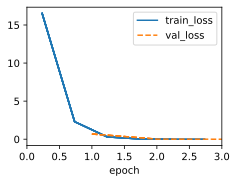

In [ ]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Below, we
[**compare the model parameters learned
by training on finite data
and the actual parameters**]
that generated our dataset.
To access parameters,
we access the weights and bias
of the layer that we need.
As in our implementation from scratch,
note that our estimated parameters
are close to their true counterparts.


In [ ]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

In [ ]:
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0094, -0.0030])
error in estimating b: tensor([0.0137])


## Summary

This section contains the first
implementation of a deep network (in this book)
to tap into the conveniences afforded
by modern deep learning frameworks,
such as MXNet :cite:`Chen.Li.Li.ea.2015`,
JAX :cite:`Frostig.Johnson.Leary.2018`,
PyTorch :cite:`Paszke.Gross.Massa.ea.2019`,
and Tensorflow :cite:`Abadi.Barham.Chen.ea.2016`.
We used framework defaults for loading data, defining a layer,
a loss function, an optimizer and a training loop.
Whenever the framework provides all necessary features,
it is generally a good idea to use them,
since the library implementations of these components
tend to be heavily optimized for performance
and properly tested for reliability.
At the same time, try not to forget
that these modules *can* be implemented directly.
This is especially important for aspiring researchers
who wish to live on the leading edge of model development,
where you will be inventing new components
that cannot possibly exist in any current library.


In PyTorch, the `data` module provides tools for data processing,
the `nn` module defines a large number of neural network layers and common loss functions.
We can initialize the parameters by replacing their values
with methods ending with `_`.
Note that we need to specify the input dimensions of the network.
While this is trivial for now, it can have significant knock-on effects
when we want to design complex networks with many layers.
Careful considerations of how to parametrize these networks
is needed to allow portability.


## Exercises

1. How would you need to change the learning rate if you replace the aggregate loss over the minibatch
   with an average over the loss on the minibatch?
1. Review the framework documentation to see which loss functions are provided. In particular,
   replace the squared loss with Huber's robust loss function. That is, use the loss function
   $$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \textrm{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \textrm{ otherwise}\end{cases}$$
1. How do you access the gradient of the weights of the model?
1. What is the effect on the solution if you change the learning rate and the number of epochs? Does it keep on improving?
1. How does the solution change as you vary the amount of data generated?
    1. Plot the estimation error for $\hat{\mathbf{w}} - \mathbf{w}$ and $\hat{b} - b$ as a function of the amount of data. Hint: increase the amount of data logarithmically rather than linearly, i.e., 5, 10, 20, 50, ..., 10,000 rather than 1000, 2000, ..., 10,000.
    2. Why is the suggestion in the hint appropriate?


[Discussions](https://discuss.d2l.ai/t/45)


# Generalization
:label:`sec_generalization_basics`

Consider two college students diligently
preparing for their final exam.
Commonly, this preparation will consist
of practicing and testing their abilities
by taking exams administered in previous years.
Nonetheless, doing well on past exams is no guarantee
that they will excel when it matters.
For instance, imagine a student, Extraordinary Ellie,
whose preparation consisted entirely
of memorizing the answers
to previous years' exam questions.
Even if Ellie were endowed
with an extraordinary memory,
and thus could perfectly recall the answer
to any *previously seen* question,
she might nevertheless freeze
when faced with a new (*previously unseen*) question.
By comparison, imagine another student,
Inductive Irene, with comparably poor
memorization skills,
but a knack for picking up patterns.
Note that if the exam truly consisted of
recycled questions from a previous year,
Ellie would handily outperform Irene.
Even if Irene's inferred patterns
yielded 90% accurate predictions,
they could never compete with
Ellie's 100% recall.
However, even if the exam consisted
entirely of fresh questions,
Irene might maintain her 90% average.

As machine learning scientists,
our goal is to discover *patterns*.
But how can we be sure that we have
truly discovered a *general* pattern
and not simply memorized our data?
Most of the time, our predictions are only useful
if our model discovers such a pattern.
We do not want to predict yesterday's stock prices, but tomorrow's.
We do not need to recognize
already diagnosed diseases
for previously seen patients,
but rather previously undiagnosed
ailments in previously unseen patients.
This problem---how to discover patterns that *generalize*---is
the fundamental problem of machine learning,
and arguably of all of statistics.
We might cast this problem as just one slice
of a far grander question
that engulfs all of science:
when are we ever justified
in making the leap from particular observations
to more general statements?


In real life, we must fit our models
using a finite collection of data.
The typical scales of that data
vary wildly across domains.
For many important medical problems,
we can only access a few thousand data points.
When studying rare diseases,
we might be lucky to access hundreds.
By contrast, the largest public datasets
consisting of labeled photographs,
e.g., ImageNet :cite:`Deng.Dong.Socher.ea.2009`,
contain millions of images.
And some unlabeled image collections
such as the Flickr YFC100M dataset
can be even larger, containing
over 100 million images :cite:`thomee2016yfcc100m`.
However, even at this extreme scale,
the number of available data points
remains infinitesimally small
compared to the space of all possible images
at a megapixel resolution.
Whenever we work with finite samples,
we must keep in mind the risk
that we might fit our training data,
only to discover that we failed
to discover a generalizable pattern.

The phenomenon of fitting closer to our training data
than to the underlying distribution is called *overfitting*,
and techniques for combatting overfitting
are often called *regularization* methods.
While it is no substitute for a proper introduction
to statistical learning theory (see :citet:`Vapnik98,boucheron2005theory`),
we will give you just enough intuition to get going.
We will revisit generalization in many chapters
throughout the book,
exploring both what is known about
the principles underlying generalization
in various models,
and also heuristic techniques
that have been found (empirically)
to yield improved generalization
on tasks of practical interest.



## Training Error and Generalization Error


In the standard supervised learning setting,
we assume that the training data and the test data
are drawn *independently* from *identical* distributions.
This is commonly called the *IID assumption*.
While this assumption is strong,
it is worth noting that, absent any such assumption,
we would be dead in the water.
Why should we believe that training data
sampled from distribution $P(X,Y)$
should tell us how to make predictions on
test data generated by a *different distribution* $Q(X,Y)$?
Making such leaps turns out to require
strong assumptions about how $P$ and $Q$ are related.
Later on we will discuss some assumptions
that allow for shifts in distribution
but first we need to understand the IID case,
where $P(\cdot) = Q(\cdot)$.

To begin with, we need to differentiate between
the *training error* $R_\textrm{emp}$,
which is a *statistic*
calculated on the training dataset,
and the *generalization error* $R$,
which is an *expectation* taken
with respect to the underlying distribution.
You can think of the generalization error as
what you would see  if you applied your model
to an infinite stream of additional data examples
drawn from the same underlying data distribution.
Formally the training error is expressed as a *sum* (with the same notation as :numref:`sec_linear_regression`):

$$R_\textrm{emp}[\mathbf{X}, \mathbf{y}, f] = \frac{1}{n} \sum_{i=1}^n l(\mathbf{x}^{(i)}, y^{(i)}, f(\mathbf{x}^{(i)})),$$


while the generalization error is expressed as an integral:

$$R[p, f] = E_{(\mathbf{x}, y) \sim P} [l(\mathbf{x}, y, f(\mathbf{x}))] =
\int \int l(\mathbf{x}, y, f(\mathbf{x})) p(\mathbf{x}, y) \;d\mathbf{x} dy.$$

Problematically, we can never calculate
the generalization error $R$ exactly.
Nobody ever tells us the precise form
of the density function $p(\mathbf{x}, y)$.
Moreover, we cannot sample an infinite stream of data points.
Thus, in practice, we must *estimate* the generalization error
by applying our model to an independent test set
constituted of a random selection of examples
$\mathbf{X}'$ and labels $\mathbf{y}'$
that were withheld from our training set.
This consists of applying the same formula
that was used for calculating the empirical training error
but to a test set $\mathbf{X}', \mathbf{y}'$.


Crucially, when we evaluate our classifier on the test set,
we are working with a *fixed* classifier
(it does not depend on the sample of the test set),
and thus estimating its error
is simply the problem of mean estimation.
However the same cannot be said
for the training set.
Note that the model we wind up with
depends explicitly on the selection of the training set
and thus the training error will in general
be a biased estimate of the true error
on the underlying population.
The central question of generalization
is then when should we expect our training error
to be close to the population error
(and thus the generalization error).

### Model Complexity

In classical theory, when we have
simple models and abundant data,
the training and generalization errors tend to be close.
However, when we work with
more complex models and/or fewer examples,
we expect the training error to go down
but the generalization gap to grow.
This should not be surprising.
Imagine a model class so expressive that
for any dataset of $n$ examples,
we can find a set of parameters
that can perfectly fit arbitrary labels,
even if randomly assigned.
In this case, even if we fit our training data perfectly,
how can we conclude anything about the generalization error?
For all we know, our generalization error
might be no better than random guessing.

In general, absent any restriction on our model class,
we cannot conclude, based on fitting the training data alone,
that our model has discovered any generalizable pattern :cite:`vapnik1994measuring`.
On the other hand, if our model class
was not capable of fitting arbitrary labels,
then it must have discovered a pattern.
Learning-theoretic ideas about model complexity
derived some inspiration from the ideas
of Karl Popper, an influential philosopher of science,
who formalized the criterion of falsifiability.
According to Popper, a theory
that can explain any and all observations
is not a scientific theory at all!
After all, what has it told us about the world
if it has not ruled out any possibility?
In short, what we want is a hypothesis
that *could not* explain any observations
we might conceivably make
and yet nevertheless happens to be compatible
with those observations that we *in fact* make.

Now what precisely constitutes an appropriate
notion of model complexity is a complex matter.
Often, models with more parameters
are able to fit a greater number
of arbitrarily assigned labels.
However, this is not necessarily true.
For instance, kernel methods operate in spaces
with infinite numbers of parameters,
yet their complexity is controlled
by other means :cite:`Scholkopf.Smola.2002`.
One notion of complexity that often proves useful
is the range of values that the parameters can take.
Here, a model whose parameters are permitted
to take arbitrary values
would be more complex.
We will revisit this idea in the next section,
when we introduce *weight decay*,
your first practical regularization technique.
Notably, it can be difficult to compare
complexity among members of substantially different model classes
(say, decision trees vs. neural networks).


At this point, we must stress another important point
that we will revisit when introducing deep neural networks.
When a model is capable of fitting arbitrary labels,
low training error does not necessarily
imply low generalization error.
*However, it does not necessarily
imply high generalization error either!*
All we can say with confidence is that
low training error alone is not enough
to certify low generalization error.
Deep neural networks turn out to be just such models:
while they generalize well in practice,
they are too powerful to allow us to conclude
much on the basis of training error alone.
In these cases we must rely more heavily
on our holdout data to certify generalization
after the fact.
Error on the holdout data, i.e., validation set,
is called the *validation error*.

## Underfitting or Overfitting?

When we compare the training and validation errors,
we want to be mindful of two common situations.
First, we want to watch out for cases
when our training error and validation error are both substantial
but there is a little gap between them.
If the model is unable to reduce the training error,
that could mean that our model is too simple
(i.e., insufficiently expressive)
to capture the pattern that we are trying to model.
Moreover, since the *generalization gap* ($R_\textrm{emp} - R$)
between our training and generalization errors is small,
we have reason to believe that we could get away with a more complex model.
This phenomenon is known as *underfitting*.

On the other hand, as we discussed above,
we want to watch out for the cases
when our training error is significantly lower
than our validation error, indicating severe *overfitting*.
Note that overfitting is not always a bad thing.
In deep learning especially,
the best predictive models often perform
far better on training data than on holdout data.
Ultimately, we usually care about
driving the generalization error lower,
and only care about the gap insofar
as it becomes an obstacle to that end.
Note that if the training error is zero,
then the generalization gap is precisely equal to the generalization error
and we can make progress only by reducing the gap.

### Polynomial Curve Fitting
:label:`subsec_polynomial-curve-fitting`

To illustrate some classical intuition
about overfitting and model complexity,
consider the following:
given training data consisting of a single feature $x$
and a corresponding real-valued label $y$,
we try to find the polynomial of degree $d$

$$\hat{y}= \sum_{i=0}^d x^i w_i$$

for estimating the label $y$.
This is just a linear regression problem
where our features are given by the powers of $x$,
the model's weights are given by $w_i$,
and the bias is given by $w_0$ since $x^0 = 1$ for all $x$.
Since this is just a linear regression problem,
we can use the squared error as our loss function.


A higher-order polynomial function is more complex
than a lower-order polynomial function,
since the higher-order polynomial has more parameters
and the model function's selection range is wider.
Fixing the training dataset,
higher-order polynomial functions should always
achieve lower (at worst, equal) training error
relative to lower-degree polynomials.
In fact, whenever each data example
has a distinct value of $x$,
a polynomial function with degree
equal to the number of data examples
can fit the training set perfectly.
We compare the relationship between polynomial degree (model complexity)
and both underfitting and overfitting in :numref:`fig_capacity_vs_error`.

![Influence of model complexity on underfitting and overfitting.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/capacity-vs-error.svg?raw=1)
:label:`fig_capacity_vs_error`


### Dataset Size

As the above bound already indicates,
another big consideration
to bear in mind is dataset size.
Fixing our model, the fewer samples
we have in the training dataset,
the more likely (and more severely)
we are to encounter overfitting.
As we increase the amount of training data,
the generalization error typically decreases.
Moreover, in general, more data never hurts.
For a fixed task and data distribution,
model complexity should not increase
more rapidly than the amount of data.
Given more data, we might  attempt
to fit a more complex model.
Absent sufficient data, simpler models
may be more difficult to beat.
For many tasks, deep learning
only outperforms linear models
when many thousands of training examples are available.
In part, the current success of deep learning
owes considerably to the abundance of massive datasets
arising from Internet companies, cheap storage,
connected devices, and the broad digitization of the economy.

## Model Selection
:label:`subsec_generalization-model-selection`

Typically, we select our final model
only after evaluating multiple models
that differ in various ways
(different architectures, training objectives,
selected features, data preprocessing,
learning rates, etc.).
Choosing among many models is aptly
called *model selection*.

In principle, we should not touch our test set
until after we have chosen all our hyperparameters.
Were we to use the test data in the model selection process,
there is a risk that we might overfit the test data.
Then we would be in serious trouble.
If we overfit our training data,
there is always the evaluation on test data to keep us honest.
But if we overfit the test data, how would we ever know?
See :citet:`ong2005learning` for an example of how
this can lead to absurd results even for models where the complexity
can be tightly controlled.

Thus, we should never rely on the test data for model selection.
And yet we cannot rely solely on the training data
for model selection either because
we cannot estimate the generalization error
on the very data that we use to train the model.


In practical applications, the picture gets muddier.
While ideally we would only touch the test data once,
to assess the very best model or to compare
a small number of models with each other,
real-world test data is seldom discarded after just one use.
We can seldom afford a new test set for each round of experiments.
In fact, recycling benchmark data for decades
can have a significant impact on the
development of algorithms,
e.g., for [image classification](https://paperswithcode.com/sota/image-classification-on-imagenet)
and [optical character recognition](https://paperswithcode.com/sota/image-classification-on-mnist).

The common practice for addressing the problem of *training on the test set*
is to split our data three ways,
incorporating a *validation set*
in addition to the training and test datasets.
The result is a murky business where the boundaries
between validation and test data are worryingly ambiguous.
Unless explicitly stated otherwise, in the experiments in this book
we are really working with what should rightly be called
training data and validation data, with no true test sets.
Therefore, the accuracy reported in each experiment of the book is really
the validation accuracy and not a true test set accuracy.

### Cross-Validation

When training data is scarce,
we might not even be able to afford to hold out
enough data to constitute a proper validation set.
One popular solution to this problem is to employ
$K$*-fold cross-validation*.
Here, the original training data is split into $K$ non-overlapping subsets.
Then model training and validation are executed $K$ times,
each time training on $K-1$ subsets and validating
on a different subset (the one not used for training in that round).
Finally, the training and validation errors are estimated
by averaging over the results from the $K$ experiments.



## Summary

This section explored some of the  underpinnings
of generalization in  machine learning.
Some of these ideas become complicated
and counterintuitive when we get to deeper models; here, models are capable of overfitting data badly,
and the relevant notions of complexity
can be both implicit and counterintuitive
(e.g., larger architectures with more parameters
generalizing better).
We leave you with a few rules of thumb:

1. Use validation sets (or $K$*-fold cross-validation*) for model selection;
1. More complex models often require more data;
1. Relevant notions of complexity include both the number of parameters and the range of values that they are allowed to take;
1. Keeping all else equal, more data almost always leads to better generalization;
1. This entire talk of generalization is all predicated on the IID assumption. If we relax this assumption, allowing for distributions to shift between the train and testing periods, then we cannot say anything about generalization absent a further (perhaps milder) assumption.


## Exercises

1. When can you solve the problem of polynomial regression exactly?
1. Give at least five examples where dependent random variables make treating the problem as IID data inadvisable.
1. Can you ever expect to see zero training error? Under which circumstances would you see zero generalization error?
1. Why is $K$-fold cross-validation very expensive to compute?
1. Why is the $K$-fold cross-validation error estimate biased?
1. The VC dimension is defined as the maximum number of points that can be classified with arbitrary labels $\{\pm 1\}$ by a function of a class of functions. Why might this not be a good idea for measuring how complex the class of functions is? Hint: consider the magnitude of the functions.
1. Your manager gives you a difficult dataset on which your current algorithm does not perform so well. How would you justify to him that you need more data? Hint: you cannot increase the data but you can decrease it.


[Discussions](https://discuss.d2l.ai/t/97)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Weight Decay
:label:`sec_weight_decay`

Now that we have characterized the problem of overfitting,
we can introduce our first *regularization* technique.
Recall that we can always mitigate overfitting
by collecting more training data.
However, that can be costly, time consuming,
or entirely out of our control,
making it impossible in the short run.
For now, we can assume that we already have
as much high-quality data as our resources permit
and focus the tools at our disposal
when the dataset is taken as a given.

Recall that in our polynomial regression example
(:numref:`subsec_polynomial-curve-fitting`)
we could limit our model's capacity
by tweaking the degree
of the fitted polynomial.
Indeed, limiting the number of features
is a popular technique for mitigating overfitting.
However, simply tossing aside features
can be too blunt an instrument.
Sticking with the polynomial regression
example, consider what might happen
with high-dimensional input.
The natural extensions of polynomials
to multivariate data are called *monomials*,
which are simply products of powers of variables.
The degree of a monomial is the sum of the powers.
For example, $x_1^2 x_2$, and $x_3 x_5^2$
are both monomials of degree 3.

Note that the number of terms with degree $d$
blows up rapidly as $d$ grows larger.
Given $k$ variables, the number of monomials
of degree $d$ is ${k - 1 + d} \choose {k - 1}$.
Even small changes in degree, say from $2$ to $3$,
dramatically increase the complexity of our model.
Thus we often need a more fine-grained tool
for adjusting function complexity.


In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

## Norms and Weight Decay

(**Rather than directly manipulating the number of parameters,
*weight decay*, operates by restricting the values
that the parameters can take.**)
More commonly called $\ell_2$ regularization
outside of deep learning circles
when optimized by minibatch stochastic gradient descent,
weight decay might be the most widely used technique
for regularizing parametric machine learning models.
The technique is motivated by the basic intuition
that among all functions $f$,
the function $f = 0$
(assigning the value $0$ to all inputs)
is in some sense the *simplest*,
and that we can measure the complexity
of a function by the distance of its parameters from zero.
But how precisely should we measure
the distance between a function and zero?
There is no single right answer.
In fact, entire branches of mathematics,
including parts of functional analysis
and the theory of Banach spaces,
are devoted to addressing such issues.

One simple interpretation might be
to measure the complexity of a linear function
$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$
by some norm of its weight vector, e.g., $\| \mathbf{w} \|^2$.
Recall that we introduced the $\ell_2$ norm and $\ell_1$ norm,
which are special cases of the more general $\ell_p$ norm,
in :numref:`subsec_lin-algebra-norms`.
The most common method for ensuring a small weight vector
is to add its norm as a penalty term
to the problem of minimizing the loss.
Thus we replace our original objective,
*minimizing the prediction loss on the training labels*,
with new objective,
*minimizing the sum of the prediction loss and the penalty term*.
Now, if our weight vector grows too large,
our learning algorithm might focus
on minimizing the weight norm $\| \mathbf{w} \|^2$
rather than minimizing the training error.
That is exactly what we want.
To illustrate things in code,
we revive our previous example
from :numref:`sec_linear_regression` for linear regression.
There, our loss was given by

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Recall that $\mathbf{x}^{(i)}$ are the features,
$y^{(i)}$ is the label for any data example $i$, and $(\mathbf{w}, b)$
are the weight and bias parameters, respectively.
To penalize the size of the weight vector,
we must somehow add $\| \mathbf{w} \|^2$ to the loss function,
but how should the model trade off the
standard loss for this new additive penalty?
In practice, we characterize this trade-off
via the *regularization constant* $\lambda$,
a nonnegative hyperparameter
that we fit using validation data:

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2.$$


For $\lambda = 0$, we recover our original loss function.
For $\lambda > 0$, we restrict the size of $\| \mathbf{w} \|$.
We divide by $2$ by convention:
when we take the derivative of a quadratic function,
the $2$ and $1/2$ cancel out, ensuring that the expression
for the update looks nice and simple.
The astute reader might wonder why we work with the squared
norm and not the standard norm (i.e., the Euclidean distance).
We do this for computational convenience.
By squaring the $\ell_2$ norm, we remove the square root,
leaving the sum of squares of
each component of the weight vector.
This makes the derivative of the penalty easy to compute:
the sum of derivatives equals the derivative of the sum.


Moreover, you might ask why we work with the $\ell_2$ norm
in the first place and not, say, the $\ell_1$ norm.
In fact, other choices are valid and
popular throughout statistics.
While $\ell_2$-regularized linear models constitute
the classic *ridge regression* algorithm,
$\ell_1$-regularized linear regression
is a similarly fundamental method in statistics,
popularly known as *lasso regression*.
One reason to work with the $\ell_2$ norm
is that it places an outsize penalty
on large components of the weight vector.
This biases our learning algorithm
towards models that distribute weight evenly
across a larger number of features.
In practice, this might make them more robust
to measurement error in a single variable.
By contrast, $\ell_1$ penalties lead to models
that concentrate weights on a small set of features
by clearing the other weights to zero.
This gives us an effective method for *feature selection*,
which may be desirable for other reasons.
For example, if our model only relies on a few features,
then we may not need to collect, store, or transmit data
for the other (dropped) features.

Using the same notation in :eqref:`eq_linreg_batch_update`,
minibatch stochastic gradient descent updates
for $\ell_2$-regularized regression as follows:

$$\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}$$

As before, we update $\mathbf{w}$ based on the amount
by which our estimate differs from the observation.
However, we also shrink the size of $\mathbf{w}$ towards zero.
That is why the method is sometimes called "weight decay":
given the penalty term alone,
our optimization algorithm *decays*
the weight at each step of training.
In contrast to feature selection,
weight decay offers us a mechanism for continuously adjusting the complexity of a function.
Smaller values of $\lambda$ correspond
to less constrained $\mathbf{w}$,
whereas larger values of $\lambda$
constrain $\mathbf{w}$ more considerably.
Whether we include a corresponding bias penalty $b^2$
can vary across implementations,
and may vary across layers of a neural network.
Often, we do not regularize the bias term.
Besides,
although $\ell_2$ regularization may not be equivalent to weight decay for other optimization algorithms,
the idea of regularization through
shrinking the size of weights
still holds true.

## High-Dimensional Linear Regression

We can illustrate the benefits of weight decay
through a simple synthetic example.

First, we [**generate some data as before**]:

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \textrm{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

In this synthetic dataset, our label is given
by an underlying linear function of our inputs,
corrupted by Gaussian noise
with zero mean and standard deviation 0.01.
For illustrative purposes,
we can make the effects of overfitting pronounced,
by increasing the dimensionality of our problem to $d = 200$
and working with a small training set with only 20 examples.


In [ ]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

## Implementation from Scratch

Now, let's try implementing weight decay from scratch.
Since minibatch stochastic gradient descent
is our optimizer,
we just need to add the squared $\ell_2$ penalty
to the original loss function.

### (**Defining $\ell_2$ Norm Penalty**)

Perhaps the most convenient way of implementing this penalty
is to square all terms in place and sum them.


In [ ]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

### Defining the Model

In the final model,
the linear regression and the squared loss have not changed since :numref:`sec_linear_scratch`,
so we will just define a subclass of `d2l.LinearRegressionScratch`. The only change here is that our loss now includes the penalty term.


In [ ]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

The following code fits our model on the training set with 20 examples and evaluates it on the validation set with 100 examples.


In [ ]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

### [**Training without Regularization**]

We now run this code with `lambd = 0`,
disabling weight decay.
Note that we overfit badly,
decreasing the training error but not the
validation error---a textbook case of overfitting.


L2 norm of w: 0.009948714636266232


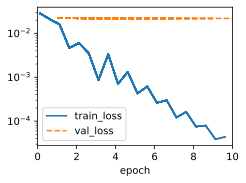

In [ ]:
train_scratch(0)

### [**Using Weight Decay**]

Below, we run with substantial weight decay.
Note that the training error increases
but the validation error decreases.
This is precisely the effect
we expect from regularization.


L2 norm of w: 0.0017270983662456274


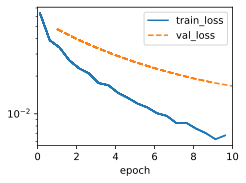

In [ ]:
train_scratch(3)

## [**Concise Implementation**]

Because weight decay is ubiquitous
in neural network optimization,
the deep learning framework makes it especially convenient,
integrating weight decay into the optimization algorithm itself
for easy use in combination with any loss function.
Moreover, this integration serves a computational benefit,
allowing implementation tricks to add weight decay to the algorithm,
without any additional computational overhead.
Since the weight decay portion of the update
depends only on the current value of each parameter,
the optimizer must touch each parameter once anyway.


Below, we specify
the weight decay hyperparameter directly
through `weight_decay` when instantiating our optimizer.
By default, PyTorch decays both
weights and biases simultaneously, but
we can configure the optimizer to handle different parameters
according to different policies.
Here, we only set `weight_decay` for
the weights (the `net.weight` parameters), hence the
bias (the `net.bias` parameter) will not decay.


In [ ]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

[**The plot looks similar to that when
we implemented weight decay from scratch**].
However, this version runs faster
and is easier to implement,
benefits that will become more
pronounced as you address larger problems
and this work becomes more routine.


L2 norm of w: 0.013779522851109505


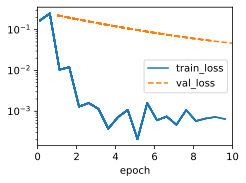

In [ ]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

So far, we have touched upon one notion of
what constitutes a simple linear function.
However, even for simple nonlinear functions, the situation can be much more complex. To see this, the concept of [reproducing kernel Hilbert space (RKHS)](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
allows one to apply tools introduced
for linear functions in a nonlinear context.
Unfortunately, RKHS-based algorithms
tend to scale poorly to large, high-dimensional data.
In this book we will often adopt the common heuristic
whereby weight decay is applied
to all layers of a deep network.

## Summary

Regularization is a common method for dealing with overfitting. Classical regularization techniques add a penalty term to the loss function (when training) to reduce the complexity of the learned model.
One particular choice for keeping the model simple is using an $\ell_2$ penalty. This leads to weight decay in the update steps of the minibatch stochastic gradient descent algorithm.
In practice, the weight decay functionality is provided in optimizers from deep learning frameworks.
Different sets of parameters can have different update behaviors within the same training loop.



## Exercises

1. Experiment with the value of $\lambda$ in the estimation problem in this section. Plot training and validation accuracy as a function of $\lambda$. What do you observe?
1. Use a validation set to find the optimal value of $\lambda$. Is it really the optimal value? Does this matter?
1. What would the update equations look like if instead of $\|\mathbf{w}\|^2$ we used $\sum_i |w_i|$ as our penalty of choice ($\ell_1$ regularization)?
1. We know that $\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$. Can you find a similar equation for matrices (see the Frobenius norm in :numref:`subsec_lin-algebra-norms`)?
1. Review the relationship between training error and generalization error. In addition to weight decay, increased training, and the use of a model of suitable complexity, what other ways might help us deal with overfitting?
1. In Bayesian statistics we use the product of prior and likelihood to arrive at a posterior via $P(w \mid x) \propto P(x \mid w) P(w)$. How can you identify $P(w)$ with regularization?


[Discussions](https://discuss.d2l.ai/t/99)


# Softmax Regression
:label:`sec_softmax`

In :numref:`sec_linear_regression`, we introduced linear regression,
working through implementations from scratch in :numref:`sec_linear_scratch`
and again using high-level APIs of a deep learning framework
in :numref:`sec_linear_concise` to do the heavy lifting.

Regression is the hammer we reach for when
we want to answer *how much?* or *how many?* questions.
If you want to predict the number of dollars (price)
at which a house will be sold,
or the number of wins a baseball team might have,
or the number of days that a patient
will remain hospitalized before being discharged,
then you are probably looking for a regression model.
However, even within regression models,
there are important distinctions.
For instance, the price of a house
will never be negative and changes might often be *relative* to its baseline price.
As such, it might be more effective to regress
on the logarithm of the price.
Likewise, the number of days a patient spends in hospital
is a *discrete nonnegative* random variable.
As such, least mean squares might not be an ideal approach either.
This sort of time-to-event modeling
comes with a host of other complications that are dealt with
in a specialized subfield called *survival modeling*.

The point here is not to overwhelm you but just
to let you know that there is a lot more to estimation
than simply minimizing squared errors.
And more broadly, there is a lot more to supervised learning than regression.
In this section, we focus on *classification* problems
where we put aside *how much?* questions
and instead focus on *which category?* questions.



* Does this email belong in the spam folder or the inbox?
* Is this customer more likely to sign up
  or not to sign up for a subscription service?
* Does this image depict a donkey, a dog, a cat, or a rooster?
* Which movie is Aston most likely to watch next?
* Which section of the book are you going to read next?

Colloquially, machine learning practitioners
overload the word *classification*
to describe two subtly different problems:
(i) those where we are interested only in
hard assignments of examples to categories (classes);
and (ii) those where we wish to make soft assignments,
i.e., to assess the probability that each category applies.
The distinction tends to get blurred, in part,
because often, even when we only care about hard assignments,
we still use models that make soft assignments.

Even more, there are cases where more than one label might be true.
For instance, a news article might simultaneously cover
the topics of entertainment, business, and space flight,
but not the topics of medicine or sports.
Thus, categorizing it into one of the above categories
on their own would not be very useful.
This problem is commonly known as [multi-label classification](https://en.wikipedia.org/wiki/Multi-label_classification).
See :citet:`Tsoumakas.Katakis.2007` for an overview
and :citet:`Huang.Xu.Yu.2015`
for an effective algorithm when tagging images.

## Classification
:label:`subsec_classification-problem`

To get our feet wet, let's start with
a simple image classification problem.
Here, each input consists of a $2\times2$ grayscale image.
We can represent each pixel value with a single scalar,
giving us four features $x_1, x_2, x_3, x_4$.
Further, let's assume that each image belongs to one
among the categories "cat", "chicken", and "dog".

Next, we have to choose how to represent the labels.
We have two obvious choices.
Perhaps the most natural impulse would be
to choose $y \in \{1, 2, 3\}$,
where the integers represent
$\{\textrm{dog}, \textrm{cat}, \textrm{chicken}\}$ respectively.
This is a great way of *storing* such information on a computer.
If the categories had some natural ordering among them,
say if we were trying to predict
$\{\textrm{baby}, \textrm{toddler}, \textrm{adolescent}, \textrm{young adult}, \textrm{adult}, \textrm{geriatric}\}$,
then it might even make sense to cast this as
an [ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) problem
and keep the labels in this format.
See :citet:`Moon.Smola.Chang.ea.2010` for an overview
of different types of ranking loss functions
and :citet:`Beutel.Murray.Faloutsos.ea.2014` for a Bayesian approach
that addresses responses with more than one mode.

In general, classification problems do not come
with natural orderings among the classes.
Fortunately, statisticians long ago invented a simple way
to represent categorical data: the *one-hot encoding*.
A one-hot encoding is a vector
with as many components as we have categories.
The component corresponding to a particular instance's category is set to 1
and all other components are set to 0.
In our case, a label $y$ would be a three-dimensional vector,
with $(1, 0, 0)$ corresponding to "cat", $(0, 1, 0)$ to "chicken",
and $(0, 0, 1)$ to "dog":

$$y \in \{(1, 0, 0), (0, 1, 0), (0, 0, 1)\}.$$

### Linear Model

In order to estimate the conditional probabilities
associated with all the possible classes,
we need a model with multiple outputs, one per class.
To address classification with linear models,
we will need as many affine functions as we have outputs.
Strictly speaking, we only need one fewer,
since the final category has to be the difference
between $1$ and the sum of the other categories,
but for reasons of symmetry
we use a slightly redundant parametrization.
Each output corresponds to its own affine function.
In our case, since we have 4 features and 3 possible output categories,
we need 12 scalars to represent the weights ($w$ with subscripts),
and 3 scalars to represent the biases ($b$ with subscripts). This yields:

$$
\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}
$$

The corresponding neural network diagram
is shown in :numref:`fig_softmaxreg`.
Just as in linear regression,
we use a single-layer neural network.
And since the calculation of each output, $o_1, o_2$, and $o_3$,
depends on every input, $x_1$, $x_2$, $x_3$, and $x_4$,
the output layer can also be described as a *fully connected layer*.

![Softmax regression is a single-layer neural network.](http://d2l.ai/_images/softmaxreg.svg)
:label:`fig_softmaxreg`

For a more concise notation we use vectors and matrices:
$\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$ is
much better suited for mathematics and code.
Note that we have gathered all of our weights into a $3 \times 4$ matrix and all biases
$\mathbf{b} \in \mathbb{R}^3$ in a vector.

### The Softmax
:label:`subsec_softmax_operation`

Assuming a suitable loss function,
we could try, directly, to minimize the difference
between $\mathbf{o}$ and the labels $\mathbf{y}$.
While it turns out that treating classification
as a vector-valued regression problem works surprisingly well,
it is nonetheless unsatisfactory in the following ways:

* There is no guarantee that the outputs $o_i$ sum up to $1$ in the way we expect probabilities to behave.
* There is no guarantee that the outputs $o_i$ are even nonnegative, even if their outputs sum up to $1$, or that they do not exceed $1$.

Both aspects render the estimation problem difficult to solve
and the solution very brittle to outliers.
For instance, if we assume that there
is a positive linear dependency
between the number of bedrooms and the likelihood
that someone will buy a house,
the probability might exceed $1$
when it comes to buying a mansion!
As such, we need a mechanism to "squish" the outputs.

There are many ways we might accomplish this goal.
For instance, we could assume that the outputs
$\mathbf{o}$ are corrupted versions of $\mathbf{y}$,
where the corruption occurs by means of adding noise $\boldsymbol{\epsilon}$
drawn from a normal distribution.
In other words, $\mathbf{y} = \mathbf{o} + \boldsymbol{\epsilon}$,
where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$.
This is the so-called [probit model](https://en.wikipedia.org/wiki/Probit_model),
first introduced by :citet:`Fechner.1860`.
While appealing, it does not work quite as well
nor lead to a particularly nice optimization problem,
when compared to the softmax.

Another way to accomplish this goal
(and to ensure nonnegativity) is to use
an exponential function $P(y = i) \propto \exp o_i$.
This does indeed satisfy the requirement
that the conditional class probability
increases with increasing $o_i$, it is monotonic,
and all probabilities are nonnegative.
We can then transform these values so that they add up to $1$
by dividing each by their sum.
This process is called *normalization*.
Putting these two pieces together
gives us the *softmax* function:

$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o}) \quad \textrm{where}\quad \hat{y}_i = \frac{\exp(o_i)}{\sum_j \exp(o_j)}.$$
:eqlabel:`eq_softmax_y_and_o`

Note that the largest coordinate of $\mathbf{o}$
corresponds to the most likely class according to $\hat{\mathbf{y}}$.
Moreover, because the softmax operation
preserves the ordering among its arguments,
we do not need to compute the softmax
to determine which class has been assigned the highest probability. Thus,

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$


The idea of a softmax dates back to :citet:`Gibbs.1902`,
who adapted ideas from physics.
Dating even further back, Boltzmann,
the father of modern statistical physics,
used this trick to model a distribution
over energy states in gas molecules.
In particular, he discovered that the prevalence
of a state of energy in a thermodynamic ensemble,
such as the molecules in a gas,
is proportional to $\exp(-E/kT)$.
Here, $E$ is the energy of a state,
$T$ is the temperature, and $k$ is the Boltzmann constant.
When statisticians talk about increasing or decreasing
the "temperature" of a statistical system,
they refer to changing $T$
in order to favor lower or higher energy states.
Following Gibbs' idea, energy equates to error.
Energy-based models :cite:`Ranzato.Boureau.Chopra.ea.2007`
use this point of view when describing
problems in deep learning.

### Vectorization
:label:`subsec_softmax_vectorization`

To improve computational efficiency,
we vectorize calculations in minibatches of data.
Assume that we are given a minibatch $\mathbf{X} \in \mathbb{R}^{n \times d}$
of $n$ examples with dimensionality (number of inputs) $d$.
Moreover, assume that we have $q$ categories in the output.
Then the weights satisfy $\mathbf{W} \in \mathbb{R}^{d \times q}$
and the bias satisfies $\mathbf{b} \in \mathbb{R}^{1\times q}$.

$$ \begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned} $$
:eqlabel:`eq_minibatch_softmax_reg`

This accelerates the dominant operation into
a matrix--matrix product $\mathbf{X} \mathbf{W}$.
Moreover, since each row in $\mathbf{X}$ represents a data example,
the softmax operation itself can be computed *rowwise*:
for each row of $\mathbf{O}$, exponentiate all entries
and then normalize them by the sum.
Note, though, that care must be taken
to avoid exponentiating and taking logarithms of large numbers,
since this can cause numerical overflow or underflow.
Deep learning frameworks take care of this automatically.

## Loss Function
:label:`subsec_softmax-regression-loss-func`

Now that we have a mapping from features $\mathbf{x}$
to probabilities $\mathbf{\hat{y}}$,
we need a way to optimize the accuracy of this mapping.
We will rely on maximum likelihood estimation,
the very same method that we encountered
when providing a probabilistic justification
for the mean squared error loss in
:numref:`subsec_normal_distribution_and_squared_loss`.

### Log-Likelihood

The softmax function gives us a vector $\hat{\mathbf{y}}$,
which we can interpret as the (estimated) conditional probabilities
of each class, given any input $\mathbf{x}$,
such as $\hat{y}_1$ = $P(y=\textrm{cat} \mid \mathbf{x})$.
In the following we assume that for a dataset
with features $\mathbf{X}$ the labels $\mathbf{Y}$
are represented using a one-hot encoding label vector.
We can compare the estimates with reality
by checking how probable the actual classes are
according to our model, given the features:

$$
P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)}).
$$

We are allowed to use the factorization
since we assume that each label is drawn independently
from its respective distribution $P(\mathbf{y}\mid\mathbf{x}^{(i)})$.
Since maximizing the product of terms is awkward,
we take the negative logarithm to obtain the equivalent problem
of minimizing the negative log-likelihood:

$$
-\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
= \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)}),
$$

where for any pair of label $\mathbf{y}$
and model prediction $\hat{\mathbf{y}}$
over $q$ classes, the loss function $l$ is

$$ l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j. $$
:eqlabel:`eq_l_cross_entropy`

For reasons explained later on,
the loss function in :eqref:`eq_l_cross_entropy`
is commonly called the *cross-entropy loss*.
Since $\mathbf{y}$ is a one-hot vector of length $q$,
the sum over all its coordinates $j$ vanishes for all but one term.
Note that the loss $l(\mathbf{y}, \hat{\mathbf{y}})$
is bounded from below by $0$
whenever $\hat{\mathbf{y}}$ is a probability vector:
no single entry is larger than $1$,
hence their negative logarithm cannot be lower than $0$;
$l(\mathbf{y}, \hat{\mathbf{y}}) = 0$ only if we predict
the actual label with *certainty*.
This can never happen for any finite setting of the weights
because taking a softmax output towards $1$
requires taking the corresponding input $o_i$ to infinity
(or all other outputs $o_j$ for $j \neq i$ to negative infinity).
Even if our model could assign an output probability of $0$,
any error made when assigning such high confidence
would incur infinite loss ($-\log 0 = \infty$).


### Softmax and Cross-Entropy Loss
:label:`subsec_softmax_and_derivatives`

Since the softmax function
and the corresponding cross-entropy loss are so common,
it is worth understanding a bit better how they are computed.
Plugging :eqref:`eq_softmax_y_and_o` into the definition of the loss
in :eqref:`eq_l_cross_entropy`
and using the definition of the softmax we obtain

$$
\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j \\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j.
\end{aligned}
$$

To understand a bit better what is going on,
consider the derivative with respect to any logit $o_j$. We get

$$
\partial_{o_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j.
$$

In other words, the derivative is the difference
between the probability assigned by our model,
as expressed by the softmax operation,
and what actually happened, as expressed
by elements in the one-hot label vector.
In this sense, it is very similar
to what we saw in regression,
where the gradient was the difference
between the observation $y$ and estimate $\hat{y}$.
This is not a coincidence.
In any exponential family model,
the gradients of the log-likelihood are given by precisely this term.
This fact makes computing gradients easy in practice.

Now consider the case where we observe not just a single outcome
but an entire distribution over outcomes.
We can use the same representation as before for the label $\mathbf{y}$.
The only difference is that rather
than a vector containing only binary entries,
say $(0, 0, 1)$, we now have a generic probability vector,
say $(0.1, 0.2, 0.7)$.
The math that we used previously to define the loss $l$
in :eqref:`eq_l_cross_entropy`
still works well,
just that the interpretation is slightly more general.
It is the expected value of the loss for a distribution over labels.
This loss is called the *cross-entropy loss* and it is
one of the most commonly used losses for classification problems.
We can demystify the name by introducing just the basics of information theory.
In a nutshell, it measures the number of bits needed to encode what we see, $\mathbf{y}$,
relative to what we predict that should happen, $\hat{\mathbf{y}}$.
We provide a very basic explanation in the following. For further
details on information theory see
:citet:`Cover.Thomas.1999` or :citet:`mackay2003information`.



## Information Theory Basics
:label:`subsec_info_theory_basics`

Many deep learning papers use intuition and terms from information theory.
To make sense of them, we need some common language.
This is a survival guide.
*Information theory* deals with the problem
of encoding, decoding, transmitting,
and manipulating information (also known as data).

### Entropy

The central idea in information theory is to quantify the
amount of information contained in data.
This places a  limit on our ability to compress data.
For a distribution $P$ its *entropy*, $H[P]$, is defined as:

$$H[P] = \sum_j - P(j) \log P(j).$$
:eqlabel:`eq_softmax_reg_entropy`

One of the fundamental theorems of information theory states
that in order to encode data drawn randomly from the distribution $P$,
we need at least $H[P]$ "nats" to encode it :cite:`Shannon.1948`.
If you wonder what a "nat" is, it is the equivalent of bit
but when using a code with base $e$ rather than one with base 2.
Thus, one nat is $\frac{1}{\log(2)} \approx 1.44$ bit.


### Surprisal

You might be wondering what compression has to do with prediction.
Imagine that we have a stream of data that we want to compress.
If it is always easy for us to predict the next token,
then this data is easy to compress.
Take the extreme example where every token in the stream
always takes the same value.
That is a very boring data stream!
And not only it is boring, but it is also easy to predict.
Because the tokens are always the same,
we do not have to transmit any information
to communicate the contents of the stream.
Easy to predict, easy to compress.

However if we cannot perfectly predict every event,
then we might sometimes be surprised.
Our surprise is greater when an event is assigned lower probability.
Claude Shannon settled on $\log \frac{1}{P(j)} = -\log P(j)$
to quantify one's *surprisal* at observing an event $j$
having assigned it a (subjective) probability $P(j)$.
The entropy defined in :eqref:`eq_softmax_reg_entropy`
is then the *expected surprisal*
when one assigned the correct probabilities
that truly match the data-generating process.


### Cross-Entropy Revisited

So if entropy is the level of surprise experienced
by someone who knows the true probability,
then you might be wondering, what is cross-entropy?
The cross-entropy *from* $P$ *to* $Q$, denoted $H(P, Q)$,
is the expected surprisal of an observer with subjective probabilities $Q$
upon seeing data that was actually generated according to probabilities $P$.
This is given by $H(P, Q) \stackrel{\textrm{def}}{=} \sum_j - P(j) \log Q(j)$.
The lowest possible cross-entropy is achieved when $P=Q$.
In this case, the cross-entropy from $P$ to $Q$ is $H(P, P)= H(P)$.

In short, we can think of the cross-entropy classification objective
in two ways: (i) as maximizing the likelihood of the observed data;
and (ii) as minimizing our surprisal (and thus the number of bits)
required to communicate the labels.

## Summary and Discussion

In this section, we encountered the first nontrivial loss function,
allowing us to optimize over *discrete* output spaces.
Key in its design was that we took a probabilistic approach,
treating discrete categories as instances of draws from a probability distribution.
As a side effect, we encountered the softmax,
a convenient activation function that transforms
outputs of an ordinary neural network layer
into valid discrete probability distributions.
We saw that the derivative of the cross-entropy loss
when combined with softmax
behaves very similarly
to the derivative of squared error;
namely by taking the difference between
the expected behavior and its prediction.
And, while we were only able to
scratch the very surface of it,
we encountered exciting connections
to statistical physics and information theory.

While this is enough to get you on your way,
and hopefully enough to whet your appetite,
we hardly dived deep here.
Among other things, we skipped over computational considerations.
Specifically, for any fully connected layer with $d$ inputs and $q$ outputs,
the parametrization and computational cost is $\mathcal{O}(dq)$,
which can be prohibitively high in practice.
Fortunately, this cost of transforming $d$ inputs into $q$ outputs
can be reduced through approximation and compression.
For instance Deep Fried Convnets :cite:`Yang.Moczulski.Denil.ea.2015`
uses a combination of permutations,
Fourier transforms, and scaling
to reduce the cost from quadratic to log-linear.
Similar techniques work for more advanced
structural matrix approximations :cite:`sindhwani2015structured`.
Lastly, we can use quaternion-like decompositions
to reduce the cost to $\mathcal{O}(\frac{dq}{n})$,
again if we are willing to trade off a small amount of accuracy
for computational and storage cost :cite:`Zhang.Tay.Zhang.ea.2021`
based on a compression factor $n$.
This is an active area of research.
What makes it challenging is that
we do not necessarily strive
for the most compact representation
or the smallest number of floating point operations
but rather for the solution
that can be executed most efficiently on modern GPUs.

## Exercises

1. We can explore the connection between exponential families and softmax in some more depth.
    1. Compute the second derivative of the cross-entropy loss $l(\mathbf{y},\hat{\mathbf{y}})$ for softmax.
    1. Compute the variance of the distribution given by $\mathrm{softmax}(\mathbf{o})$ and show that it matches the second derivative computed above.
1. Assume that we have three classes which occur with equal probability, i.e., the probability vector is $(\frac{1}{3}, \frac{1}{3}, \frac{1}{3})$.
    1. What is the problem if we try to design a binary code for it?
    1. Can you design a better code? Hint: what happens if we try to encode two independent observations? What if we encode $n$ observations jointly?
1. When encoding signals transmitted over a physical wire, engineers do not always use binary codes. For instance, [PAM-3](https://en.wikipedia.org/wiki/Ternary_signal) uses three signal levels $\{-1, 0, 1\}$ as opposed to two levels $\{0, 1\}$. How many ternary units do you need to transmit an integer in the range $\{0, \ldots, 7\}$? Why might this be a better idea in terms of electronics?
1. The [Bradley--Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model) uses
a logistic model to capture preferences. For a user to choose between apples and oranges one
assumes scores $o_{\textrm{apple}}$ and $o_{\textrm{orange}}$. Our requirements are that larger scores should lead to a higher likelihood in choosing the associated item and that
the item with the largest score is the most likely one to be chosen :cite:`Bradley.Terry.1952`.
    1. Prove that softmax satisfies this requirement.
    1. What happens if you want to allow for a default option of choosing neither apples nor oranges? Hint: now the user has three choices.
1. Softmax gets its name from the following mapping: $\textrm{RealSoftMax}(a, b) = \log (\exp(a) + \exp(b))$.
    1. Prove that $\textrm{RealSoftMax}(a, b) > \mathrm{max}(a, b)$.
    1. How small can you make the difference between both functions? Hint: without loss of
    generality you can set $b = 0$ and $a \geq b$.
    1. Prove that this holds for $\lambda^{-1} \textrm{RealSoftMax}(\lambda a, \lambda b)$, provided that $\lambda > 0$.
    1. Show that for $\lambda \to \infty$ we have $\lambda^{-1} \textrm{RealSoftMax}(\lambda a, \lambda b) \to \mathrm{max}(a, b)$.
    1. Construct an analogous softmin function.
    1. Extend this to more than two numbers.
1. The function $g(\mathbf{x}) \stackrel{\textrm{def}}{=} \log \sum_i \exp x_i$ is sometimes also referred to as the [log-partition function](https://en.wikipedia.org/wiki/Partition_function_(mathematics)).
    1. Prove that the function is convex. Hint: to do so, use the fact that the first derivative amounts to the probabilities from the softmax function and show that the second derivative is the variance.
    1. Show that $g$ is translation invariant, i.e., $g(\mathbf{x} + b) = g(\mathbf{x})$.
    1. What happens if some of the coordinates $x_i$ are very large? What happens if they're all very small?
    1. Show that if we choose $b = \mathrm{max}_i x_i$ we end up with a numerically stable implementation.
1. Assume that we have some probability distribution $P$. Suppose we pick another distribution $Q$ with $Q(i) \propto P(i)^\alpha$ for $\alpha > 0$.
    1. Which choice of $\alpha$ corresponds to doubling the temperature? Which choice corresponds to halving it?
    1. What happens if we let the temperature approach $0$?
    1. What happens if we let the temperature approach $\infty$?

[Discussions](https://discuss.d2l.ai/t/46)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# The Image Classification Dataset
:label:`sec_fashion_mnist`

(~~The MNIST dataset is one of the widely used dataset for image classification, while it is too simple as a benchmark dataset. We will use the similar, but more complex Fashion-MNIST dataset ~~)

One widely used dataset for image classification is the  [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) :cite:`LeCun.Bottou.Bengio.ea.1998` of handwritten digits. At the time of its release in the 1990s it posed a formidable challenge to most machine learning algorithms, consisting of 60,000 images of $28 \times 28$ pixels resolution (plus a test dataset of 10,000 images). To put things into perspective, back in 1995, a Sun SPARCStation 5 with a whopping 64MB of RAM and a blistering 5 MFLOPs was considered state of the art equipment for machine learning at AT&T Bell Laboratories. Achieving high accuracy on digit recognition was a key component in automating letter sorting for the USPS in the 1990s. Deep networks such as LeNet-5 :cite:`LeCun.Jackel.Bottou.ea.1995`, support vector machines with invariances :cite:`Scholkopf.Burges.Vapnik.1996`, and tangent distance classifiers :cite:`Simard.LeCun.Denker.ea.1998` all could reach error rates below 1%.

For over a decade, MNIST served as *the* point of reference for comparing machine learning algorithms.
While it had a good run as a benchmark dataset,
even simple models by today's standards achieve classification accuracy over 95%,
making it unsuitable for distinguishing between strong models and weaker ones. Even more, the dataset allows for *very* high levels of accuracy, not typically seen in many classification problems. This skewed algorithmic development towards specific families of algorithms that can take advantage of clean datasets, such as active set methods and boundary-seeking active set algorithms.
Today, MNIST serves as more of a sanity check than as a benchmark. ImageNet :cite:`Deng.Dong.Socher.ea.2009` poses a much
more relevant challenge. Unfortunately, ImageNet is too large for many of the examples and illustrations in this book, as it would take too long to train to make the examples interactive. As a substitute we will focus our discussion in the coming sections on the qualitatively similar, but much smaller Fashion-MNIST
dataset :cite:`Xiao.Rasul.Vollgraf.2017` which was released in 2017. It contains images of 10 categories of clothing at $28 \times 28$ pixels resolution.


In [ ]:
%matplotlib inline
import time
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

## Loading the Dataset

Since the Fashion-MNIST dataset is so useful, all major frameworks provide preprocessed versions of it. We can  [**download and read it into memory using built-in framework utilities.**]


In [ ]:
class FashionMNIST(d2l.DataModule):  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

Fashion-MNIST consists of images from 10 categories, each represented
by 6000 images in the training dataset and by 1000 in the test dataset.
A *test dataset* is used for evaluating model performance (it must not be used for training).
Consequently the training set and the test set
contain 60,000 and 10,000 images, respectively.


In [ ]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)

(60000, 10000)

The images are grayscale and upscaled to $32 \times 32$ pixels in resolution above. This is similar to the original MNIST dataset which consisted of (binary) black and white images. Note, though, that most modern image data has three channels (red, green, blue) and that hyperspectral images can have in excess of 100 channels (the HyMap sensor has 126 channels).
By convention we store an image as a $c \times h \times w$ tensor, where $c$ is the number of color channels, $h$ is the height and $w$ is the width.


In [ ]:
data.train[0][0].shape

torch.Size([1, 32, 32])

[~~Two utility functions to visualize the dataset~~]

The categories of Fashion-MNIST have human-understandable names.
The following convenience method converts between numeric labels and their names.


In [ ]:
@d2l.add_to_class(FashionMNIST)  #@save
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

## Reading a Minibatch

To make our life easier when reading from the training and test sets,
we use the built-in data iterator rather than creating one from scratch.
Recall that at each iteration, a data iterator
[**reads a minibatch of data with size `batch_size`.**]
We also randomly shuffle the examples for the training data iterator.


In [ ]:
@d2l.add_to_class(FashionMNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

To see how this works, let's load a minibatch of images by invoking the `train_dataloader` method. It contains 64 images.


In [ ]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


Let's look at the time it takes to read the images. Even though it is a built-in loader, it is not blazingly fast. Nonetheless, this is sufficient since processing images with a deep network takes quite a bit longer. Hence it is good enough that training a network will not be I/O constrained.


In [ ]:
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'4.69 sec'

## Visualization

We will often be using the Fashion-MNIST dataset. A convenience function `show_images` can be used to visualize the images and the associated labels.
Skipping implementation details, we just show the interface below: we only need to know how to invoke `d2l.show_images` rather than how it works
for such utility functions.


In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    raise NotImplementedError

Let's put it to good use. In general, it is a good idea to visualize and inspect data that you are training on.
Humans are very good at spotting oddities and because of that, visualization serves as an additional safeguard against mistakes and errors in the design of experiments. Here are [**the images and their corresponding labels**] (in text)
for the first few examples in the training dataset.


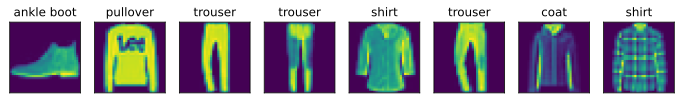

In [ ]:
@d2l.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

We are now ready to work with the Fashion-MNIST dataset in the sections that follow.

## Summary

We now have a slightly more realistic dataset to use for classification. Fashion-MNIST is an apparel classification dataset consisting of images representing 10 categories. We will use this dataset in subsequent sections and chapters to evaluate various network designs, from a simple linear model to advanced residual networks. As we commonly do with images, we read them as a tensor of shape (batch size, number of channels, height, width). For now, we only have one channel as the images are grayscale (the visualization above uses a false color palette for improved visibility).

Lastly, data iterators are a key component for efficient performance. For instance, we might use GPUs for efficient image decompression, video transcoding, or other preprocessing. Whenever possible, you should rely on well-implemented data iterators that exploit high-performance computing to avoid slowing down your training loop.


## Exercises

1. Does reducing the `batch_size` (for instance, to 1) affect the reading performance?
1. The data iterator performance is important. Do you think the current implementation is fast enough? Explore various options to improve it. Use a system profiler to find out where the bottlenecks are.
1. Check out the framework's online API documentation. Which other datasets are available?


[Discussions](https://discuss.d2l.ai/t/49)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# The Base Classification Model
:label:`sec_classification`

You may have noticed that the implementations from scratch and the concise implementation using framework functionality were quite similar in the case of regression. The same is true for classification. Since many models in this book deal with classification, it is worth adding functionalities to support this setting specifically. This section provides a base class for classification models to simplify future code.


In [ ]:
import torch
from d2l import torch as d2l

## The `Classifier` Class


We define the `Classifier` class below. In the `validation_step` we report both the loss value and the classification accuracy on a validation batch. We draw an update for every `num_val_batches` batches. This has the benefit of generating the averaged loss and accuracy on the whole validation data. These average numbers are not exactly correct if the final batch contains fewer examples, but we ignore this minor difference to keep the code simple.


In [ ]:
class Classifier(d2l.Module):  #@save
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

By default we use a stochastic gradient descent optimizer, operating on minibatches, just as we did in the context of linear regression.


In [ ]:
@d2l.add_to_class(d2l.Module)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

## Accuracy

Given the predicted probability distribution `y_hat`,
we typically choose the class with the highest predicted probability
whenever we must output a hard prediction.
Indeed, many applications require that we make a choice.
For instance, Gmail must categorize an email into "Primary", "Social", "Updates", "Forums", or "Spam".
It might estimate probabilities internally,
but at the end of the day it has to choose one among the classes.

When predictions are consistent with the label class `y`, they are correct.
The classification accuracy is the fraction of all predictions that are correct.
Although it can be difficult to optimize accuracy directly (it is not differentiable),
it is often the performance measure that we care about the most. It is often *the*
relevant quantity in benchmarks. As such, we will nearly always report it when training classifiers.

Accuracy is computed as follows.
First, if `y_hat` is a matrix,
we assume that the second dimension stores prediction scores for each class.
We use `argmax` to obtain the predicted class by the index for the largest entry in each row.
Then we [**compare the predicted class with the ground truth `y` elementwise.**]
Since the equality operator `==` is sensitive to data types,
we convert `y_hat`'s data type to match that of `y`.
The result is a tensor containing entries of 0 (false) and 1 (true).
Taking the sum yields the number of correct predictions.


In [ ]:
@d2l.add_to_class(Classifier)  #@save
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

## Summary

Classification is a sufficiently common problem that it warrants its own convenience functions. Of central importance in classification is the *accuracy* of the classifier. Note that while we often care primarily about accuracy, we train classifiers to optimize a variety of other objectives for statistical and computational reasons. However, regardless of which loss function was minimized during training, it is useful to have a convenience method for assessing the accuracy of our classifier empirically.


## Exercises

1. Denote by $L_\textrm{v}$ the validation loss, and let $L_\textrm{v}^\textrm{q}$ be its quick and dirty estimate computed by the loss function averaging in this section. Lastly, denote by $l_\textrm{v}^\textrm{b}$ the loss on the last minibatch. Express $L_\textrm{v}$ in terms of $L_\textrm{v}^\textrm{q}$, $l_\textrm{v}^\textrm{b}$, and the sample and minibatch sizes.
1. Show that the quick and dirty estimate $L_\textrm{v}^\textrm{q}$ is unbiased. That is, show that $E[L_\textrm{v}] = E[L_\textrm{v}^\textrm{q}]$. Why would you still want to use $L_\textrm{v}$ instead?
1. Given a multiclass classification loss, denoting by $l(y,y')$ the penalty of estimating $y'$ when we see $y$ and given a probabilty $p(y \mid x)$, formulate the rule for an optimal selection of $y'$. Hint: express the expected loss, using $l$ and $p(y \mid x)$.


[Discussions](https://discuss.d2l.ai/t/6809)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Softmax Regression Implementation from Scratch
:label:`sec_softmax_scratch`

Because softmax regression is so fundamental,
we believe that you ought to know
how to implement it yourself.
Here, we limit ourselves to defining the
softmax-specific aspects of the model
and reuse the other components
from our linear regression section,
including the training loop.


In [ ]:
import torch
from d2l import torch as d2l

## The Softmax

Let's begin with the most important part:
the mapping from scalars to probabilities.
For a refresher, recall the operation of the sum operator
along specific dimensions in a tensor,
as discussed in :numref:`subsec_lin-alg-reduction`
and :numref:`subsec_lin-alg-non-reduction`.
[**Given a matrix `X` we can sum over all elements (by default) or only
over elements in the same axis.**]
The `axis` variable lets us compute row and column sums:


In [ ]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

Computing the softmax requires three steps:
(i) exponentiation of each term;
(ii) a sum over each row to compute the normalization constant for each example;
(iii) division of each row by its normalization constant,
ensuring that the result sums to 1:

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

The (logarithm of the) denominator
is called the (log) *partition function*.
It was introduced in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
to sum over all possible states in a thermodynamic ensemble.
The implementation is straightforward:


In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

For any input `X`, [**we turn each element
into a nonnegative number.
Each row sums up to 1,**]
as is required for a probability. Caution: the code above is *not* robust against very large or very small arguments. While it is sufficient to illustrate what is happening, you should *not* use this code verbatim for any serious purpose. Deep learning frameworks have such protections built in and we will be using the built-in softmax going forward.


In [ ]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2511, 0.1417, 0.1158, 0.2529, 0.2385],
         [0.2004, 0.1419, 0.1957, 0.2504, 0.2117]]),
 tensor([1., 1.]))

## The Model

We now have everything that we need
to implement [**the softmax regression model.**]
As in our linear regression example,
each instance will be represented
by a fixed-length vector.
Since the raw data here consists
of $28 \times 28$ pixel images,
[**we flatten each image,
treating them as vectors of length 784.**]
In later chapters, we will introduce
convolutional neural networks,
which exploit the spatial structure
in a more satisfying way.


In softmax regression,
the number of outputs from our network
should be equal to the number of classes.
(**Since our dataset has 10 classes,
our network has an output dimension of 10.**)
Consequently, our weights constitute a $784 \times 10$ matrix
plus a $1 \times 10$ row vector for the biases.
As with linear regression,
we initialize the weights `W`
with Gaussian noise.
The biases are initialized as zeros.


In [ ]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

The code below defines how the network
maps each input to an output.
Note that we flatten each $28 \times 28$ pixel image in the batch
into a vector using `reshape`
before passing the data through our model.


In [ ]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

## The Cross-Entropy Loss

Next we need to implement the cross-entropy loss function
(introduced in :numref:`subsec_softmax-regression-loss-func`).
This may be the most common loss function
in all of deep learning.
At the moment, applications of deep learning
easily cast as classification problems
far outnumber those better treated as regression problems.

Recall that cross-entropy takes the negative log-likelihood
of the predicted probability assigned to the true label.
For efficiency we avoid Python for-loops and use indexing instead.
In particular, the one-hot encoding in $\mathbf{y}$
allows us to select the matching terms in $\hat{\mathbf{y}}$.

To see this in action we [**create sample data `y_hat`
with 2 examples of predicted probabilities over 3 classes and their corresponding labels `y`.**]
The correct labels are $0$ and $2$ respectively (i.e., the first and third class).
[**Using `y` as the indices of the probabilities in `y_hat`,**]
we can pick out terms efficiently.


In [ ]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Now we can (**implement the cross-entropy loss function**) by averaging over the logarithms of the selected probabilities.


In [ ]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [ ]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

We reuse the `fit` method defined in :numref:`sec_linear_scratch` to [**train the model with 10 epochs.**]
Note that the number of epochs (`max_epochs`),
the minibatch size (`batch_size`),
and learning rate (`lr`)
are adjustable hyperparameters.
That means that while these values are not
learned during our primary training loop,
they still influence the performance
of our model, both vis-à-vis training
and generalization performance.
In practice you will want to choose these values
based on the *validation* split of the data
and then, ultimately, to evaluate your final model
on the *test* split.
As discussed in :numref:`subsec_generalization-model-selection`,
we will regard the test data of Fashion-MNIST
as the validation set, thus
reporting validation loss and validation accuracy
on this split.


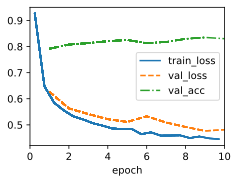

In [ ]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Prediction

Now that training is complete,
our model is ready to [**classify some images.**]


In [ ]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

We are more interested in the images we label *incorrectly*. We visualize them by
comparing their actual labels
(first line of text output)
with the predictions from the model
(second line of text output).


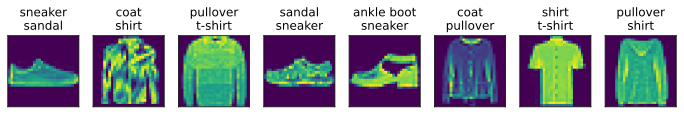

In [ ]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

## Summary

By now we are starting to get some experience
with solving linear regression
and classification problems.
With it, we have reached what would arguably be
the state of the art of 1960--1970s of statistical modeling.
In the next section, we will show you how to leverage
deep learning frameworks to implement this model
much more efficiently.

## Exercises

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. As discussed in :numref:`sec_softmax` this can cause numerical instabilities.
    1. Test whether `softmax` still works correctly if an input has a value of $100$.
    1. Test whether `softmax` still works correctly if the largest of all inputs is smaller than $-100$?
    1. Implement a fix by looking at the value relative to the largest entry in the argument.
1. Implement a `cross_entropy` function that follows the definition of the cross-entropy loss function $\sum_i y_i \log \hat{y}_i$.
    1. Try it out in the code example of this section.
    1. Why do you think it runs more slowly?
    1. Should you use it? When would it make sense to?
    1. What do you need to be careful of? Hint: consider the domain of the logarithm.
1. Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis? How would you try to address this?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?
1. Experiment with the hyperparameters of the code in this section. In particular:
    1. Plot how the validation loss changes as you change the learning rate.
    1. Do the validation and training loss change as you change the minibatch size? How large or small do you need to go before you see an effect?


[Discussions](https://discuss.d2l.ai/t/51)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Concise Implementation of Softmax Regression
:label:`sec_softmax_concise`



Just as high-level deep learning frameworks
made it easier to implement linear regression
(see :numref:`sec_linear_concise`),
they are similarly convenient here.


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Defining the Model

As in :numref:`sec_linear_concise`,
we construct our fully connected layer
using the built-in layer.
The built-in `__call__` method then invokes `forward`
whenever we need to apply the network to some input.


We use a `Flatten` layer to convert the fourth-order tensor `X` to second order
by keeping the dimensionality along the first axis unchanged.


In [ ]:
class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.net(X)

## Softmax Revisited
:label:`subsec_softmax-implementation-revisited`

In :numref:`sec_softmax_scratch` we calculated our model's output
and applied the cross-entropy loss. While this is perfectly
reasonable mathematically, it is risky computationally, because of
numerical underflow and overflow in the exponentiation.

Recall that the softmax function computes probabilities via
$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$.
If some of the $o_k$ are very large, i.e., very positive,
then $\exp(o_k)$ might be larger than the largest number
we can have for certain data types. This is called *overflow*. Likewise,
if every argument is a very large negative number, we will get *underflow*.
For instance, single precision floating point numbers approximately
cover the range of $10^{-38}$ to $10^{38}$. As such, if the largest term in $\mathbf{o}$
lies outside the interval $[-90, 90]$, the result will not be stable.
A way round this problem is to subtract $\bar{o} \stackrel{\textrm{def}}{=} \max_k o_k$ from
all entries:

$$
\hat y_j = \frac{\exp o_j}{\sum_k \exp o_k} =
\frac{\exp(o_j - \bar{o}) \exp \bar{o}}{\sum_k \exp (o_k - \bar{o}) \exp \bar{o}} =
\frac{\exp(o_j - \bar{o})}{\sum_k \exp (o_k - \bar{o})}.
$$

By construction we know that $o_j - \bar{o} \leq 0$ for all $j$. As such, for a $q$-class
classification problem, the denominator is contained in the interval $[1, q]$. Moreover, the
numerator never exceeds $1$, thus preventing numerical overflow. Numerical underflow only
occurs when $\exp(o_j - \bar{o})$ numerically evaluates as $0$. Nonetheless, a few steps down
the road we might find ourselves in trouble when we want to compute $\log \hat{y}_j$ as $\log 0$.
In particular, in backpropagation,
we might find ourselves faced with a screenful
of the dreaded `NaN` (Not a Number) results.

Fortunately, we are saved by the fact that
even though we are computing exponential functions,
we ultimately intend to take their log
(when calculating the cross-entropy loss).
By combining softmax and cross-entropy,
we can escape the numerical stability issues altogether. We have:

$$
\log \hat{y}_j =
\log \frac{\exp(o_j - \bar{o})}{\sum_k \exp (o_k - \bar{o})} =
o_j - \bar{o} - \log \sum_k \exp (o_k - \bar{o}).
$$

This avoids both overflow and underflow.
We will want to keep the conventional softmax function handy
in case we ever want to evaluate the output probabilities by our model.
But instead of passing softmax probabilities into our new loss function,
we just
[**pass the logits and compute the softmax and its log
all at once inside the cross-entropy loss function,**]
which does smart things like the ["LogSumExp trick"](https://en.wikipedia.org/wiki/LogSumExp).


In [ ]:
@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')

## Training

Next we train our model. We use Fashion-MNIST images, flattened to 784-dimensional feature vectors.


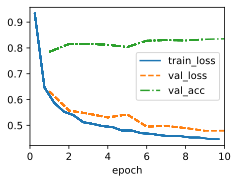

In [ ]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

As before, this algorithm converges to a solution
that is reasonably accurate,
albeit this time with fewer lines of code than before.


## Summary

High-level APIs are very convenient at hiding from their user potentially dangerous aspects, such as numerical stability. Moreover, they allow users to design models concisely with very few lines of code. This is both a blessing and a curse. The obvious benefit is that it makes things highly accessible, even to engineers who never took a single class of statistics in their life (in fact, they are part of the target audience of the book). But hiding the sharp edges also comes with a price: a disincentive to add new and different components on your own, since there is little muscle memory for doing it. Moreover, it makes it more difficult to *fix* things whenever the protective padding of
a framework fails to cover all the corner cases entirely. Again, this is due to lack of familiarity.

As such, we strongly urge you to review *both* the bare bones and the elegant versions of many of the implementations that follow. While we emphasize ease of understanding, the implementations are nonetheless usually quite performant (convolutions are the big exception here). It is our intention to allow you to build on these when you invent something new that no framework can give you.


## Exercises

1. Deep learning uses many different number formats, including FP64 double precision (used extremely rarely),
FP32 single precision, BFLOAT16 (good for compressed representations), FP16 (very unstable), TF32 (a new format from NVIDIA), and INT8. Compute the smallest and largest argument of the exponential function for which the result does not lead to numerical underflow or overflow.
1. INT8 is a very limited format consisting of nonzero numbers from $1$ to $255$. How could you extend its dynamic range without using more bits? Do standard multiplication and addition still work?
1. Increase the number of epochs for training. Why might the validation accuracy decrease after a while? How could we fix this?
1. What happens as you increase the learning rate? Compare the loss curves for several learning rates. Which one works better? When?


[Discussions](https://discuss.d2l.ai/t/53)


# Generalization in Classification

:label:`chap_classification_generalization`



So far, we have focused on how to tackle multiclass classification problems
by training (linear) neural networks with multiple outputs and softmax functions.
Interpreting our model's outputs as probabilistic predictions,
we motivated and derived the cross-entropy loss function,
which calculates the negative log likelihood
that our model (for a fixed set of parameters)
assigns to the actual labels.
And finally, we put these tools into practice
by fitting our model to the training set.
However, as always, our goal is to learn *general patterns*,
as assessed empirically on previously unseen data (the test set).
High accuracy on the training set means nothing.
Whenever each of our inputs is unique
(and indeed this is true for most high-dimensional datasets),
we can attain perfect accuracy on the training set
by just memorizing the dataset on the first training epoch,
and subsequently looking up the label whenever we see a new image.
And yet, memorizing the exact labels
associated with the exact training examples
does not tell us how to classify new examples.
Absent further guidance, we might have to fall back
on random guessing whenever we encounter new examples.

A number of burning questions demand immediate attention:

1. How many test examples do we need to give a good estimate of the accuracy of our classifiers on the underlying population?
1. What happens if we keep evaluating models on the same test repeatedly?
1. Why should we expect that fitting our linear models to the training set
   should fare any better than our naive memorization scheme?


Whereas :numref:`sec_generalization_basics` introduced
the basics of overfitting and generalization
in the context of linear regression,
this chapter will go a little deeper,
introducing some of the foundational ideas
of statistical learning theory.
It turns out that we often can guarantee generalization *a priori*:
for many models,
and for any desired upper bound
on the generalization gap $\epsilon$,
we can often determine some required number of samples $n$
such that if our training set contains at least $n$
samples, our empirical error will lie
within $\epsilon$ of the true error,
*for any data generating distribution*.
Unfortunately, it also turns out
that while these sorts of guarantees provide
a profound set of intellectual building blocks,
they are of limited practical utility
to the deep learning practitioner.
In short, these guarantees suggest
that ensuring generalization
of deep neural networks *a priori*
requires an absurd number of examples
(perhaps trillions or more),
even when we find that, on the tasks we care about,
deep neural networks typically generalize
remarkably well with far fewer examples (thousands).
Thus deep learning practitioners often forgo
*a priori* guarantees altogether,
instead employing methods
that have generalized well
on similar problems in the past,
and certifying generalization *post hoc*
through empirical evaluations.
When we get to :numref:`chap_perceptrons`,
we will revisit generalization
and provide a light introduction
to the vast scientific literature
that has sprung in attempts
to explain why deep neural networks generalize in practice.

## The Test Set

Since we have already begun to rely on test sets
as the gold standard method
for assessing generalization error,
let's get started by discussing
the properties of such error estimates.
Let's focus on a fixed classifier $f$,
without worrying about how it was obtained.
Moreover suppose that we possess
a *fresh* dataset of examples $\mathcal{D} = {(\mathbf{x}^{(i)},y^{(i)})}_{i=1}^n$
that were not used to train the classifier $f$.
The *empirical error* of our classifier $f$ on $\mathcal{D}$
is simply the fraction of instances
for which the prediction $f(\mathbf{x}^{(i)})$
disagrees with the true label $y^{(i)}$,
and is given by the following expression:

$$\epsilon_\mathcal{D}(f) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}(f(\mathbf{x}^{(i)}) \neq y^{(i)}).$$

By contrast, the *population error*
is the *expected* fraction
of examples in the underlying population
(some distribution $P(X,Y)$  characterized
by probability density function $p(\mathbf{x},y)$)
for which our classifier disagrees
with the true label:

$$\epsilon(f) =  E_{(\mathbf{x}, y) \sim P} \mathbf{1}(f(\mathbf{x}) \neq y) =
\int\int \mathbf{1}(f(\mathbf{x}) \neq y) p(\mathbf{x}, y) \;d\mathbf{x} dy.$$

While $\epsilon(f)$ is the quantity that we actually care about,
we cannot observe it directly,
just as we cannot directly
observe the average height in a large population
without measuring every single person.
We can only estimate this quantity based on samples.
Because our test set $\mathcal{D}$
is statistically representative
of the underlying population,
we can view $\epsilon_\mathcal{D}(f)$ as a statistical
estimator of the population error $\epsilon(f)$.
Moreover, because our quantity of interest $\epsilon(f)$
is an expectation (of the random variable $\mathbf{1}(f(X) \neq Y)$)
and the corresponding estimator $\epsilon_\mathcal{D}(f)$
is the sample average,
estimating the population error
is simply the classic problem of mean estimation,
which you may recall from :numref:`sec_prob`.

An important classical result from probability theory
called the *central limit theorem* guarantees
that whenever we possess $n$ random samples $a_1, ..., a_n$
drawn from any distribution with mean $\mu$ and standard deviation $\sigma$,
then, as the number of samples $n$ approaches infinity,
the sample average $\hat{\mu}$ approximately
tends towards a normal distribution centered
at the true mean and with standard deviation $\sigma/\sqrt{n}$.
Already, this tells us something important:
as the number of examples grows large,
our test error $\epsilon_\mathcal{D}(f)$
should approach the true error $\epsilon(f)$
at a rate of $\mathcal{O}(1/\sqrt{n})$.
Thus, to estimate our test error twice as precisely,
we must collect four times as large a test set.
To reduce our test error by a factor of one hundred,
we must collect ten thousand times as large a test set.
In general, such a rate of $\mathcal{O}(1/\sqrt{n})$
is often the best we can hope for in statistics.

Now that we know something about the asymptotic rate
at which our test error $\epsilon_\mathcal{D}(f)$ converges to the true error $\epsilon(f)$,
we can zoom in on some important details.
Recall that the random variable of interest
$\mathbf{1}(f(X) \neq Y)$
can only take values $0$ and $1$
and thus is a Bernoulli random variable,
characterized by a parameter
indicating the probability that it takes value $1$.
Here, $1$ means that our classifier made an error,
so the parameter of our random variable
is actually the true error rate $\epsilon(f)$.
The variance $\sigma^2$ of a Bernoulli
depends on its parameter (here, $\epsilon(f)$)
according to the expression $\epsilon(f)(1-\epsilon(f))$.
While $\epsilon(f)$ is initially unknown,
we know that it cannot be greater than $1$.
A little investigation of this function
reveals that our variance is highest
when the true error rate is close to $0.5$
and can be far lower when it is
close to $0$ or close to $1$.
This tells us that the asymptotic standard deviation
of our estimate $\epsilon_\mathcal{D}(f)$ of the error $\epsilon(f)$
(over the choice of the $n$ test samples)
cannot be any greater than $\sqrt{0.25/n}$.

If we ignore the fact that this rate characterizes
behavior as the test set size approaches infinity
rather than when we possess finite samples,
this tells us that if we want our test error $\epsilon_\mathcal{D}(f)$
to approximate the population error $\epsilon(f)$
such that one standard deviation corresponds
to an interval of $\pm 0.01$,
then we should collect roughly 2500 samples.
If we want to fit two standard deviations
in that range and thus be 95% confident
that $\epsilon_\mathcal{D}(f) \in \epsilon(f) \pm 0.01$,
then we will need 10,000 samples!

This turns out to be the size of the test sets
for many popular benchmarks in machine learning.
You might be surprised to find out that thousands
of applied deep learning papers get published every year
making a big deal out of error rate improvements of $0.01$ or less.
Of course, when the error rates are much closer to $0$,
then an improvement of $0.01$ can indeed be a big deal.


One pesky feature of our analysis thus far
is that it really only tells us about asymptotics,
i.e., how the relationship between $\epsilon_\mathcal{D}$ and $\epsilon$
evolves as our sample size goes to infinity.
Fortunately, because our random variable is bounded,
we can obtain valid finite sample bounds
by applying an inequality due to Hoeffding (1963):

$$P(\epsilon_\mathcal{D}(f) - \epsilon(f) \geq t) < \exp\left( - 2n t^2 \right).$$

Solving for the smallest dataset size
that would allow us to conclude
with 95% confidence that the distance $t$
between our estimate $\epsilon_\mathcal{D}(f)$
and the true error rate $\epsilon(f)$
does not exceed $0.01$,
you will find that roughly 15,000 examples are required
as compared to the 10,000 examples suggested
by the asymptotic analysis above.
If you go deeper into statistics
you will find that this trend holds generally.
Guarantees that hold even in finite samples
are typically slightly more conservative.
Note that in the scheme of things,
these numbers are not so far apart,
reflecting the general usefulness
of asymptotic analysis for giving
us ballpark figures even if they are not
guarantees we can take to court.

## Test Set Reuse

In some sense, you are now set up to succeed
at conducting empirical machine learning research.
Nearly all practical models are developed
and validated based on test set performance
and you are now a master of the test set.
For any fixed classifier $f$,
you know how to evaluate its test error $\epsilon_\mathcal{D}(f)$,
and know precisely what can (and cannot)
be said about its population error $\epsilon(f)$.

So let's say that you take this knowledge
and prepare to train your first model $f_1$.
Knowing just how confident you need to be
in the performance of your classifier's error rate
you apply our analysis above to determine
an appropriate number of examples
to set aside for the test set.
Moreover, let's assume that you took the lessons from
:numref:`sec_generalization_basics` to heart
and made sure to preserve the sanctity of the test set
by conducting all of your preliminary analysis,
hyperparameter tuning, and even selection
among multiple competing model architectures
on a validation set.
Finally you evaluate your model $f_1$
on the test set and report an unbiased
estimate of the population error
with an associated confidence interval.

So far everything seems to be going well.
However, that night you wake up at 3am
with a brilliant idea for a new modeling approach.
The next day, you code up your new model,
tune its hyperparameters on the validation set
and not only are you getting your new model $f_2$ to work
but its error rate appears to be much lower than $f_1$'s.
However, the thrill of discovery suddenly fades
as you prepare for the final evaluation.
You do not have a test set!

Even though the original test set $\mathcal{D}$
is still sitting on your server,
you now face two formidable problems.
First, when you collected your test set,
you determined the required level of precision
under the assumption that you were evaluating
a single classifier $f$.
However, if you get into the business
of evaluating multiple classifiers $f_1, ..., f_k$
on the same test set,
you must consider the problem of false discovery.
Before, you might have been 95% sure
that $\epsilon_\mathcal{D}(f) \in \epsilon(f) \pm 0.01$
for a single classifier $f$
and thus the probability of a misleading result
was a mere 5%.
With $k$ classifiers in the mix,
it can be hard to guarantee
that there is not even one among them
whose test set performance is misleading.
With 20 classifiers under consideration,
you might have no power at all
to rule out the possibility
that at least one among them
received a misleading score.
This problem relates to multiple hypothesis testing,
which despite a vast literature in statistics,
remains a persistent problem plaguing scientific research.


If that is not enough to worry you,
there is a special reason to distrust
the results that you get on subsequent evaluations.
Recall that our analysis of test set performance
rested on the assumption that the classifier
was chosen absent any contact with the test set
and thus we could view the test set
as drawn randomly from the underlying population.
Here, not only are you testing multiple functions,
the subsequent function $f_2$ was chosen
after you observed the test set performance of $f_1$.
Once information from the test set has leaked to the modeler,
it can never be a true test set again in the strictest sense.
This problem is called *adaptive overfitting* and has recently emerged
as a topic of intense interest to learning theorists and statisticians
:cite:`dwork2015preserving`.
Fortunately, while it is possible
to leak all information out of a holdout set,
and the theoretical worst case scenarios are bleak,
these analyses may be too conservative.
In practice, take care to create real test sets,
to consult them as infrequently as possible,
to account for multiple hypothesis testing
when reporting confidence intervals,
and to dial up your vigilance more aggressively
when the stakes are high and your dataset size is small.
When running a series of benchmark challenges,
it is often good practice to maintain
several test sets so that after each round,
the old test set can be demoted to a validation set.





## Statistical Learning Theory

Put simply, *test sets are all that we really have*,
and yet this fact seems strangely unsatisfying.
First, we seldom possess a *true test set*---unless
we are the ones creating the dataset,
someone else has probably already evaluated
their own classifier on our ostensible "test set".
And even when we have first dibs,
we soon find ourselves frustrated, wishing we could
evaluate our subsequent modeling attempts
without the gnawing feeling
that we cannot trust our numbers.
Moreover, even a true test set can only tell us *post hoc*
whether a classifier has in fact generalized to the population,
not whether we have any reason to expect *a priori*
that it should generalize.

With these misgivings in mind,
you might now be sufficiently primed
to see the appeal of *statistical learning theory*,
the mathematical subfield of machine learning
whose practitioners aim to elucidate the
fundamental principles that explain
why/when models trained on empirical data
can/will generalize to unseen data.
One of the primary aims
of statistical learning researchers
has been to bound the generalization gap,
relating the properties of the model class
to the number of samples in the dataset.

Learning theorists aim to bound the difference
between the *empirical error* $\epsilon_\mathcal{S}(f_\mathcal{S})$
of a learned classifier $f_\mathcal{S}$,
both trained and evaluated
on the training set $\mathcal{S}$,
and the true error $\epsilon(f_\mathcal{S})$
of that same classifier on the underlying population.
This might look similar to the evaluation problem
that we just addressed but there is a major difference.
Earlier, the classifier $f$ was fixed
and we only needed a dataset
for evaluative purposes.
And indeed, any fixed classifier does generalize:
its error on a (previously unseen) dataset
is an unbiased estimate of the population error.
But what can we say when a classifier
is trained and evaluated on the same dataset?
Can we ever be confident that the training error
will be close to the testing error?


Suppose that our learned classifier $f_\mathcal{S}$ must be chosen
from some pre-specified set of functions $\mathcal{F}$.
Recall from our discussion of test sets
that while it is easy to estimate
the error of a single classifier,
things get hairy when we begin
to consider collections of classifiers.
Even if the empirical error
of any one (fixed) classifier
will be close to its true error
with high probability,
once we consider a collection of classifiers,
we need to worry about the possibility
that *just one* of them
will receive a badly estimated error.
The worry is that we might pick such a classifier
and thereby grossly underestimate
the population error.
Moreover, even for linear models,
because their parameters are continuously valued,
we are typically choosing from
an infinite class of functions ($|\mathcal{F}| = \infty$).

One ambitious solution to the problem
is to develop analytic tools
for proving uniform convergence, i.e.,
that with high probability,
the empirical error rate for every classifier in the class $f\in\mathcal{F}$
will *simultaneously* converge to its true error rate.
In other words, we seek a theoretical principle
that would allow us to state that
with probability at least $1-\delta$
(for some small $\delta$)
no classifier's error rate $\epsilon(f)$
(among all classifiers in the class $\mathcal{F}$)
will be misestimated by more
than some  small amount $\alpha$.
Clearly, we cannot make such statements
for all model classes $\mathcal{F}$.
Recall the class of memorization machines
that always achieve empirical error $0$
but never outperform random guessing
on the underlying population.

In a sense the class of memorizers is too flexible.
No such a uniform convergence result could possibly hold.
On the other hand, a fixed classifier is useless---it
generalizes perfectly, but fits neither
the training data nor the test data.
The central question of learning
has thus historically been framed as a trade-off
between more flexible (higher variance) model classes
that better fit the training data but risk overfitting,
versus more rigid (higher bias) model classes
that generalize well but risk underfitting.
A central question in learning theory
has been to develop the appropriate
mathematical analysis to quantify
where a model sits along this spectrum,
and to provide the associated guarantees.

In a series of seminal papers,
Vapnik and Chervonenkis extended
the theory on the convergence
of relative frequencies
to more general classes of functions
:cite:`VapChe64,VapChe68,VapChe71,VapChe74b,VapChe81,VapChe91`.
One of the key contributions of this line of work
is the Vapnik--Chervonenkis (VC) dimension,
which measures (one notion of)
the complexity (flexibility) of a model class.
Moreover, one of their key results bounds
the difference between the empirical error
and the population error as a function
of the VC dimension and the number of samples:

$$P\left(R[p, f] - R_\textrm{emp}[\mathbf{X}, \mathbf{Y}, f] < \alpha\right) \geq 1-\delta
\ \textrm{ for }\ \alpha \geq c \sqrt{(\textrm{VC} - \log \delta)/n}.$$

Here $\delta > 0$ is the probability that the bound is violated,
$\alpha$ is the upper bound on the generalization gap,
and $n$ is the dataset size.
Lastly, $c > 0$ is a constant that depends
only on the scale of the loss that can be incurred.
One use of the bound might be to plug in desired
values of $\delta$ and $\alpha$
to determine how many samples to collect.
The VC dimension quantifies the largest
number of data points for which we can assign
any arbitrary (binary) labeling
and for each find some model $f$ in the class
that agrees with that labeling.
For example, linear models on $d$-dimensional inputs
have VC dimension $d+1$.
It is easy to see that a line can assign
any possible labeling to three points in two dimensions,
but not to four.
Unfortunately, the theory tends to be
overly pessimistic for more complex models
and obtaining this guarantee typically requires
far more examples than are actually needed
to achieve the desired error rate.
Note also that fixing the model class and $\delta$,
our error rate again decays
with the usual $\mathcal{O}(1/\sqrt{n})$ rate.
It seems unlikely that we could do better in terms of $n$.
However, as we vary the model class,
VC dimension can present
a pessimistic picture
of the generalization gap.





## Summary

The most straightforward way to evaluate a model
is to consult a test set comprised of previously unseen data.
Test set evaluations provide an unbiased estimate of the true error
and converge at the desired $\mathcal{O}(1/\sqrt{n})$ rate as the test set grows.
We can provide approximate confidence intervals
based on exact asymptotic distributions
or valid finite sample confidence intervals
based on (more conservative) finite sample guarantees.
Indeed test set evaluation is the bedrock
of modern machine learning research.
However, test sets are seldom true test sets
(used by multiple researchers again and again).
Once the same test set is used
to evaluate multiple models,
controlling for false discovery can be difficult.
This can cause huge problems in theory.
In practice, the significance of the problem
depends on the size of the holdout sets in question
and whether they are merely being used to choose hyperparameters
or if they are leaking information more directly.
Nevertheless, it is good practice to curate real test sets (or multiple)
and to be as conservative as possible about how often they are used.


Hoping to provide a more satisfying solution,
statistical learning theorists have developed methods
for guaranteeing uniform convergence over a model class.
If indeed every model's empirical error simultaneously
converges to its true error,
then we are free to choose the model that performs
best, minimizing the training error,
knowing that it too will perform similarly well
on the holdout data.
Crucially, any one of such results must depend
on some property of the model class.
Vladimir Vapnik and Alexey Chernovenkis
introduced the VC dimension,
presenting uniform convergence results
that hold for all models in a VC class.
The training errors for all models in the class
are (simultaneously) guaranteed
to be close to their true errors,
and guaranteed to grow even closer
at $\mathcal{O}(1/\sqrt{n})$ rates.
Following the revolutionary discovery of VC dimension,
numerous alternative complexity measures have been proposed,
each facilitating an analogous generalization guarantee.
See :citet:`boucheron2005theory` for a detailed discussion
of several advanced ways of measuring function complexity.
Unfortunately, while these complexity measures
have become broadly useful tools in statistical theory,
they turn out to be powerless
(as straightforwardly applied)
for explaining why deep neural networks generalize.
Deep neural networks often have millions of parameters (or more),
and can easily assign random labels to large collections of points.
Nevertheless, they generalize well on practical problems
and, surprisingly, they often generalize better,
when they are larger and deeper,
despite incurring higher VC dimensions.
In the next chapter, we will revisit generalization
in the context of deep learning.

## Exercises

1. If we wish to estimate the error of a fixed model $f$
   to within $0.0001$ with probability greater than 99.9%,
   how many samples do we need?
1. Suppose that somebody else possesses a labeled test set
   $\mathcal{D}$ and only makes available the unlabeled inputs (features).
   Now suppose that you can only access the test set labels
   by running a model $f$ (with no restrictions placed on the model class)
   on each of the unlabeled inputs
   and receiving the corresponding error $\epsilon_\mathcal{D}(f)$.
   How many models would you need to evaluate
   before you leak the entire test set
   and thus could appear to have error $0$,
   regardless of your true error?
1. What is the VC dimension of the class of fifth-order polynomials?
1. What is the VC dimension of axis-aligned rectangles on two-dimensional data?

[Discussions](https://discuss.d2l.ai/t/6829)


# Environment and Distribution Shift
:label:`sec_environment-and-distribution-shift`

In the previous sections, we worked through
a number of hands-on applications of machine learning,
fitting models to a variety of datasets.
And yet, we never stopped to contemplate
either where data came from in the first place
or what we ultimately plan to do
with the outputs from our models.
Too often, machine learning developers
in possession of data rush to develop models
without pausing to consider these fundamental issues.

Many failed machine learning deployments
can be traced back to this failure.
Sometimes models appear to perform marvelously
as measured by test set accuracy
but fail catastrophically in deployment
when the distribution of data suddenly shifts.
More insidiously, sometimes the very deployment of a model
can be the catalyst that perturbs the data distribution.
Say, for example, that we trained a model
to predict who will repay rather than default on a loan,
finding that an applicant's choice of footwear
was associated with the risk of default
(Oxfords indicate repayment, sneakers indicate default).
We might be inclined
thereafter to grant a loan
to any applicant wearing Oxfords
and to deny all applicants wearing sneakers.

In this case, our ill-considered leap from
pattern recognition to decision-making
and our failure to critically consider the environment
might have disastrous consequences.
For starters, as soon as we began
making decisions based on footwear,
customers would catch on and change their behavior.
Before long, all applicants would be wearing Oxfords,
without any coincident improvement in credit-worthiness.
Take a minute to digest this because similar issues abound
in many applications of machine learning:
by introducing our model-based decisions to the environment,
we might break the model.

While we cannot possibly give these topics
a complete treatment in one section,
we aim here to expose some common concerns,
and to stimulate the critical thinking
required to detect such situations early,
mitigate damage, and use machine learning responsibly.
Some of the solutions are simple
(ask for the "right" data),
some are technically difficult
(implement a reinforcement learning system),
and others require that we step outside the realm of
statistical prediction altogether and
grapple with difficult philosophical questions
concerning the ethical application of algorithms.

## Types of Distribution Shift

To begin, we stick with the passive prediction setting
considering the various ways that data distributions might shift
and what might be done to salvage model performance.
In one classic setup, we assume that our training data
was sampled from some distribution $p_S(\mathbf{x},y)$
but that our test data will consist
of unlabeled examples drawn from
some different distribution $p_T(\mathbf{x},y)$.
Already, we must confront a sobering reality.
Absent any assumptions on how $p_S$
and $p_T$ relate to each other,
learning a robust classifier is impossible.

Consider a binary classification problem,
where we wish to distinguish between dogs and cats.
If the distribution can shift in arbitrary ways,
then our setup permits the pathological case
in which the distribution over inputs remains
constant: $p_S(\mathbf{x}) = p_T(\mathbf{x})$,
but the labels are all flipped:
$p_S(y \mid \mathbf{x}) = 1 - p_T(y \mid \mathbf{x})$.
In other words, if God can suddenly decide
that in the future all "cats" are now dogs
and what we previously called "dogs" are now cats---without
any change in the distribution of inputs $p(\mathbf{x})$,
then we cannot possibly distinguish this setting
from one in which the distribution did not change at all.

Fortunately, under some restricted assumptions
on the ways our data might change in the future,
principled algorithms can detect shift
and sometimes even adapt on the fly,
improving on the accuracy of the original classifier.

### Covariate Shift

Among categories of distribution shift,
covariate shift may be the most widely studied.
Here, we assume that while the distribution of inputs
may change over time, the labeling function,
i.e., the conditional distribution
$P(y \mid \mathbf{x})$ does not change.
Statisticians call this *covariate shift*
because the problem arises due to a
shift in the distribution of the covariates (features).
While we can sometimes reason about distribution shift
without invoking causality, we note that covariate shift
is the natural assumption to invoke in settings
where we believe that $\mathbf{x}$ causes $y$.

Consider the challenge of distinguishing cats and dogs.
Our training data might consist of images of the kind in :numref:`fig_cat-dog-train`.

![Training data for distinguishing cats and dogs (illustrations: Lafeez Hossain / 500px / Getty Images; ilkermetinkursova / iStock / Getty Images Plus; GlobalP / iStock / Getty Images Plus; Musthafa Aboobakuru / 500px / Getty Images).](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/cat-dog-train.png?raw=1)
:label:`fig_cat-dog-train`


At test time we are asked to classify the images in :numref:`fig_cat-dog-test`.

![Test data for distinguishing cats and dogs (illustrations: SIBAS_minich / iStock / Getty Images Plus; Ghrzuzudu / iStock / Getty Images Plus; id-work / DigitalVision Vectors / Getty Images; Yime / iStock / Getty Images Plus).](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/cat-dog-test.png?raw=1)
:label:`fig_cat-dog-test`

The training set consists of photos,
while the test set contains only cartoons.
Training on a dataset with substantially different
characteristics from the test set
can spell trouble absent a coherent plan
for how to adapt to the new domain.

### Label Shift

*Label shift* describes the converse problem.
Here, we assume that the label marginal $P(y)$
can change
but the class-conditional distribution
$P(\mathbf{x} \mid y)$ remains fixed across domains.
Label shift is a reasonable assumption to make
when we believe that $y$ causes $\mathbf{x}$.
For example, we may want to predict diagnoses
given their symptoms (or other manifestations),
even as the relative prevalence of diagnoses
are changing over time.
Label shift is the appropriate assumption here
because diseases cause symptoms.
In some degenerate cases the label shift
and covariate shift assumptions can hold simultaneously.
For example, when the label is deterministic,
the covariate shift assumption will be satisfied,
even when $y$ causes $\mathbf{x}$.
Interestingly, in these cases,
it is often advantageous to work with methods
that flow from the label shift assumption.
That is because these methods tend
to involve manipulating objects that look like labels (often low-dimensional),
as opposed to objects that look like inputs,
which tend to be high-dimensional in deep learning.

### Concept Shift

We may also encounter the related problem of *concept shift*,
which arises when the very definitions of labels can change.
This sounds weird---a *cat* is a *cat*, no?
However, other categories are subject to changes in usage over time.
Diagnostic criteria for mental illness,
what passes for fashionable, and job titles,
are all subject to considerable
amounts of concept shift.
It turns out that if we navigate around the United States,
shifting the source of our data by geography,
we will find considerable concept shift regarding
the distribution of names for *soft drinks*
as shown in :numref:`fig_popvssoda`.

![Concept shift for soft drink names in the United States (CC-BY: Alan McConchie, PopVsSoda.com).](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/popvssoda.png?raw=1)
:width:`400px`
:label:`fig_popvssoda`

If we were to build a machine translation system,
the distribution $P(y \mid \mathbf{x})$ might be different
depending on our location.
This problem can be tricky to spot.
We might hope to exploit knowledge
that shift only takes place gradually
either in a temporal or geographic sense.

## Examples of Distribution Shift

Before delving into formalism and algorithms,
we can discuss some concrete situations
where covariate or concept shift might not be obvious.


### Medical Diagnostics

Imagine that you want to design an algorithm to detect cancer.
You collect data from healthy and sick people
and you train your algorithm.
It works fine, giving you high accuracy
and you conclude that you are ready
for a successful career in medical diagnostics.
*Not so fast.*

The distributions that gave rise to the training data
and those you will encounter in the wild might differ considerably.
This happened to an unfortunate startup
that some of we authors worked with years ago.
They were developing a blood test for a disease
that predominantly affects older men
and hoped to study it using blood samples
that they had collected from patients.
However, it is considerably more difficult
to obtain blood samples from healthy men
than from sick patients already in the system.
To compensate, the startup solicited
blood donations from students on a university campus
to serve as healthy controls in developing their test.
Then they asked whether we could help them
to build a classifier for detecting the disease.

As we explained to them,
it would indeed be easy to distinguish
between the healthy and sick cohorts
with near-perfect accuracy.
However, that is because the test subjects
differed in age, hormone levels,
physical activity, diet, alcohol consumption,
and many more factors unrelated to the disease.
This was unlikely to be the case with real patients.
Due to their sampling procedure,
we could expect to encounter extreme covariate shift.
Moreover, this case was unlikely to be
correctable via conventional methods.
In short, they wasted a significant sum of money.



### Self-Driving Cars

Say a company wanted to leverage machine learning
for developing self-driving cars.
One key component here is a roadside detector.
Since real annotated data is expensive to get,
they had the (smart and questionable) idea
to use synthetic data from a game rendering engine
as additional training data.
This worked really well on "test data"
drawn from the rendering engine.
Alas, inside a real car it was a disaster.
As it turned out, the roadside had been rendered
with a very simplistic texture.
More importantly, *all* the roadside had been rendered
with the *same* texture and the roadside detector
learned about this "feature" very quickly.

A similar thing happened to the US Army
when they first tried to detect tanks in the forest.
They took aerial photographs of the forest without tanks,
then drove the tanks into the forest
and took another set of pictures.
The classifier appeared to work *perfectly*.
Unfortunately, it had merely learned
how to distinguish trees with shadows
from trees without shadows---the first set
of pictures was taken in the early morning,
the second set at noon.

### Nonstationary Distributions

A much more subtle situation arises
when the distribution changes slowly
(also known as *nonstationary distribution*)
and the model is not updated adequately.
Below are some typical cases.

* We train a computational advertising model and then fail to update it frequently (e.g., we forget to incorporate that an obscure new device called an iPad was just launched).
* We build a spam filter. It works well at detecting all spam that we have seen so far. But then the spammers wise up and craft new messages that look unlike anything we have seen before.
* We build a product recommendation system. It works throughout the winter but then continues to recommend Santa hats long after Christmas.

### More Anecdotes

* We build a face detector. It works well on all benchmarks. Unfortunately it fails on test data---the offending examples are close-ups where the face fills the entire image (no such data was in the training set).
* We build a web search engine for the US market and want to deploy it in the UK.
* We train an image classifier by compiling a large dataset where each among a large set of classes is equally represented in the dataset, say 1000 categories, represented by 1000 images each. Then we deploy the system in the real world, where the actual label distribution of photographs is decidedly non-uniform.






## Correction of Distribution Shift

As we have discussed, there are many cases
where training and test distributions
$P(\mathbf{x}, y)$ are different.
In some cases, we get lucky and the models work
despite covariate, label, or concept shift.
In other cases, we can do better by employing
principled strategies to cope with the shift.
The remainder of this section grows considerably more technical.
The impatient reader could continue on to the next section
as this material is not prerequisite to subsequent concepts.

### Empirical Risk and  Risk
:label:`subsec_empirical-risk-and-risk`

Let's first reflect on what exactly
is happening during model training:
we iterate over features and associated labels
of training data
$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$
and update the parameters of a model $f$ after every minibatch.
For simplicity we do not consider regularization,
so we largely minimize the loss on the training:

$$\mathop{\mathrm{minimize}}_f \frac{1}{n} \sum_{i=1}^n l(f(\mathbf{x}_i), y_i),$$
:eqlabel:`eq_empirical-risk-min`

where $l$ is the loss function
measuring "how bad" the prediction $f(\mathbf{x}_i)$ is given the associated label $y_i$.
Statisticians call the term in :eqref:`eq_empirical-risk-min` *empirical risk*.
The *empirical risk* is an average loss over the training data
for approximating the *risk*,
which is the
expectation of the loss over the entire population of data drawn from their true distribution
$p(\mathbf{x},y)$:

$$E_{p(\mathbf{x}, y)} [l(f(\mathbf{x}), y)] = \int\int l(f(\mathbf{x}), y) p(\mathbf{x}, y) \;d\mathbf{x}dy.$$
:eqlabel:`eq_true-risk`

However, in practice we typically cannot obtain the entire population of data.
Thus, *empirical risk minimization*,
which is minimizing the empirical risk in :eqref:`eq_empirical-risk-min`,
is a practical strategy for machine learning,
with the hope of approximately
minimizing the risk.



### Covariate Shift Correction
:label:`subsec_covariate-shift-correction`

Assume that we want to estimate
some dependency $P(y \mid \mathbf{x})$
for which we have labeled data $(\mathbf{x}_i, y_i)$.
Unfortunately, the observations $\mathbf{x}_i$ are drawn
from some *source distribution* $q(\mathbf{x})$
rather than the *target distribution* $p(\mathbf{x})$.
Fortunately,
the dependency assumption means
that the conditional distribution does not change: $p(y \mid \mathbf{x}) = q(y \mid \mathbf{x})$.
If the source distribution $q(\mathbf{x})$ is "wrong",
we can correct for that by using the following simple identity in the risk:

$$
\begin{aligned}
\int\int l(f(\mathbf{x}), y) p(y \mid \mathbf{x})p(\mathbf{x}) \;d\mathbf{x}dy =
\int\int l(f(\mathbf{x}), y) q(y \mid \mathbf{x})q(\mathbf{x})\frac{p(\mathbf{x})}{q(\mathbf{x})} \;d\mathbf{x}dy.
\end{aligned}
$$

In other words, we need to reweigh each data example
by the ratio of the
probability
that it would have been drawn from the correct distribution to that from the wrong one:

$$\beta_i \stackrel{\textrm{def}}{=} \frac{p(\mathbf{x}_i)}{q(\mathbf{x}_i)}.$$

Plugging in the weight $\beta_i$ for
each data example $(\mathbf{x}_i, y_i)$
we can train our model using
*weighted empirical risk minimization*:

$$\mathop{\mathrm{minimize}}_f \frac{1}{n} \sum_{i=1}^n \beta_i l(f(\mathbf{x}_i), y_i).$$
:eqlabel:`eq_weighted-empirical-risk-min`



Alas, we do not know that ratio,
so before we can do anything useful we need to estimate it.
Many methods are available,
including some fancy operator-theoretic approaches
that attempt to recalibrate the expectation operator directly
using a minimum-norm or a maximum entropy principle.
Note that for any such approach, we need samples
drawn from both distributions---the "true" $p$, e.g.,
by access to test data, and the one used
for generating the training set $q$ (the latter is trivially available).
Note however, that we only need features $\mathbf{x} \sim p(\mathbf{x})$;
we do not need to access labels $y \sim p(y)$.

In this case, there exists a very effective approach
that will give almost as good results as the original: namely, logistic regression,
which is a special case of softmax regression (see :numref:`sec_softmax`)
for binary classification.
This is all that is needed to compute estimated probability ratios.
We learn a classifier to distinguish
between data drawn from $p(\mathbf{x})$
and data drawn from $q(\mathbf{x})$.
If it is impossible to distinguish
between the two distributions
then it means that the associated instances
are equally likely to come from
either one of those two distributions.
On the other hand, any instances
that can be well discriminated
should be significantly overweighted
or underweighted accordingly.

For simplicity's sake assume that we have
an equal number of instances from both distributions
$p(\mathbf{x})$
and $q(\mathbf{x})$, respectively.
Now denote by $z$ labels that are $1$
for data drawn from $p$ and $-1$ for data drawn from $q$.
Then the probability in a mixed dataset is given by

$$P(z=1 \mid \mathbf{x}) = \frac{p(\mathbf{x})}{p(\mathbf{x})+q(\mathbf{x})} \textrm{ and hence } \frac{P(z=1 \mid \mathbf{x})}{P(z=-1 \mid \mathbf{x})} = \frac{p(\mathbf{x})}{q(\mathbf{x})}.$$

Thus, if we use a logistic regression approach,
where $P(z=1 \mid \mathbf{x})=\frac{1}{1+\exp(-h(\mathbf{x}))}$ ($h$ is a parametrized function),
it follows that

$$
\beta_i = \frac{1/(1 + \exp(-h(\mathbf{x}_i)))}{\exp(-h(\mathbf{x}_i))/(1 + \exp(-h(\mathbf{x}_i)))} = \exp(h(\mathbf{x}_i)).
$$

As a result, we need to solve two problems:
the first, to distinguish between
data drawn from both distributions,
and then a weighted empirical risk minimization problem
in :eqref:`eq_weighted-empirical-risk-min`
where we weigh terms by $\beta_i$.

Now we are ready to describe a correction algorithm.
Suppose that we have a training set $\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$ and an unlabeled test set $\{\mathbf{u}_1, \ldots, \mathbf{u}_m\}$.
For covariate shift,
we assume that $\mathbf{x}_i$ for all $1 \leq i \leq n$ are drawn from some source distribution
and $\mathbf{u}_i$ for all $1 \leq i \leq m$
are drawn from the target distribution.
Here is a prototypical algorithm
for correcting covariate shift:

1. Create a binary-classification training set: $\{(\mathbf{x}_1, -1), \ldots, (\mathbf{x}_n, -1), (\mathbf{u}_1, 1), \ldots, (\mathbf{u}_m, 1)\}$.
1. Train a binary classifier using logistic regression to get the function $h$.
1. Weigh training data using $\beta_i = \exp(h(\mathbf{x}_i))$ or better $\beta_i = \min(\exp(h(\mathbf{x}_i)), c)$ for some constant $c$.
1. Use weights $\beta_i$ for training on $\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$ in :eqref:`eq_weighted-empirical-risk-min`.

Note that the above algorithm relies on a crucial assumption.
For this scheme to work, we need that each data example
in the target (e.g., test time) distribution
had nonzero probability of occurring at training time.
If we find a point where $p(\mathbf{x}) > 0$ but $q(\mathbf{x}) = 0$,
then the corresponding importance weight should be infinity.






### Label Shift Correction

Assume that we are dealing with a
classification task with $k$ categories.
Using the same notation in :numref:`subsec_covariate-shift-correction`,
$q$ and $p$ are the source distribution (e.g., training time) and target distribution (e.g., test time), respectively.
Assume that the distribution of labels shifts over time:
$q(y) \neq p(y)$, but the class-conditional distribution
stays the same: $q(\mathbf{x} \mid y)=p(\mathbf{x} \mid y)$.
If the source distribution $q(y)$ is "wrong",
we can correct for that
according to
the following identity in the risk
as defined in
:eqref:`eq_true-risk`:

$$
\begin{aligned}
\int\int l(f(\mathbf{x}), y) p(\mathbf{x} \mid y)p(y) \;d\mathbf{x}dy =
\int\int l(f(\mathbf{x}), y) q(\mathbf{x} \mid y)q(y)\frac{p(y)}{q(y)} \;d\mathbf{x}dy.
\end{aligned}
$$



Here, our importance weights will correspond to the
label likelihood ratios:

$$\beta_i \stackrel{\textrm{def}}{=} \frac{p(y_i)}{q(y_i)}.$$

One nice thing about label shift is that
if we have a reasonably good model
on the source distribution,
then we can get consistent estimates of these weights
without ever having to deal with the ambient dimension.
In deep learning, the inputs tend
to be high-dimensional objects like images,
while the labels are often simpler objects like categories.

To estimate the target label distribution,
we first take our reasonably good off-the-shelf classifier
(typically trained on the training data)
and compute its "confusion" matrix using the validation set
(also from the training distribution).
The *confusion matrix*, $\mathbf{C}$, is simply a $k \times k$ matrix,
where each column corresponds to the label category (ground truth)
and each row corresponds to our model's predicted category.
Each cell's value $c_{ij}$ is the fraction of total predictions on the validation set
where the true label was $j$ and our model predicted $i$.

Now, we cannot calculate the confusion matrix
on the target data directly
because we do not get to see the labels for the examples
that we see in the wild,
unless we invest in a complex real-time annotation pipeline.
What we can do, however, is average all of our model's predictions
at test time together, yielding the mean model outputs $\mu(\hat{\mathbf{y}}) \in \mathbb{R}^k$,
where the $i^\textrm{th}$ element $\mu(\hat{y}_i)$
is the fraction of the total predictions on the test set
where our model predicted $i$.

It turns out that under some mild conditions---if
our classifier was reasonably accurate in the first place,
and if the target data contains only categories
that we have seen before,
and if the label shift assumption holds in the first place
(the strongest assumption here)---we can estimate the test set label distribution
by solving a simple linear system

$$\mathbf{C} p(\mathbf{y}) = \mu(\hat{\mathbf{y}}),$$

because as an estimate $\sum_{j=1}^k c_{ij} p(y_j) = \mu(\hat{y}_i)$ holds for all $1 \leq i \leq k$,
where $p(y_j)$ is the $j^\textrm{th}$ element of the $k$-dimensional label distribution vector $p(\mathbf{y})$.
If our classifier is sufficiently accurate to begin with,
then the confusion matrix $\mathbf{C}$ will be invertible,
and we get a solution $p(\mathbf{y}) = \mathbf{C}^{-1} \mu(\hat{\mathbf{y}})$.

Because we observe the labels on the source data,
it is easy to estimate the distribution $q(y)$.
Then, for any training example $i$ with label $y_i$,
we can take the ratio of our estimated $p(y_i)/q(y_i)$
to calculate the weight $\beta_i$,
and plug this into weighted empirical risk minimization
in :eqref:`eq_weighted-empirical-risk-min`.


### Concept Shift Correction

Concept shift is much harder to fix in a principled manner.
For instance, in a situation where suddenly the problem changes
from distinguishing cats from dogs to one of
distinguishing white from black animals,
it will be unreasonable to assume
that we can do much better than just collecting new labels
and training from scratch.
Fortunately, in practice, such extreme shifts are rare.
Instead, what usually happens is that the task keeps on changing slowly.
To make things more concrete, here are some examples:

* In computational advertising, new products are launched,
old products become less popular. This means that the distribution over ads and their popularity changes gradually and any click-through rate predictor needs to change gradually with it.
* Traffic camera lenses degrade gradually due to environmental wear, affecting image quality progressively.
* News content changes gradually (i.e., most of the news remains unchanged but new stories appear).

In such cases, we can use the same approach that we used for training networks to make them adapt to the change in the data. In other words, we use the existing network weights and simply perform a few update steps with the new data rather than training from scratch.


## A Taxonomy of Learning Problems

Armed with knowledge about how to deal with changes in distributions, we can now consider some other aspects of machine learning problem formulation.


### Batch Learning

In *batch learning*, we have access to training features and labels $\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$, which we use to train a model $f(\mathbf{x})$. Later on, we deploy this model to score new data $(\mathbf{x}, y)$ drawn from the same distribution. This is the default assumption for any of the problems that we discuss here. For instance, we might train a cat detector based on lots of pictures of cats and dogs. Once we have trained it, we ship it as part of a smart catdoor computer vision system that lets only cats in. This is then installed in a customer's home and is never updated again (barring extreme circumstances).


### Online Learning

Now imagine that the data $(\mathbf{x}_i, y_i)$ arrives one sample at a time. More specifically, assume that we first observe $\mathbf{x}_i$, then we need to come up with an estimate $f(\mathbf{x}_i)$. Only once we have done this do we observe $y_i$ and so receive a reward or incur a loss, given our decision.
Many real problems fall into this category. For example, we need to predict tomorrow's stock price, which allows us to trade based on that estimate and at the end of the day we find out whether our estimate made us a profit. In other words, in *online learning*, we have the following cycle where we are continuously improving our model given new observations:

$$\begin{aligned}&\textrm{model } f_t \longrightarrow \textrm{data }  \mathbf{x}_t \longrightarrow \textrm{estimate } f_t(\mathbf{x}_t) \longrightarrow\\ \textrm{obs}&\textrm{ervation } y_t \longrightarrow \textrm{loss } l(y_t, f_t(\mathbf{x}_t)) \longrightarrow \textrm{model } f_{t+1}\end{aligned}$$

### Bandits

*Bandits* are a special case of the problem above. While in most learning problems we have a continuously parametrized function $f$ where we want to learn its parameters (e.g., a deep network), in a *bandit* problem we only have a finite number of arms that we can pull, i.e., a finite number of actions that we can take. It is not very surprising that for this simpler problem stronger theoretical guarantees in terms of optimality can be obtained. We list it mainly since this problem is often (confusingly) treated as if it were a distinct learning setting.


### Control

In many cases the environment remembers what we did. Not necessarily in an adversarial manner but it will just remember and the response will depend on what happened before. For instance, a coffee boiler controller will observe different temperatures depending on whether it was heating the boiler previously. PID (proportional-integral-derivative) controller algorithms are a popular choice there.
Likewise, a user's behavior on a news site will depend on what we showed them previously (e.g., they will read most news only once). Many such algorithms form a model of the environment in which they act so as to make their decisions appear less random.
Recently,
control theory (e.g., PID variants) has also been used
to automatically tune hyperparameters
to achieve better disentangling and reconstruction quality,
and improve the diversity of generated text and the reconstruction quality of generated images :cite:`Shao.Yao.Sun.ea.2020`.




### Reinforcement Learning

In the more general case of an environment with memory, we may encounter situations where the environment is trying to cooperate with us (cooperative games, in particular for non-zero-sum games), or others where the environment will try to win. Chess, Go, Backgammon, or StarCraft are some of the cases in *reinforcement learning*. Likewise, we might want to build a good controller for autonomous cars. Other cars are likely to respond to the autonomous car's driving style in nontrivial ways, e.g., trying to avoid it, trying to cause an accident, or trying to cooperate with it.

### Considering the Environment

One key distinction between the different situations above is that a strategy that might have worked throughout in the case of a stationary environment, might not work throughout in an environment that can adapt. For instance, an arbitrage opportunity discovered by a trader is likely to disappear once it is exploited. The speed and manner at which the environment changes determines to a large extent the type of algorithms that we can bring to bear. For instance, if we know that things may only change slowly, we can force any estimate to change only slowly, too. If we know that the environment might change instantaneously, but only very infrequently, we can make allowances for that. These types of knowledge are crucial for the aspiring data scientist in dealing with concept shift, i.e., when the problem that is being solved can change over time.




## Fairness, Accountability, and Transparency in Machine Learning

Finally, it is important to remember
that when you deploy machine learning systems
you are not merely optimizing a predictive model---you
are typically providing a tool that will
be used to (partially or fully) automate decisions.
These technical systems can impact the lives
of individuals who are subject to the resulting decisions.
The leap from considering predictions to making decisions
raises not only new technical questions,
but also a slew of ethical questions
that must be carefully considered.
If we are deploying a medical diagnostic system,
we need to know for which populations
it may work and for which it may not.
Overlooking foreseeable risks to the welfare of
a subpopulation could cause us to administer inferior care.
Moreover, once we contemplate decision-making systems,
we must step back and reconsider how we evaluate our technology.
Among other consequences of this change of scope,
we will find that *accuracy* is seldom the right measure.
For instance, when translating predictions into actions,
we will often want to take into account
the potential cost sensitivity of erring in various ways.
If one way of misclassifying an image
could be perceived as a racial sleight of hand,
while misclassification to a different category
would be harmless, then we might want to adjust
our thresholds accordingly, accounting for societal values
in designing the decision-making protocol.
We also want to be careful about
how prediction systems can lead to feedback loops.
For example, consider predictive policing systems,
which allocate patrol officers
to areas with high forecasted crime.
It is easy to see how a worrying pattern can emerge:

 1. Neighborhoods with more crime get more patrols.
 1. Consequently, more crimes are discovered in these neighborhoods, entering the training data available for future iterations.
 1. Exposed to more positives, the model predicts yet more crime in these neighborhoods.
 1. In the next iteration, the updated model targets the same neighborhood even more heavily leading to yet more crimes discovered, etc.

Often, the various mechanisms by which
a model's predictions become coupled to its training data
are unaccounted for in the modeling process.
This can lead to what researchers call *runaway feedback loops*.
Additionally, we want to be careful about
whether we are addressing the right problem in the first place.
Predictive algorithms now play an outsize role
in mediating the dissemination of information.
Should the news that an individual encounters
be determined by the set of Facebook pages they have *Liked*?
These are just a few among the many pressing ethical dilemmas
that you might encounter in a career in machine learning.


## Summary

In many cases training and test sets do not come from the same distribution. This is called distribution shift.
The risk is the expectation of the loss over the entire population of data drawn from their true distribution. However, this entire population is usually unavailable. Empirical risk is an average loss over the training data to approximate the risk. In practice, we perform empirical risk minimization.

Under the corresponding assumptions, covariate and label shift can be detected and corrected for at test time. Failure to account for this bias can become problematic at test time.
In some cases, the environment may remember automated actions and respond in surprising ways. We must account for this possibility when building models and continue to monitor live systems, open to the possibility that our models and the environment will become entangled in unanticipated ways.

## Exercises

1. What could happen when we change the behavior of a search engine? What might the users do? What about the advertisers?
1. Implement a covariate shift detector. Hint: build a classifier.
1. Implement a covariate shift corrector.
1. Besides distribution shift, what else could affect how the empirical risk approximates the risk?


[Discussions](https://discuss.d2l.ai/t/105)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Multilayer Perceptrons
:label:`sec_mlp`

In :numref:`sec_softmax`, we introduced
softmax regression,
implementing the algorithm from scratch
(:numref:`sec_softmax_scratch`) and using high-level APIs
(:numref:`sec_softmax_concise`). This allowed us to
train classifiers capable of recognizing
10 categories of clothing from low-resolution images.
Along the way, we learned how to wrangle data,
coerce our outputs into a valid probability distribution,
apply an appropriate loss function,
and minimize it with respect to our model's parameters.
Now that we have mastered these mechanics
in the context of simple linear models,
we can launch our exploration of deep neural networks,
the comparatively rich class of models
with which this book is primarily concerned.


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Hidden Layers

We described affine transformations in
:numref:`subsec_linear_model` as
linear transformations with added bias.
To begin, recall the model architecture
corresponding to our softmax regression example,
illustrated in  :numref:`fig_softmaxreg`.
This model maps inputs directly to outputs
via a single affine transformation,
followed by a softmax operation.
If our labels truly were related
to the input data by a simple affine transformation,
then this approach would be sufficient.
However, linearity (in affine transformations) is a *strong* assumption.

### Limitations of Linear Models

For example, linearity implies the *weaker*
assumption of *monotonicity*, i.e.,
that any increase in our feature must
either always cause an increase in our model's output
(if the corresponding weight is positive),
or always cause a decrease in our model's output
(if the corresponding weight is negative).
Sometimes that makes sense.
For example, if we were trying to predict
whether an individual will repay a loan,
we might reasonably assume that all other things being equal,
an applicant with a higher income
would always be more likely to repay
than one with a lower income.
While monotonic, this relationship likely
is not linearly associated with the probability of
repayment. An increase in income from \$0 to \$50,000
likely corresponds to a bigger increase
in likelihood of repayment
than an increase from \$1 million to \$1.05 million.
One way to handle this might be to postprocess our outcome
such that linearity becomes more plausible,
by using the logistic map (and thus the logarithm of the probability of outcome).

Note that we can easily come up with examples
that violate monotonicity.
Say for example that we want to predict health as a function
of body temperature.
For individuals with a normal body temperature
above 37°C (98.6°F),
higher temperatures indicate greater risk.
However, if the body temperatures drops
below 37°C, lower temperatures indicate greater risk!
Again, we might resolve the problem
with some clever preprocessing, such as using the distance from 37°C
as a feature.


But what about classifying images of cats and dogs?
Should increasing the intensity
of the pixel at location (13, 17)
always increase (or always decrease)
the likelihood that the image depicts a dog?
Reliance on a linear model corresponds to the implicit
assumption that the only requirement
for differentiating cats and dogs is to assess
the brightness of individual pixels.
This approach is doomed to fail in a world
where inverting an image preserves the category.

And yet despite the apparent absurdity of linearity here,
as compared with our previous examples,
it is less obvious that we could address the problem
with a simple preprocessing fix.
That is, because the significance of any pixel
depends in complex ways on its context
(the values of the surrounding pixels).
While there might exist a representation of our data
that would take into account
the relevant interactions among our features,
on top of which a linear model would be suitable,
we simply do not know how to calculate it by hand.
With deep neural networks, we used observational data
to jointly learn both a representation via hidden layers
and a linear predictor that acts upon that representation.

This problem of nonlinearity has been studied for at least a
century :cite:`Fisher.1928`. For instance, decision trees
in their most basic form use a sequence of binary decisions to
decide upon class membership :cite:`quinlan2014c4`. Likewise, kernel
methods have been used for many decades to model nonlinear dependencies
:cite:`Aronszajn.1950`. This has found its way into
nonparametric spline models :cite:`Wahba.1990` and kernel methods
:cite:`Scholkopf.Smola.2002`. It is also something that the brain solves
quite naturally. After all, neurons feed into other neurons which,
in turn, feed into other neurons again :cite:`Cajal.Azoulay.1894`.
Consequently we have a sequence of relatively simple transformations.

### Incorporating Hidden Layers

We can overcome the limitations of linear models
by incorporating one or more hidden layers.
The easiest way to do this is to stack
many fully connected layers on top of one another.
Each layer feeds into the layer above it,
until we generate outputs.
We can think of the first $L-1$ layers
as our representation and the final layer
as our linear predictor.
This architecture is commonly called
a *multilayer perceptron*,
often abbreviated as *MLP* (:numref:`fig_mlp`).

![An MLP with a hidden layer of five hidden units.](http://d2l.ai/_images/mlp.svg)
:label:`fig_mlp`

This MLP has four inputs, three outputs,
and its hidden layer contains five hidden units.
Since the input layer does not involve any calculations,
producing outputs with this network
requires implementing the computations
for both the hidden and output layers;
thus, the number of layers in this MLP is two.
Note that both layers are fully connected.
Every input influences every neuron in the hidden layer,
and each of these in turn influences
every neuron in the output layer. Alas, we are not quite
done yet.

### From Linear to Nonlinear

As before, we denote by the matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$
a minibatch of $n$ examples where each example has $d$ inputs (features).
For a one-hidden-layer MLP whose hidden layer has $h$ hidden units,
we denote by $\mathbf{H} \in \mathbb{R}^{n \times h}$
the outputs of the hidden layer, which are
*hidden representations*.
Since the hidden and output layers are both fully connected,
we have hidden-layer weights $\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$ and biases $\mathbf{b}^{(1)} \in \mathbb{R}^{1 \times h}$
and output-layer weights $\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$ and biases $\mathbf{b}^{(2)} \in \mathbb{R}^{1 \times q}$.
This allows us to calculate the outputs $\mathbf{O} \in \mathbb{R}^{n \times q}$
of the one-hidden-layer MLP as follows:

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}
$$

Note that after adding the hidden layer,
our model now requires us to track and update
additional sets of parameters.
So what have we gained in exchange?
You might be surprised to find out
that---in the model defined above---*we
gain nothing for our troubles*!
The reason is plain.
The hidden units above are given by
an affine function of the inputs,
and the outputs (pre-softmax) are just
an affine function of the hidden units.
An affine function of an affine function
is itself an affine function.
Moreover, our linear model was already
capable of representing any affine function.

To see this formally we can just collapse out the hidden layer in the above definition,
yielding an equivalent single-layer model with parameters
$\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$ and $\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$:

$$
\mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}.
$$

In order to realize the potential of multilayer architectures,
we need one more key ingredient: a
nonlinear *activation function* $\sigma$
to be applied to each hidden unit
following the affine transformation. For instance, a popular
choice is the ReLU (rectified linear unit) activation function :cite:`Nair.Hinton.2010`
$\sigma(x) = \mathrm{max}(0, x)$ operating on its arguments elementwise.
The outputs of activation functions $\sigma(\cdot)$
are called *activations*.
In general, with activation functions in place,
it is no longer possible to collapse our MLP into a linear model:

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$

Since each row in $\mathbf{X}$ corresponds to an example in the minibatch,
with some abuse of notation, we define the nonlinearity
$\sigma$ to apply to its inputs in a rowwise fashion,
i.e., one example at a time.
Note that we used the same notation for softmax
when we denoted a rowwise operation in :numref:`subsec_softmax_vectorization`.
Quite frequently the activation functions we use apply not merely rowwise but
elementwise. That means that after computing the linear portion of the layer,
we can calculate each activation
without looking at the values taken by the other hidden units.

To build more general MLPs, we can continue stacking
such hidden layers,
e.g., $\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$
and $\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$,
one atop another, yielding ever more expressive models.

### Universal Approximators

We know that the brain is capable of very sophisticated statistical analysis. As such,
it is worth asking, just *how powerful* a deep network could be. This question
has been answered multiple times, e.g., in :citet:`Cybenko.1989` in the context
of MLPs, and in :citet:`micchelli1984interpolation` in the context of reproducing kernel
Hilbert spaces in a way that could be seen as radial basis function (RBF) networks with a single hidden layer.
These (and related results) suggest that even with a single-hidden-layer network,
given enough nodes (possibly absurdly many),
and the right set of weights,
we can model any function.
Actually learning that function is the hard part, though.
You might think of your neural network
as being a bit like the C programming language.
The language, like any other modern language,
is capable of expressing any computable program.
But actually coming up with a program
that meets your specifications is the hard part.

Moreover, just because a single-hidden-layer network
*can* learn any function
does not mean that you should try
to solve all of your problems
with one. In fact, in this case kernel methods
are way more effective, since they are capable of solving the problem
*exactly* even in infinite dimensional spaces :cite:`Kimeldorf.Wahba.1971,Scholkopf.Herbrich.Smola.2001`.
In fact, we can approximate many functions
much more compactly by using deeper (rather than wider) networks :cite:`Simonyan.Zisserman.2014`.
We will touch upon more rigorous arguments in subsequent chapters.


## Activation Functions
:label:`subsec_activation-functions`

Activation functions decide whether a neuron should be activated or not by
calculating the weighted sum and further adding bias to it.
They are differentiable operators for transforming input signals to outputs,
while most of them add nonlinearity.
Because activation functions are fundamental to deep learning,
(**let's briefly survey some common ones**).

### ReLU Function

The most popular choice,
due to both simplicity of implementation and
its good performance on a variety of predictive tasks,
is the *rectified linear unit* (*ReLU*) :cite:`Nair.Hinton.2010`.
[**ReLU provides a very simple nonlinear transformation**].
Given an element $x$, the function is defined
as the maximum of that element and $0$:

$$\operatorname{ReLU}(x) = \max(x, 0).$$

Informally, the ReLU function retains only positive
elements and discards all negative elements
by setting the corresponding activations to 0.
To gain some intuition, we can plot the function.
As you can see, the activation function is piecewise linear.


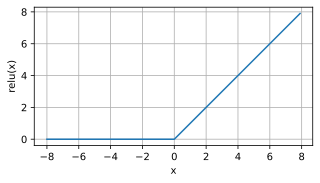

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

When the input is negative,
the derivative of the ReLU function is 0,
and when the input is positive,
the derivative of the ReLU function is 1.
Note that the ReLU function is not differentiable
when the input takes value precisely equal to 0.
In these cases, we default to the left-hand-side
derivative and say that the derivative is 0 when the input is 0.
We can get away with this because
the input may never actually be zero (mathematicians would
say that it is nondifferentiable on a set of measure zero).
There is an old adage that if subtle boundary conditions matter,
we are probably doing (*real*) mathematics, not engineering.
That conventional wisdom may apply here, or at least, the fact that
we are not performing constrained optimization :cite:`Mangasarian.1965,Rockafellar.1970`.
We plot the derivative of the ReLU function below.


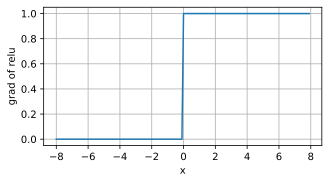

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

The reason for using ReLU is that
its derivatives are particularly well behaved:
either they vanish or they just let the argument through.
This makes optimization better behaved
and it mitigated the well-documented problem
of vanishing gradients that plagued
previous versions of neural networks (more on this later).

Note that there are many variants to the ReLU function,
including the *parametrized ReLU* (*pReLU*) function :cite:`He.Zhang.Ren.ea.2015`.
This variation adds a linear term to ReLU,
so some information still gets through,
even when the argument is negative:

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

### Sigmoid Function

[**The *sigmoid function* transforms those inputs**]
whose values lie in the domain $\mathbb{R}$,
(**to outputs that lie on the interval (0, 1).**)
For that reason, the sigmoid is
often called a *squashing function*:
it squashes any input in the range (-inf, inf)
to some value in the range (0, 1):

$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

In the earliest neural networks, scientists
were interested in modeling biological neurons
that either *fire* or *do not fire*.
Thus the pioneers of this field,
going all the way back to McCulloch and Pitts,
the inventors of the artificial neuron,
focused on thresholding units :cite:`McCulloch.Pitts.1943`.
A thresholding activation takes value 0
when its input is below some threshold
and value 1 when the input exceeds the threshold.

When attention shifted to gradient-based learning,
the sigmoid function was a natural choice
because it is a smooth, differentiable
approximation to a thresholding unit.
Sigmoids are still widely used as
activation functions on the output units
when we want to interpret the outputs as probabilities
for binary classification problems: you can think of the sigmoid as a special case of the softmax.
However, the sigmoid has largely been replaced
by the simpler and more easily trainable ReLU
for most use in hidden layers. Much of this has to do
with the fact that the sigmoid poses challenges for optimization
:cite:`LeCun.Bottou.Orr.ea.1998` since its gradient vanishes for large positive *and* negative arguments.
This can lead to plateaus that are difficult to escape from.
Nonetheless sigmoids are important. In later chapters (e.g., :numref:`sec_lstm`) on recurrent neural networks,
we will describe architectures that leverage sigmoid units
to control the flow of information across time.

Below, we plot the sigmoid function.
Note that when the input is close to 0,
the sigmoid function approaches
a linear transformation.


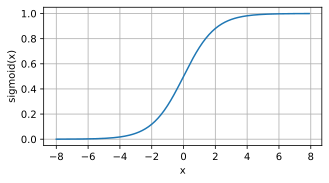

In [ ]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

The derivative of the sigmoid function is given by the following equation:

$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$


The derivative of the sigmoid function is plotted below.
Note that when the input is 0,
the derivative of the sigmoid function
reaches a maximum of 0.25.
As the input diverges from 0 in either direction,
the derivative approaches 0.


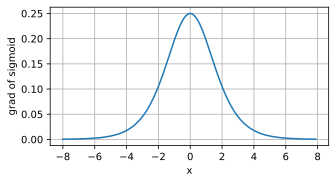

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### Tanh Function
:label:`subsec_tanh`

Like the sigmoid function, [**the tanh (hyperbolic tangent)
function also squashes its inputs**],
transforming them into elements on the interval (**between $-1$ and $1$**):

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

We plot the tanh function below. Note that as input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to that of the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system :cite:`Kalman.Kwasny.1992`.


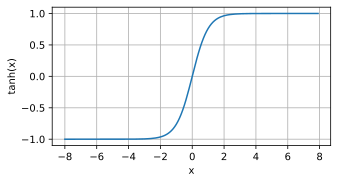

In [ ]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

The derivative of the tanh function is:

$$\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x).$$

It is plotted below.
As the input nears 0,
the derivative of the tanh function approaches a maximum of 1.
And as we saw with the sigmoid function,
as input moves away from 0 in either direction,
the derivative of the tanh function approaches 0.


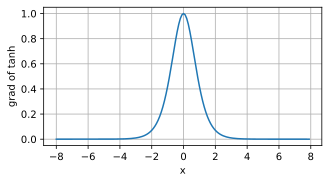

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## Summary and Discussion

We now know how to incorporate nonlinearities
to build expressive multilayer neural network architectures.
As a side note, your knowledge already
puts you in command of a similar toolkit
to a practitioner circa 1990.
In some ways, you have an advantage
over anyone working back then,
because you can leverage powerful
open-source deep learning frameworks
to build models rapidly, using only a few lines of code.
Previously, training these networks
required researchers to code up layers and derivatives
explicitly in C, Fortran, or even Lisp (in the case of LeNet).

A secondary benefit is that ReLU is significantly more amenable to
optimization than the sigmoid or the tanh function. One could argue
that this was one of the key innovations that helped the resurgence
of deep learning over the past decade. Note, though, that research in
activation functions has not stopped.
For instance,
the GELU (Gaussian error linear unit)
activation function $x \Phi(x)$ by :citet:`Hendrycks.Gimpel.2016` ($\Phi(x)$
is the standard Gaussian cumulative distribution function)
and
the Swish activation
function $\sigma(x) = x \operatorname{sigmoid}(\beta x)$ as proposed in :citet:`Ramachandran.Zoph.Le.2017` can yield better accuracy
in many cases.

## Exercises

1. Show that adding layers to a *linear* deep network, i.e., a network without
   nonlinearity $\sigma$ can never increase the expressive power of the network.
   Give an example where it actively reduces it.
1. Compute the derivative of the pReLU activation function.
1. Compute the derivative of the Swish activation function $x \operatorname{sigmoid}(\beta x)$.
1. Show that an MLP using only ReLU (or pReLU) constructs a
   continuous piecewise linear function.
1. Sigmoid and tanh are very similar.
    1. Show that $\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$.
    1. Prove that the function classes parametrized by both nonlinearities are identical. Hint: affine layers have bias terms, too.
1. Assume that we have a nonlinearity that applies to one minibatch at a time, such as the batch normalization :cite:`Ioffe.Szegedy.2015`. What kinds of problems do you expect this to cause?
1. Provide an example where the gradients vanish for the sigmoid activation function.


[Discussions](https://discuss.d2l.ai/t/91)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Implementation of Multilayer Perceptrons
:label:`sec_mlp-implementation`

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual
difference is that we now concatenate multiple layers.


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## Implementation from Scratch

Let's begin again by implementing such a network from scratch.

### Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
As before we will disregard the spatial structure
among the pixels for now,
so we can think of this as a classification dataset
with 784 input features and 10 classes.
To begin, we will [**implement an MLP
with one hidden layer and 256 hidden units.**]
Both the number of layers and their width are adjustable
(they are considered hyperparameters).
Typically, we choose the layer widths to be divisible by larger powers of 2.
This is computationally efficient due to the way
memory is allocated and addressed in hardware.

Again, we will represent our parameters with several tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
As always, we allocate memory
for the gradients of the loss with respect to these parameters.


In the code below we use `nn.Parameter`
to automatically register
a class attribute as a parameter to be tracked by `autograd` (:numref:`sec_autograd`).


In [ ]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

### Model

To make sure we know how everything works,
we will [**implement the ReLU activation**] ourselves
rather than invoking the built-in `relu` function directly.


In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

Since we are disregarding spatial structure,
we `reshape` each two-dimensional image into
a flat vector of length  `num_inputs`.
Finally, we (**implement our model**)
with just a few lines of code. Since we use the framework built-in autograd this is all that it takes.


In [ ]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

### Training

Fortunately, [**the training loop for MLPs
is exactly the same as for softmax regression.**] We define the model, data, and trainer, then finally invoke the `fit` method on model and data.


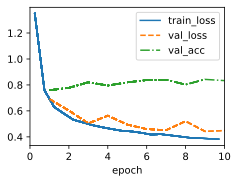

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Concise Implementation

As you might expect, by relying on the high-level APIs, we can implement MLPs even more concisely.

### Model

Compared with our concise implementation
of softmax regression implementation
(:numref:`sec_softmax_concise`),
the only difference is that we add
*two* fully connected layers where we previously added only *one*.
The first is [**the hidden layer**],
the second is the output layer.


In [ ]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

Previously, we defined `forward` methods for models to transform input using the model parameters.
These operations are essentially a pipeline:
you take an input and
apply a transformation (e.g.,
matrix multiplication with weights followed by bias addition),
then repetitively use the output of the current transformation as
input to the next transformation.
However, you may have noticed that
no `forward` method is defined here.
In fact, `MLP` inherits the `forward` method from the `Module` class (:numref:`subsec_oo-design-models`) to
simply invoke `self.net(X)` (`X` is input),
which is now defined as a sequence of transformations
via the `Sequential` class.
The `Sequential` class abstracts the forward process
enabling us to focus on the transformations.
We will further discuss how the `Sequential` class works in :numref:`subsec_model-construction-sequential`.


### Training

[**The training loop**] is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from orthogonal considerations.


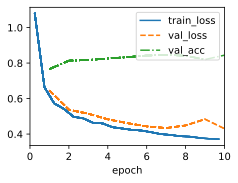

In [ ]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

## Summary

Now that we have more practice in designing deep networks, the step from a single to multiple layers of deep networks does not pose such a significant challenge any longer. In particular, we can reuse the training algorithm and data loader. Note, though, that implementing MLPs from scratch is nonetheless messy: naming and keeping track of the model parameters makes it difficult to extend models. For instance, imagine wanting to insert another layer between layers 42 and 43. This might now be layer 42b, unless we are willing to perform sequential renaming. Moreover, if we implement the network from scratch, it is much more difficult for the framework to perform meaningful performance optimizations.

Nonetheless, you have now reached the state of the art of the late 1980s when fully connected deep networks were the method of choice for neural network modeling. Our next conceptual step will be to consider images. Before we do so, we need to review a number of statistical basics and details on how to compute models efficiently.


## Exercises

1. Change the number of hidden units `num_hiddens` and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?
1. Try adding a hidden layer to see how it affects the results.
1. Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?
1. How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?
1. Let's optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
    1. What is the best result you can get by optimizing over all of them?
    1. Why it is much more challenging to deal with multiple hyperparameters?
    1. Describe an efficient strategy for optimizing over multiple parameters jointly.
1. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?
1. Measure the speed of tensor--matrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.
    1. How does this change between GPUs and CPUs?
    1. Determine the memory bus width of your CPU and GPU.
1. Try out different activation functions. Which one works best?
1. Is there a difference between weight initializations of the network? Does it matter?


[Discussions](https://discuss.d2l.ai/t/93)


# Forward Propagation, Backward Propagation, and Computational Graphs
:label:`sec_backprop`

So far, we have trained our models
with minibatch stochastic gradient descent.
However, when we implemented the algorithm,
we only worried about the calculations involved
in *forward propagation* through the model.
When it came time to calculate the gradients,
we just invoked the backpropagation function provided by the deep learning framework.

The automatic calculation of gradients
profoundly simplifies
the implementation of deep learning algorithms.
Before automatic differentiation,
even small changes to complicated models required
recalculating complicated derivatives by hand.
Surprisingly often, academic papers had to allocate
numerous pages to deriving update rules.
While we must continue to rely on automatic differentiation
so we can focus on the interesting parts,
you ought to know how these gradients
are calculated under the hood
if you want to go beyond a shallow
understanding of deep learning.

In this section, we take a deep dive
into the details of *backward propagation*
(more commonly called *backpropagation*).
To convey some insight for both the
techniques and their implementations,
we rely on some basic mathematics and computational graphs.
To start, we focus our exposition on
a one-hidden-layer MLP
with weight decay ($\ell_2$ regularization, to be described in subsequent chapters).

## Forward Propagation

*Forward propagation* (or *forward pass*) refers to the calculation and storage
of intermediate variables (including outputs)
for a neural network in order
from the input layer to the output layer.
We now work step-by-step through the mechanics
of a neural network with one hidden layer.
This may seem tedious but in the eternal words
of funk virtuoso James Brown,
you must "pay the cost to be the boss".


For the sake of simplicity, let's assume
that the input example is $\mathbf{x}\in \mathbb{R}^d$
and that our hidden layer does not include a bias term.
Here the intermediate variable is:

$$\mathbf{z}= \mathbf{W}^{(1)} \mathbf{x},$$

where $\mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$
is the weight parameter of the hidden layer.
After running the intermediate variable
$\mathbf{z}\in \mathbb{R}^h$ through the
activation function $\phi$
we obtain our hidden activation vector of length $h$:

$$\mathbf{h}= \phi (\mathbf{z}).$$

The hidden layer output $\mathbf{h}$
is also an intermediate variable.
Assuming that the parameters of the output layer
possess only a weight of
$\mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$,
we can obtain an output layer variable
with a vector of length $q$:

$$\mathbf{o}= \mathbf{W}^{(2)} \mathbf{h}.$$

Assuming that the loss function is $l$
and the example label is $y$,
we can then calculate the loss term
for a single data example,

$$L = l(\mathbf{o}, y).$$

As we will see the definition of $\ell_2$ regularization
to be introduced later,
given the hyperparameter $\lambda$,
the regularization term is

$$s = \frac{\lambda}{2} \left(\|\mathbf{W}^{(1)}\|_\textrm{F}^2 + \|\mathbf{W}^{(2)}\|_\textrm{F}^2\right),$$
:eqlabel:`eq_forward-s`

where the Frobenius norm of the matrix
is simply the $\ell_2$ norm applied
after flattening the matrix into a vector.
Finally, the model's regularized loss
on a given data example is:

$$J = L + s.$$

We refer to $J$ as the *objective function*
in the following discussion.


## Computational Graph of Forward Propagation

Plotting *computational graphs* helps us visualize
the dependencies of operators
and variables within the calculation.
:numref:`fig_forward` contains the graph associated
with the simple network described above,
where squares denote variables and circles denote operators.
The lower-left corner signifies the input
and the upper-right corner is the output.
Notice that the directions of the arrows
(which illustrate data flow)
are primarily rightward and upward.

![Computational graph of forward propagation.](http://d2l.ai/_images/forward.svg)
:label:`fig_forward`

## Backpropagation

*Backpropagation* refers to the method of calculating
the gradient of neural network parameters.
In short, the method traverses the network in reverse order,
from the output to the input layer,
according to the *chain rule* from calculus.
The algorithm stores any intermediate variables
(partial derivatives)
required while calculating the gradient
with respect to some parameters.
Assume that we have functions
$\mathsf{Y}=f(\mathsf{X})$
and $\mathsf{Z}=g(\mathsf{Y})$,
in which the input and the output
$\mathsf{X}, \mathsf{Y}, \mathsf{Z}$
are tensors of arbitrary shapes.
By using the chain rule,
we can compute the derivative
of $\mathsf{Z}$ with respect to $\mathsf{X}$ via

$$\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \textrm{prod}\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right).$$

Here we use the $\textrm{prod}$ operator
to multiply its arguments
after the necessary operations,
such as transposition and swapping input positions,
have been carried out.
For vectors, this is straightforward:
it is simply matrix--matrix multiplication.
For higher dimensional tensors,
we use the appropriate counterpart.
The operator $\textrm{prod}$ hides all the notational overhead.

Recall that
the parameters of the simple network with one hidden layer,
whose computational graph is in :numref:`fig_forward`,
are $\mathbf{W}^{(1)}$ and $\mathbf{W}^{(2)}$.
The objective of backpropagation is to
calculate the gradients $\partial J/\partial \mathbf{W}^{(1)}$
and $\partial J/\partial \mathbf{W}^{(2)}$.
To accomplish this, we apply the chain rule
and calculate, in turn, the gradient of
each intermediate variable and parameter.
The order of calculations are reversed
relative to those performed in forward propagation,
since we need to start with the outcome of the computational graph
and work our way towards the parameters.
The first step is to calculate the gradients
of the objective function $J=L+s$
with respect to the loss term $L$
and the regularization term $s$:

$$\frac{\partial J}{\partial L} = 1 \; \textrm{and} \; \frac{\partial J}{\partial s} = 1.$$

Next, we compute the gradient of the objective function
with respect to variable of the output layer $\mathbf{o}$
according to the chain rule:

$$
\frac{\partial J}{\partial \mathbf{o}}
= \textrm{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \mathbf{o}}\right)
= \frac{\partial L}{\partial \mathbf{o}}
\in \mathbb{R}^q.
$$

Next, we calculate the gradients
of the regularization term
with respect to both parameters:

$$\frac{\partial s}{\partial \mathbf{W}^{(1)}} = \lambda \mathbf{W}^{(1)}
\; \textrm{and} \;
\frac{\partial s}{\partial \mathbf{W}^{(2)}} = \lambda \mathbf{W}^{(2)}.$$

Now we are able to calculate the gradient
$\partial J/\partial \mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$
of the model parameters closest to the output layer.
Using the chain rule yields:

$$\frac{\partial J}{\partial \mathbf{W}^{(2)}}= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{W}^{(2)}}\right) + \textrm{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(2)}}\right)= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top + \lambda \mathbf{W}^{(2)}.$$
:eqlabel:`eq_backprop-J-h`

To obtain the gradient with respect to $\mathbf{W}^{(1)}$
we need to continue backpropagation
along the output layer to the hidden layer.
The gradient with respect to the hidden layer output
$\partial J/\partial \mathbf{h} \in \mathbb{R}^h$ is given by


$$
\frac{\partial J}{\partial \mathbf{h}}
= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{h}}\right)
= {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}.
$$

Since the activation function $\phi$ applies elementwise,
calculating the gradient $\partial J/\partial \mathbf{z} \in \mathbb{R}^h$
of the intermediate variable $\mathbf{z}$
requires that we use the elementwise multiplication operator,
which we denote by $\odot$:

$$
\frac{\partial J}{\partial \mathbf{z}}
= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{h}}, \frac{\partial \mathbf{h}}{\partial \mathbf{z}}\right)
= \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right).
$$

Finally, we can obtain the gradient
$\partial J/\partial \mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$
of the model parameters closest to the input layer.
According to the chain rule, we get

$$
\frac{\partial J}{\partial \mathbf{W}^{(1)}}
= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{z}}, \frac{\partial \mathbf{z}}{\partial \mathbf{W}^{(1)}}\right) + \textrm{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(1)}}\right)
= \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top + \lambda \mathbf{W}^{(1)}.
$$



## Training Neural Networks

When training neural networks,
forward and backward propagation depend on each other.
In particular, for forward propagation,
we traverse the computational graph in the direction of dependencies
and compute all the variables on its path.
These are then used for backpropagation
where the compute order on the graph is reversed.

Take the aforementioned simple network as an illustrative example.
On the one hand,
computing the regularization term :eqref:`eq_forward-s`
during forward propagation
depends on the current values of model parameters $\mathbf{W}^{(1)}$ and $\mathbf{W}^{(2)}$.
They are given by the optimization algorithm according to backpropagation in the most recent iteration.
On the other hand,
the gradient calculation for the parameter
:eqref:`eq_backprop-J-h` during backpropagation
depends on the current value of the hidden layer output $\mathbf{h}$,
which is given by forward propagation.


Therefore when training neural networks, once model parameters are initialized,
we alternate forward propagation with backpropagation,
updating model parameters using gradients given by backpropagation.
Note that backpropagation reuses the stored intermediate values from forward propagation to avoid duplicate calculations.
One of the consequences is that we need to retain
the intermediate values until backpropagation is complete.
This is also one of the reasons why training
requires significantly more memory than plain prediction.
Besides, the size of such intermediate values is roughly
proportional to the number of network layers and the batch size.
Thus,
training deeper networks using larger batch sizes
more easily leads to *out-of-memory* errors.


## Summary

Forward propagation sequentially calculates and stores intermediate variables within the computational graph defined by the neural network. It proceeds from the input to the output layer.
Backpropagation sequentially calculates and stores the gradients of intermediate variables and parameters within the neural network in the reversed order.
When training deep learning models, forward propagation and backpropagation are interdependent,
and training requires significantly more memory than prediction.


## Exercises

1. Assume that the inputs $\mathbf{X}$ to some scalar function $f$ are $n \times m$ matrices. What is the dimensionality of the gradient of $f$ with respect to $\mathbf{X}$?
1. Add a bias to the hidden layer of the model described in this section (you do not need to include bias in the regularization term).
    1. Draw the corresponding computational graph.
    1. Derive the forward and backward propagation equations.
1. Compute the memory footprint for training and prediction in the model described in this section.
1. Assume that you want to compute second derivatives. What happens to the computational graph? How long do you expect the calculation to take?
1. Assume that the computational graph is too large for your GPU.
    1. Can you partition it over more than one GPU?
    1. What are the advantages and disadvantages over training on a smaller minibatch?

[Discussions](https://discuss.d2l.ai/t/102)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Numerical Stability and Initialization
:label:`sec_numerical_stability`


Thus far, every model that we have implemented
required that we initialize its parameters
according to some pre-specified distribution.
Until now, we took the initialization scheme for granted,
glossing over the details of how these choices are made.
You might have even gotten the impression that these choices
are not especially important.
On the contrary, the choice of initialization scheme
plays a significant role in neural network learning,
and it can be crucial for maintaining numerical stability.
Moreover, these choices can be tied up in interesting ways
with the choice of the nonlinear activation function.
Which function we choose and how we initialize parameters
can determine how quickly our optimization algorithm converges.
Poor choices here can cause us to encounter
exploding or vanishing gradients while training.
In this section, we delve into these topics in greater detail
and discuss some useful heuristics
that you will find useful
throughout your career in deep learning.


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Vanishing and Exploding Gradients

Consider a deep network with $L$ layers,
input $\mathbf{x}$ and output $\mathbf{o}$.
With each layer $l$ defined by a transformation $f_l$
parametrized by weights $\mathbf{W}^{(l)}$,
whose hidden layer output is $\mathbf{h}^{(l)}$ (let $\mathbf{h}^{(0)} = \mathbf{x}$),
our network can be expressed as:

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \textrm{ and thus } \mathbf{o} = f_L \circ \cdots \circ f_1(\mathbf{x}).$$

If all the hidden layer output and the input are vectors,
we can write the gradient of $\mathbf{o}$ with respect to
any set of parameters $\mathbf{W}^{(l)}$ as follows:

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\textrm{def}}{=}} \cdots \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\textrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\textrm{def}}{=}}.$$

In other words, this gradient is
the product of $L-l$ matrices
$\mathbf{M}^{(L)} \cdots \mathbf{M}^{(l+1)}$
and the gradient vector $\mathbf{v}^{(l)}$.
Thus we are susceptible to the same
problems of numerical underflow that often crop up
when multiplying together too many probabilities.
When dealing with probabilities, a common trick is to
switch into log-space, i.e., shifting
pressure from the mantissa to the exponent
of the numerical representation.
Unfortunately, our problem above is more serious:
initially the matrices $\mathbf{M}^{(l)}$ may have a wide variety of eigenvalues.
They might be small or large, and
their product might be *very large* or *very small*.

The risks posed by unstable gradients
go beyond numerical representation.
Gradients of unpredictable magnitude
also threaten the stability of our optimization algorithms.
We may be facing parameter updates that are either
(i) excessively large, destroying our model
(the *exploding gradient* problem);
or (ii) excessively small
(the *vanishing gradient* problem),
rendering learning impossible as parameters
hardly move on each update.


### (**Vanishing Gradients**)

One frequent culprit causing the vanishing gradient problem
is the choice of the activation function $\sigma$
that is appended following each layer's linear operations.
Historically, the sigmoid function
$1/(1 + \exp(-x))$ (introduced in :numref:`sec_mlp`)
was popular because it resembles a thresholding function.
Since early artificial neural networks were inspired
by biological neural networks,
the idea of neurons that fire either *fully* or *not at all*
(like biological neurons) seemed appealing.
Let's take a closer look at the sigmoid
to see why it can cause vanishing gradients.


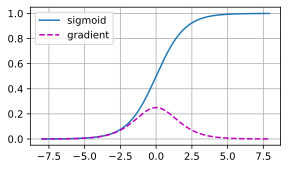

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

As you can see, (**the sigmoid's gradient vanishes
both when its inputs are large and when they are small**).
Moreover, when backpropagating through many layers,
unless we are in the Goldilocks zone, where
the inputs to many of the sigmoids are close to zero,
the gradients of the overall product may vanish.
When our network boasts many layers,
unless we are careful, the gradient
will likely be cut off at some layer.
Indeed, this problem used to plague deep network training.
Consequently, ReLUs, which are more stable
(but less neurally plausible),
have emerged as the default choice for practitioners.


### [**Exploding Gradients**]

The opposite problem, when gradients explode,
can be similarly vexing.
To illustrate this a bit better,
we draw 100 Gaussian random matrices
and multiply them with some initial matrix.
For the scale that we picked
(the choice of the variance $\sigma^2=1$),
the matrix product explodes.
When this happens because of the initialization
of a deep network, we have no chance of getting
a gradient descent optimizer to converge.


In [ ]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[-0.8755, -1.2171,  1.3316,  0.1357],
        [ 0.4399,  1.4073, -1.9131, -0.4608],
        [-2.1420,  0.3643, -0.5267,  1.0277],
        [-0.1734, -0.7549,  2.3024,  1.3085]])
after multiplying 100 matrices
 tensor([[-2.9185e+23,  1.3915e+25, -1.1865e+25,  1.4354e+24],
        [ 4.9142e+23, -2.3430e+25,  1.9979e+25, -2.4169e+24],
        [ 2.6578e+23, -1.2672e+25,  1.0805e+25, -1.3072e+24],
        [-5.2223e+23,  2.4899e+25, -2.1231e+25,  2.5684e+24]])


### Breaking the Symmetry

Another problem in neural network design
is the symmetry inherent in their parametrization.
Assume that we have a simple MLP
with one hidden layer and two units.
In this case, we could permute the weights $\mathbf{W}^{(1)}$
of the first layer and likewise permute
the weights of the output layer
to obtain the same function.
There is nothing special differentiating
the first and second hidden units.
In other words, we have permutation symmetry
among the hidden units of each layer.

This is more than just a theoretical nuisance.
Consider the aforementioned one-hidden-layer MLP
with two hidden units.
For illustration,
suppose that the output layer transforms the two hidden units into only one output unit.
Imagine what would happen if we initialized
all the parameters of the hidden layer
as $\mathbf{W}^{(1)} = c$ for some constant $c$.
In this case, during forward propagation
either hidden unit takes the same inputs and parameters
producing the same activation
which is fed to the output unit.
During backpropagation,
differentiating the output unit with respect to parameters $\mathbf{W}^{(1)}$ gives a gradient all of whose elements take the same value.
Thus, after gradient-based iteration (e.g., minibatch stochastic gradient descent),
all the elements of $\mathbf{W}^{(1)}$ still take the same value.
Such iterations would
never *break the symmetry* on their own
and we might never be able to realize
the network's expressive power.
The hidden layer would behave
as if it had only a single unit.
Note that while minibatch stochastic gradient descent would not break this symmetry,
dropout regularization (to be introduced later) would!


## Parameter Initialization

One way of addressing---or at least mitigating---the
issues raised above is through careful initialization.
As we will see later,
additional care during optimization
and suitable regularization can further enhance stability.


### Default Initialization

In the previous sections, e.g., in :numref:`sec_linear_concise`,
we used a normal distribution
to initialize the values of our weights.
If we do not specify the initialization method, the framework will
use a default random initialization method, which often works well in practice
for moderate problem sizes.






### Xavier Initialization
:label:`subsec_xavier`

Let's look at the scale distribution of
an output $o_{i}$ for some fully connected layer
*without nonlinearities*.
With $n_\textrm{in}$ inputs $x_j$
and their associated weights $w_{ij}$ for this layer,
an output is given by

$$o_{i} = \sum_{j=1}^{n_\textrm{in}} w_{ij} x_j.$$

The weights $w_{ij}$ are all drawn
independently from the same distribution.
Furthermore, let's assume that this distribution
has zero mean and variance $\sigma^2$.
Note that this does not mean that the distribution has to be Gaussian,
just that the mean and variance need to exist.
For now, let's assume that the inputs to the layer $x_j$
also have zero mean and variance $\gamma^2$
and that they are independent of $w_{ij}$ and independent of each other.
In this case, we can compute the mean of $o_i$:

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\textrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\textrm{in}} E[w_{ij}] E[x_j] \\&= 0, \end{aligned}$$

and the variance:

$$
\begin{aligned}
    \textrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\textrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

One way to keep the variance fixed
is to set $n_\textrm{in} \sigma^2 = 1$.
Now consider backpropagation.
There we face a similar problem,
albeit with gradients being propagated from the layers closer to the output.
Using the same reasoning as for forward propagation,
we see that the gradients' variance can blow up
unless $n_\textrm{out} \sigma^2 = 1$,
where $n_\textrm{out}$ is the number of outputs of this layer.
This leaves us in a dilemma:
we cannot possibly satisfy both conditions simultaneously.
Instead, we simply try to satisfy:

$$
\begin{aligned}
\frac{1}{2} (n_\textrm{in} + n_\textrm{out}) \sigma^2 = 1 \textrm{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\textrm{in} + n_\textrm{out}}}.
\end{aligned}
$$

This is the reasoning underlying the now-standard
and practically beneficial *Xavier initialization*,
named after the first author of its creators :cite:`Glorot.Bengio.2010`.
Typically, the Xavier initialization
samples weights from a Gaussian distribution
with zero mean and variance
$\sigma^2 = \frac{2}{n_\textrm{in} + n_\textrm{out}}$.
We can also adapt this to
choose the variance when sampling weights
from a uniform distribution.
Note that the uniform distribution $U(-a, a)$ has variance $\frac{a^2}{3}$.
Plugging $\frac{a^2}{3}$ into our condition on $\sigma^2$
prompts us to initialize according to

$$U\left(-\sqrt{\frac{6}{n_\textrm{in} + n_\textrm{out}}}, \sqrt{\frac{6}{n_\textrm{in} + n_\textrm{out}}}\right).$$

Though the assumption for nonexistence of nonlinearities
in the above mathematical reasoning
can be easily violated in neural networks,
the Xavier initialization method
turns out to work well in practice.


### Beyond

The reasoning above barely scratches the surface
of modern approaches to parameter initialization.
A deep learning framework often implements over a dozen different heuristics.
Moreover, parameter initialization continues to be
a hot area of fundamental research in deep learning.
Among these are heuristics specialized for
tied (shared) parameters, super-resolution,
sequence models, and other situations.
For instance,
:citet:`Xiao.Bahri.Sohl-Dickstein.ea.2018` demonstrated the possibility of training
10,000-layer neural networks without architectural tricks
by using a carefully-designed initialization method.

If the topic interests you we suggest
a deep dive into this module's offerings,
reading the papers that proposed and analyzed each heuristic,
and then exploring the latest publications on the topic.
Perhaps you will stumble across or even invent
a clever idea and contribute an implementation to deep learning frameworks.


## Summary

Vanishing and exploding gradients are common issues in deep networks. Great care in parameter initialization is required to ensure that gradients and parameters remain well controlled.
Initialization heuristics are needed to ensure that the initial gradients are neither too large nor too small.
Random initialization is key to ensuring that symmetry is broken before optimization.
Xavier initialization suggests that, for each layer, variance of any output is not affected by the number of inputs, and variance of any gradient is not affected by the number of outputs.
ReLU activation functions mitigate the vanishing gradient problem. This can accelerate convergence.

## Exercises

1. Can you design other cases where a neural network might exhibit symmetry that needs breaking, besides the permutation symmetry in an MLP's layers?
1. Can we initialize all weight parameters in linear regression or in softmax regression to the same value?
1. Look up analytic bounds on the eigenvalues of the product of two matrices. What does this tell you about ensuring that gradients are well conditioned?
1. If we know that some terms diverge, can we fix this after the fact? Look at the paper on layerwise adaptive rate scaling  for inspiration :cite:`You.Gitman.Ginsburg.2017`.


[Discussions](https://discuss.d2l.ai/t/104)


# Generalization in Deep Learning


In :numref:`chap_regression` and :numref:`chap_classification`,
we tackled regression and classification problems
by fitting linear models to training data.
In both cases, we provided practical algorithms
for finding the parameters that maximized
the likelihood of the observed training labels.
And then, towards the end of each chapter,
we recalled that fitting the training data
was only an intermediate goal.
Our real quest all along was to discover *general patterns*
on the basis of which we can make accurate predictions
even on new examples drawn from the same underlying population.
Machine learning researchers are *consumers* of optimization algorithms.
Sometimes, we must even develop new optimization algorithms.
But at the end of the day, optimization is merely a means to an end.
At its core, machine learning is a statistical discipline
and we wish to optimize training loss only insofar
as some statistical principle (known or unknown)
leads the resulting models to generalize beyond the training set.


On the bright side, it turns out that deep neural networks
trained by stochastic gradient descent generalize remarkably well
across myriad prediction problems, spanning computer vision;
natural language processing; time series data; recommender systems;
electronic health records; protein folding;
value function approximation in video games
and board games; and numerous other domains.
On the downside, if you were looking
for a straightforward account
of either the optimization story
(why we can fit them to training data)
or the generalization story
(why the resulting models generalize to unseen examples),
then you might want to pour yourself a drink.
While our procedures for optimizing linear models
and the statistical properties of the solutions
are both described well by a comprehensive body of theory,
our understanding of deep learning
still resembles the wild west on both fronts.

Both the theory and practice of deep learning
are rapidly evolving,
with theorists adopting new strategies
to explain what's going on,
even as practitioners continue
to innovate at a blistering pace,
building arsenals of heuristics for training deep networks
and a body of intuitions and folk knowledge
that provide guidance for deciding
which techniques to apply in which situations.

The summary of the present moment is that the theory of deep learning
has produced promising lines of attack and scattered fascinating results,
but still appears far from a comprehensive account
of both (i) why we are able to optimize neural networks
and (ii) how models learned by gradient descent
manage to generalize so well, even on high-dimensional tasks.
However, in practice, (i) is seldom a problem
(we can always find parameters that will fit all of our training data)
and thus understanding generalization is far the bigger problem.
On the other hand, even absent the comfort of a coherent scientific theory,
practitioners have developed a large collection of techniques
that may help you to produce models that generalize well in practice.
While no pithy summary can possibly do justice
to the vast topic of generalization in deep learning,
and while the overall state of research is far from resolved,
we hope, in this section, to present a broad overview
of the state of research and practice.


## Revisiting Overfitting and Regularization

According to the "no free lunch" theorem of :citet:`wolpert1995no`,
any learning algorithm generalizes better on data with certain distributions, and worse with other distributions.
Thus, given a finite training set,
a model relies on certain assumptions:
to achieve human-level performance
it may be useful to identify *inductive biases*
that reflect how humans think about the world.
Such inductive biases show preferences
for solutions with certain properties.
For example,
a deep MLP has an inductive bias
towards building up a complicated function by the composition of simpler functions.

With machine learning models encoding inductive biases,
our approach to training them
typically consists of two phases: (i) fit the training data;
and (ii) estimate the *generalization error*
(the true error on the underlying population)
by evaluating the model on holdout data.
The difference between our fit on the training data
and our fit on the test data is called the *generalization gap* and when this is large,
we say that our models *overfit* to the training data.
In extreme cases of overfitting,
we might exactly fit the training data,
even when the test error remains significant.
And in the classical view,
the interpretation is that our models are too complex,
requiring that we either shrink the number of features,
the number of nonzero parameters learned,
or the size of the parameters as quantified.
Recall the plot of model complexity compared with loss
(:numref:`fig_capacity_vs_error`)
from :numref:`sec_generalization_basics`.


However deep learning complicates this picture in counterintuitive ways.
First, for classification problems,
our models are typically expressive enough
to perfectly fit every training example,
even in datasets consisting of millions
:cite:`zhang2021understanding`.
In the classical picture, we might think
that this setting lies on the far right extreme
of the model complexity axis,
and that any improvements in generalization error
must come by way of regularization,
either by reducing the complexity of the model class,
or by applying a penalty, severely constraining
the set of values that our parameters might take.
But that is where things start to get weird.

Strangely, for many deep learning tasks
(e.g., image recognition and text classification)
we are typically choosing among model architectures,
all of which can achieve arbitrarily low training loss
(and zero training error).
Because all models under consideration achieve zero training error,
*the only avenue for further gains is to reduce overfitting*.
Even stranger, it is often the case that
despite fitting the training data perfectly,
we can actually *reduce the generalization error*
further by making the model *even more expressive*,
e.g., adding layers, nodes, or training
for a larger number of epochs.
Stranger yet, the pattern relating the generalization gap
to the *complexity* of the model (as captured, for example, in the depth or width of the networks)
can be non-monotonic,
with greater complexity hurting at first
but subsequently helping in a so-called "double-descent" pattern
:cite:`nakkiran2021deep`.
Thus the deep learning practitioner possesses a bag of tricks,
some of which seemingly restrict the model in some fashion
and others that seemingly make it even more expressive,
and all of which, in some sense, are applied to mitigate overfitting.

Complicating things even further,
while the guarantees provided by classical learning theory
can be conservative even for classical models,
they appear powerless to explain why it is
that deep neural networks generalize in the first place.
Because deep neural networks are capable of fitting
arbitrary labels even for large datasets,
and despite the use of familiar methods such as $\ell_2$ regularization,
traditional complexity-based generalization bounds,
e.g., those based on the VC dimension
or Rademacher complexity of a hypothesis class
cannot explain why neural networks generalize.

## Inspiration from Nonparametrics

Approaching deep learning for the first time,
it is tempting to think of them as parametric models.
After all, the models *do* have millions of parameters.
When we update the models, we update their parameters.
When we save the models, we write their parameters to disk.
However, mathematics and computer science are riddled
with counterintuitive changes of perspective,
and surprising isomorphisms between seemingly different problems.
While neural networks clearly *have* parameters,
in some ways it can be more fruitful
to think of them as behaving like nonparametric models.
So what precisely makes a model nonparametric?
While the name covers a diverse set of approaches,
one common theme is that nonparametric methods
tend to have a level of complexity that grows
as the amount of available data grows.

Perhaps the simplest example of a nonparametric model
is the $k$-nearest neighbor algorithm (we will cover more nonparametric models later, for example in :numref:`sec_attention-pooling`).
Here, at training time,
the learner simply memorizes the dataset.
Then, at prediction time,
when confronted with a new point $\mathbf{x}$,
the learner looks up the $k$ nearest neighbors
(the $k$ points $\mathbf{x}_i'$ that minimize
some distance $d(\mathbf{x}, \mathbf{x}_i')$).
When $k=1$, this algorithm is called $1$-nearest neighbors,
and the algorithm will always achieve a training error of zero.
That however, does not mean that the algorithm will not generalize.
In fact, it turns out that under some mild conditions,
the 1-nearest neighbor algorithm is consistent
(eventually converging to the optimal predictor).


Note that $1$-nearest neighbor requires that we specify
some distance function $d$, or equivalently,
that we specify some vector-valued basis function $\phi(\mathbf{x})$
for featurizing our data.
For any choice of the distance metric,
we will achieve zero training error
and eventually reach an optimal predictor,
but different distance metrics $d$
encode different inductive biases
and with a finite amount of available data
will yield different predictors.
Different choices of the distance metric $d$
represent different assumptions about the underlying patterns
and the performance of the different predictors
will depend on how compatible the assumptions
are with the observed data.

In a sense, because neural networks are over-parametrized,
possessing many more parameters than are needed to fit the training data,
they tend to *interpolate* the training data (fitting it perfectly)
and thus behave, in some ways, more like nonparametric models.
More recent theoretical research has established
deep connection between large neural networks
and nonparametric methods, notably kernel methods.
In particular, :citet:`Jacot.Grabriel.Hongler.2018`
demonstrated that in the limit, as multilayer perceptrons
with randomly initialized weights grow infinitely wide,
they become equivalent to (nonparametric) kernel methods
for a specific choice of the kernel function
(essentially, a distance function),
which they call the neural tangent kernel.
While current neural tangent kernel models may not fully explain
the behavior of modern deep networks,
their success as an analytical tool
underscores the usefulness of nonparametric modeling
for understanding the behavior of over-parametrized deep networks.


## Early Stopping

While deep neural networks are capable of fitting arbitrary labels,
even when labels are assigned incorrectly or randomly
:cite:`zhang2021understanding`,
this capability only emerges over many iterations of training.
A new line of work :cite:`Rolnick.Veit.Belongie.Shavit.2017`
has revealed that in the setting of label noise,
neural networks tend to fit cleanly labeled data first
and only subsequently to interpolate the mislabeled data.
Moreover, it has been established that this phenomenon
translates directly into a guarantee on generalization:
whenever a model has fitted the cleanly labeled data
but not randomly labeled examples included in the training set,
it has in fact generalized :cite:`Garg.Balakrishnan.Kolter.Lipton.2021`.

Together these findings help to motivate *early stopping*,
a classic technique for regularizing deep neural networks.
Here, rather than directly constraining the values of the weights,
one constrains the number of epochs of training.
The most common way to determine the stopping criterion
is to monitor validation error throughout training
(typically by checking once after each epoch)
and to cut off training when the validation error
has not decreased by more than some small amount $\epsilon$
for some number of epochs.
This is sometimes called a *patience criterion*.
As well as the potential to lead to better generalization
in the setting of noisy labels,
another benefit of early stopping is the time saved.
Once the patience criterion is met, one can terminate training.
For large models that might require days of training
simultaneously across eight or more GPUs,
well-tuned early stopping can save researchers days of time
and can save their employers many thousands of dollars.

Notably, when there is no label noise and datasets are *realizable*
(the classes are truly separable, e.g., distinguishing cats from dogs),
early stopping tends not to lead to significant improvements in generalization.
On the other hand, when there is label noise,
or intrinsic variability in the label
(e.g., predicting mortality among patients),
early stopping is crucial.
Training models until they interpolate noisy data is typically a bad idea.


## Classical Regularization Methods for Deep Networks

In :numref:`chap_regression`, we described
several  classical regularization techniques
for constraining the complexity of our models.
In particular, :numref:`sec_weight_decay`
introduced a method called weight decay,
which consists of adding a regularization term to the loss function
in order to penalize large values of the weights.
Depending on which weight norm is penalized
this technique is known either as ridge regularization (for $\ell_2$ penalty)
or lasso regularization (for an $\ell_1$ penalty).
In the classical analysis of these regularizers,
they are considered as sufficiently restrictive on the values
that the weights can take to prevent the model from fitting arbitrary labels.

In deep learning implementations,
weight decay remains a popular tool.
However, researchers have noted
that typical strengths of $\ell_2$ regularization
are insufficient to prevent the networks
from interpolating the data :cite:`zhang2021understanding` and thus the benefits if interpreted
as regularization might only make sense
in combination with the early stopping criterion.
Absent early stopping, it is possible
that just like the number of layers
or number of nodes (in deep learning)
or the distance metric (in 1-nearest neighbor),
these methods may lead to better generalization
not because they meaningfully constrain
the power of the neural network
but rather because they somehow encode inductive biases
that are better compatible with the patterns
found in datasets of interests.
Thus, classical regularizers remain popular
in deep learning implementations,
even if the theoretical rationale
for their efficacy may be radically different.

Notably, deep learning researchers have also built
on techniques first popularized
in classical regularization contexts,
such as adding noise to model inputs.
In the next section we will introduce
the famous dropout technique
(invented by :citet:`Srivastava.Hinton.Krizhevsky.ea.2014`),
which has become a mainstay of deep learning,
even as the theoretical basis for its efficacy
remains similarly mysterious.


## Summary

Unlike classical linear models,
which tend to have fewer parameters than examples,
deep networks tend to be over-parametrized,
and for most tasks are capable
of perfectly fitting the training set.
This *interpolation regime* challenges
many hard fast-held intuitions.
Functionally, neural networks look like parametric models.
But thinking of them as nonparametric models
can sometimes be a more reliable source of intuition.
Because it is often the case that all deep networks under consideration
are capable of fitting all of the training labels,
nearly all gains must come by mitigating overfitting
(closing the *generalization gap*).
Paradoxically, the interventions
that reduce the generalization gap
sometimes appear to increase model complexity
and at other times appear to decrease complexity.
However, these methods seldom decrease complexity
sufficiently for classical theory
to explain the generalization of deep networks,
and *why certain choices lead to improved generalization*
remains for the most part a massive open question
despite the concerted efforts of many brilliant researchers.


## Exercises

1. In what sense do traditional complexity-based measures fail to account for generalization of deep neural networks?
1. Why might *early stopping* be considered a regularization technique?
1. How do researchers typically determine the stopping criterion?
1. What important factor seems to differentiate cases when early stopping leads to big improvements in generalization?
1. Beyond generalization, describe another benefit of early stopping.

[Discussions](https://discuss.d2l.ai/t/7473)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Dropout
:label:`sec_dropout`


Let's think briefly about what we
expect from a good predictive model.
We want it to peform well on unseen data.
Classical generalization theory
suggests that to close the gap between
train and test performance,
we should aim for a simple model.
Simplicity can come in the form
of a small number of dimensions.
We explored this when discussing the
monomial basis functions of linear models
in :numref:`sec_generalization_basics`.
Additionally, as we saw when discussing weight decay
($\ell_2$ regularization) in :numref:`sec_weight_decay`,
the (inverse) norm of the parameters also
represents a useful measure of simplicity.
Another useful notion of simplicity is smoothness,
i.e., that the function should not be sensitive
to small changes to its inputs.
For instance, when we classify images,
we would expect that adding some random noise
to the pixels should be mostly harmless.

:citet:`Bishop.1995` formalized
this idea when he proved that training with input noise
is equivalent to Tikhonov regularization.
This work drew a clear mathematical connection
between the requirement that a function be smooth (and thus simple),
and the requirement that it be resilient
to perturbations in the input.

Then, :citet:`Srivastava.Hinton.Krizhevsky.ea.2014`
developed a clever idea for how to apply Bishop's idea
to the internal layers of a network, too.
Their idea, called *dropout*, involves
injecting noise while computing
each internal layer during forward propagation,
and it has become a standard technique
for training neural networks.
The method is called *dropout* because we literally
*drop out* some neurons during training.
Throughout training, on each iteration,
standard dropout consists of zeroing out
some fraction of the nodes in each layer
before calculating the subsequent layer.

To be clear, we are imposing
our own narrative with the link to Bishop.
The original paper on dropout
offers intuition through a surprising
analogy to sexual reproduction.
The authors argue that neural network overfitting
is characterized by a state in which
each layer relies on a specific
pattern of activations in the previous layer,
calling this condition *co-adaptation*.
Dropout, they claim, breaks up co-adaptation
just as sexual reproduction is argued to
break up co-adapted genes.
While such an justification of this theory is certainly up for debate,
the dropout technique itself has proved enduring,
and various forms of dropout are implemented
in most deep learning libraries.


The key challenge is how to inject this noise.
One idea is to inject it in an *unbiased* manner
so that the expected value of each layer---while fixing
the others---equals the value it would have taken absent noise.
In Bishop's work, he added Gaussian noise
to the inputs to a linear model.
At each training iteration, he added noise
sampled from a distribution with mean zero
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ to the input $\mathbf{x}$,
yielding a perturbed point $\mathbf{x}' = \mathbf{x} + \epsilon$.
In expectation, $E[\mathbf{x}'] = \mathbf{x}$.

In standard dropout regularization,
one zeros out some fraction of the nodes in each layer
and then *debiases* each layer by normalizing
by the fraction of nodes that were retained (not dropped out).
In other words,
with *dropout probability* $p$,
each intermediate activation $h$ is replaced by
a random variable $h'$ as follows:

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \textrm{ with probability } p \\
    \frac{h}{1-p} & \textrm{ otherwise}
\end{cases}
\end{aligned}
$$

By design, the expectation remains unchanged, i.e., $E[h'] = h$.


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## Dropout in Practice

Recall the MLP with a hidden layer and five hidden units
from :numref:`fig_mlp`.
When we apply dropout to a hidden layer,
zeroing out each hidden unit with probability $p$,
the result can be viewed as a network
containing only a subset of the original neurons.
In :numref:`fig_dropout2`, $h_2$ and $h_5$ are removed.
Consequently, the calculation of the outputs
no longer depends on $h_2$ or $h_5$
and their respective gradient also vanishes
when performing backpropagation.
In this way, the calculation of the output layer
cannot be overly dependent on any
one element of $h_1, \ldots, h_5$.

![MLP before and after dropout.](http://d2l.ai/_images/dropout2.svg)
:label:`fig_dropout2`

Typically, we disable dropout at test time.
Given a trained model and a new example,
we do not drop out any nodes
and thus do not need to normalize.
However, there are some exceptions:
some researchers use dropout at test time as a heuristic
for estimating the *uncertainty* of neural network predictions:
if the predictions agree across many different dropout outputs,
then we might say that the network is more confident.

## Implementation from Scratch

To implement the dropout function for a single layer,
we must draw as many samples
from a Bernoulli (binary) random variable
as our layer has dimensions,
where the random variable takes value $1$ (keep)
with probability $1-p$ and $0$ (drop) with probability $p$.
One easy way to implement this is to first draw samples
from the uniform distribution $U[0, 1]$.
Then we can keep those nodes for which the corresponding
sample is greater than $p$, dropping the rest.

In the following code, we (**implement a `dropout_layer` function
that drops out the elements in the tensor input `X`
with probability `dropout`**),
rescaling the remainder as described above:
dividing the survivors by `1.0-dropout`.


In [ ]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

We can [**test out the `dropout_layer` function on a few examples**].
In the following lines of code,
we pass our input `X` through the dropout operation,
with probabilities 0, 0.5, and 1, respectively.


In [ ]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  2.,  0.,  6.,  8.,  0.,  0.,  0.],
        [16., 18., 20., 22., 24., 26., 28., 30.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### Defining the Model

The model below applies dropout to the output
of each hidden layer (following the activation function).
We can set dropout probabilities for each layer separately.
A common choice is to set
a lower dropout probability closer to the input layer.
We ensure that dropout is only active during training.


In [ ]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

### [**Training**]

The following is similar to the training of MLPs described previously.


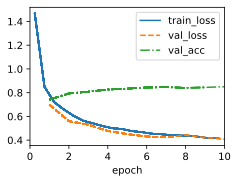

In [ ]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## [**Concise Implementation**]

With high-level APIs, all we need to do is add a `Dropout` layer
after each fully connected layer,
passing in the dropout probability
as the only argument to its constructor.
During training, the `Dropout` layer will randomly
drop out outputs of the previous layer
(or equivalently, the inputs to the subsequent layer)
according to the specified dropout probability.
When not in training mode,
the `Dropout` layer simply passes the data through during testing.


In [ ]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

Next, we [**train the model**].


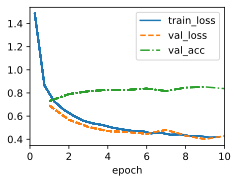

In [ ]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

## Summary

Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool for avoiding overfitting. Often tools are used jointly.
Note that dropout is
used only during training:
it replaces an activation $h$ with a random variable with expected value $h$.


## Exercises

1. What happens if you change the dropout probabilities for the first and second layers? In particular, what happens if you switch the ones for both layers? Design an experiment to answer these questions, describe your results quantitatively, and summarize the qualitative takeaways.
1. Increase the number of epochs and compare the results obtained when using dropout with those when not using it.
1. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.
1. Why is dropout not typically used at test time?
1. Using the model in this section as an example, compare the effects of using dropout and weight decay. What happens when dropout and weight decay are used at the same time? Are the results additive? Are there diminished returns (or worse)? Do they cancel each other out?
1. What happens if we apply dropout to the individual weights of the weight matrix rather than the activations?
1. Invent another technique for injecting random noise at each layer that is different from the standard dropout technique. Can you develop a method that outperforms dropout on the Fashion-MNIST dataset (for a fixed architecture)?


[Discussions](https://discuss.d2l.ai/t/101)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Predicting House Prices on Kaggle
:label:`sec_kaggle_house`

Now that we have introduced some basic tools
for building and training deep networks
and regularizing them with techniques including
weight decay and dropout,
we are ready to put all this knowledge into practice
by participating in a Kaggle competition.
The house price prediction competition
is a great place to start.
The data is fairly generic and do not exhibit exotic structure
that might require specialized models (as audio or video might).
This dataset, collected by :citet:`De-Cock.2011`,
covers house prices in Ames, Iowa from the period 2006--2010.
It is considerably larger than the famous [Boston housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names) of Harrison and Rubinfeld (1978),
boasting both more examples and more features.


In this section, we will walk you through details of
data preprocessing, model design, and hyperparameter selection.
We hope that through a hands-on approach,
you will gain some intuitions that will guide you
in your career as a data scientist.


In [ ]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## Downloading Data

Throughout the book, we will train and test models
on various downloaded datasets.
Here, we (**implement two utility functions**)
for downloading and extracting zip or tar files.
Again, we skip implementation details of
such utility functions.


In [ ]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

## Kaggle

[Kaggle](https://www.kaggle.com) is a popular platform
that hosts machine learning competitions.
Each competition centers on a dataset and many
are sponsored by stakeholders who offer prizes
to the winning solutions.
The platform helps users to interact
via forums and shared code,
fostering both collaboration and competition.
While leaderboard chasing often spirals out of control,
with researchers focusing myopically on preprocessing steps
rather than asking fundamental questions,
there is also tremendous value in the objectivity of a platform
that facilitates direct quantitative comparisons
among competing approaches as well as code sharing
so that everyone can learn what did and did not work.
If you want to participate in a Kaggle competition,
you will first need to register for an account
(see :numref:`fig_kaggle`).

![The Kaggle website.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/kaggle.png?raw=1)
:width:`400px`
:label:`fig_kaggle`

On the house price prediction competition page, as illustrated
in :numref:`fig_house_pricing`,
you can find the dataset (under the "Data" tab),
submit predictions, and see your ranking,
The URL is right here:

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![The house price prediction competition page.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/house-pricing.png?raw=1)
:width:`400px`
:label:`fig_house_pricing`

## Accessing and Reading the Dataset

Note that the competition data is separated
into training and test sets.
Each record includes the property value of the house
and attributes such as street type, year of construction,
roof type, basement condition, etc.
The features consist of various data types.
For example, the year of construction
is represented by an integer,
the roof type by discrete categorical assignments,
and other features by floating point numbers.
And here is where reality complicates things:
for some examples, some data is altogether missing
with the missing value marked simply as "na".
The price of each house is included
for the training set only
(it is a competition after all).
We will want to partition the training set
to create a validation set,
but we only get to evaluate our models on the official test set
after uploading predictions to Kaggle.
The "Data" tab on the competition tab
in :numref:`fig_house_pricing`
has links for downloading the data.

To get started, we will [**read in and process the data
using `pandas`**], which we introduced in :numref:`sec_pandas`.
For convenience, we can download and cache
the Kaggle housing dataset.
If a file corresponding to this dataset already exists in the cache directory and its SHA-1 matches `sha1_hash`, our code will use the cached file to avoid clogging up your Internet with redundant downloads.


In [ ]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

The training dataset includes 1460 examples,
80 features, and one label, while the validation data
contains 1459 examples and 80 features.


In [ ]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


## Data Preprocessing

Let's [**take a look at the first four and final two features
as well as the label (SalePrice)**] from the first four examples.


In [ ]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


We can see that in each example, the first feature is the identifier.
This helps the model determine each training example.
While this is convenient, it does not carry
any information for prediction purposes.
Hence, we will remove it from the dataset
before feeding the data into the model.
Furthermore, given a wide variety of data types,
we will need to preprocess the data before we can start modeling.


Let's start with the numerical features.
First, we apply a heuristic,
[**replacing all missing values
by the corresponding feature's mean.**]
Then, to put all features on a common scale,
we (***standardize* the data by
rescaling features to zero mean and unit variance**):

$$x \leftarrow \frac{x - \mu}{\sigma},$$

where $\mu$ and $\sigma$ denote mean and standard deviation, respectively.
To verify that this indeed transforms
our feature (variable) such that it has zero mean and unit variance,
note that $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$
and that $E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$.
Intuitively, we standardize the data
for two reasons.
First, it proves convenient for optimization.
Second, because we do not know *a priori*
which features will be relevant,
we do not want to penalize coefficients
assigned to one feature more than any other.

[**Next we deal with discrete values.**]
These include features such as "MSZoning".
(**We replace them by a one-hot encoding**)
in the same way that we earlier transformed
multiclass labels into vectors (see :numref:`subsec_classification-problem`).
For instance, "MSZoning" assumes the values "RL" and "RM".
Dropping the "MSZoning" feature,
two new indicator features
"MSZoning_RL" and "MSZoning_RM" are created with values being either 0 or 1.
According to one-hot encoding,
if the original value of "MSZoning" is "RL",
then "MSZoning_RL" is 1 and "MSZoning_RM" is 0.
The `pandas` package does this automatically for us.


In [ ]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

You can see that this conversion increases
the number of features from 79 to 331 (excluding ID and label columns).


In [ ]:
data.preprocess()
data.train.shape

(1460, 331)

## Error Measure

To get started we will train a linear model with squared loss. Not surprisingly, our linear model will not lead to a competition-winning submission but it does provide a sanity check to see whether there is meaningful information in the data. If we cannot do better than random guessing here, then there might be a good chance that we have a data processing bug. And if things work, the linear model will serve as a baseline giving us some intuition about how close the simple model gets to the best reported models, giving us a sense of how much gain we should expect from fancier models.

With house prices, as with stock prices,
we care about relative quantities
more than absolute quantities.
Thus [**we tend to care more about
the relative error $\frac{y - \hat{y}}{y}$**]
than about the absolute error $y - \hat{y}$.
For instance, if our prediction is off by \$100,000
when estimating the price of a house in rural Ohio,
where the value of a typical house is \$125,000,
then we are probably doing a horrible job.
On the other hand, if we err by this amount
in Los Altos Hills, California,
this might represent a stunningly accurate prediction
(there, the median house price exceeds \$4 million).

(**One way to address this problem is to
measure the discrepancy in the logarithm of the price estimates.**)
In fact, this is also the official error measure
used by the competition to evaluate the quality of submissions.
After all, a small value $\delta$ for $|\log y - \log \hat{y}| \leq \delta$
translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
This leads to the following root-mean-squared-error between the logarithm of the predicted price and the logarithm of the label price:

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [ ]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

## $K$-Fold Cross-Validation

You might recall that we introduced [**cross-validation**]
in :numref:`subsec_generalization-model-selection`, where we discussed how to deal
with model selection.
We will put this to good use to select the model design
and to adjust the hyperparameters.
We first need a function that returns
the $i^\textrm{th}$ fold of the data
in a $K$-fold cross-validation procedure.
It proceeds by slicing out the $i^\textrm{th}$ segment
as validation data and returning the rest as training data.
Note that this is not the most efficient way of handling data
and we would definitely do something much smarter
if our dataset was considerably larger.
But this added complexity might obfuscate our code unnecessarily
so we can safely omit it here owing to the simplicity of our problem.


In [ ]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

[**The average validation error is returned**]
when we train $K$ times in the $K$-fold cross-validation.


In [ ]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

## [**Model Selection**]

In this example, we pick an untuned set of hyperparameters
and leave it up to the reader to improve the model.
Finding a good choice can take time,
depending on how many variables one optimizes over.
With a large enough dataset,
and the normal sorts of hyperparameters,
$K$-fold cross-validation tends to be
reasonably resilient against multiple testing.
However, if we try an unreasonably large number of options
we might find that our validation
performance is no longer representative of the true error.


average validation log mse = 0.17325432986021042


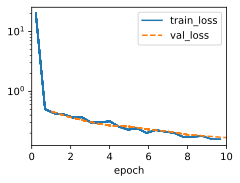

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

Notice that sometimes the number of training errors
for a set of hyperparameters can be very low,
even as the number of errors on $K$-fold cross-validation
grows considerably higher.
This indicates that we are overfitting.
Throughout training you will want to monitor both numbers.
Less overfitting might indicate that our data can support a more powerful model.
Massive overfitting might suggest that we can gain
by incorporating regularization techniques.

##  [**Submitting Predictions on Kaggle**]

Now that we know what a good choice of hyperparameters should be,
we might
calculate the average predictions
on the test set
by all the $K$ models.
Saving the predictions in a csv file
will simplify uploading the results to Kaggle.
The following code will generate a file called `submission.csv`.


In [ ]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

Next, as demonstrated in :numref:`fig_kaggle_submit2`,
we can submit our predictions on Kaggle
and see how they compare with the actual house prices (labels)
on the test set.
The steps are quite simple:

* Log in to the Kaggle website and visit the house price prediction competition page.
* Click the “Submit Predictions” or “Late Submission” button.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

![Submitting data to Kaggle](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/kaggle-submit2.png?raw=1)
:width:`400px`
:label:`fig_kaggle_submit2`

## Summary and Discussion

Real data often contains a mix of different data types and needs to be preprocessed.
Rescaling real-valued data to zero mean and unit variance is a good default. So is replacing missing values with their mean.
Furthermore, transforming categorical features into indicator features allows us to treat them like one-hot vectors.
When we tend to care more about
the relative error than about the absolute error,
we can
measure the discrepancy in the logarithm of the prediction.
To select the model and adjust the hyperparameters,
we can use $K$-fold cross-validation .



## Exercises

1. Submit your predictions for this section to Kaggle. How good are they?
1. Is it always a good idea to replace missing values by a mean? Hint: can you construct a situation where the values are not missing at random?
1. Improve the score by tuning the hyperparameters through $K$-fold cross-validation.
1. Improve the score by improving the model (e.g., layers, weight decay, and dropout).
1. What happens if we do not standardize the continuous numerical features as we have done in this section?


[Discussions](https://discuss.d2l.ai/t/107)
